# TEAM-SASA     
### Initial POC and EDA for Manila Bulletin Website

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from time import sleep

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## HELPER CLASS - WEBSCRAPING

In [2]:
DRIVER_PATH = 'C:\Program Files\chromedriver.exe'

class manilabulletinScraper:

    def __init__(self, search_url):
        self.urls = []
        self.search_url = search_url
        self.driver = webdriver.Chrome(DRIVER_PATH)

    def crawl(self):
        self.driver.get(self.search_url)
        totalpages = self.get_total_pages()
        self.get_pages(totalpages)

    def get_driver(self):
        return self.driver
        
    def get_urls(self):
        return self.urls

    def get_urls_count(self):
        return len(self.urls)

    def get_total_pages(self):
        pages = self.driver.find_element(By.CSS_SELECTOR, 'a.last')
        return int(pages.text)

    def add_urls(self, page):
        print(f'Start crawling article URLs for page {page}...')
        titles = self.driver.find_elements(By.XPATH, '//*[@id="news-feed"]/article/div/ul//h4/a')
        for title in titles:
            link = title.get_attribute('href')
            print(link)
            if (link != None) and (link not in self.urls):
                self.urls.append(link)
        print('done')

    def get_pages(self, totalpages):
        print(f'Total number of pages to crawl: {totalpages}', end='\n\n')
        # Page 1
        self.add_urls(1)
        # Page 2 onwards
        self.driver.maximize_window()
        for p in range(1, totalpages):
            x=0
            while x<1:
                print('before try')
                try:
                    main = WebDriverWait(self.driver, 10).until(
                                EC.presence_of_element_located((By.CSS_SELECTOR, 'i.mb-icon-arrow-right')))
                    self.driver.execute_script('window.scrollBy(0, document.body.scrollHeight)', '') 
                    self.driver.find_element(By.CSS_SELECTOR, 'i.mb-icon-arrow-right').click()
                    sleep(5)
                    self.add_urls(p+1)
                    x +=1
                except:
                    self.close_popups()
                    print('exception')
            sleep(5)
            
    def close_popups(self):
        try:
            self.driver.find_element(By.XPATH, '//*[@id="survicate-box"]/div/div/div[3]/div[2]/button').click()
        except:
            pass
        try:
            self.driver.find_element(By.XPATH, '//*[@id="onesignal-slidedown-cancel-button"]').click()
        except:
            pass
        try:
            # Close footer ads
            self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]//following::div/p/span').click()
        except:
            pass
        try:
            self.driver.find_element(By.XPATH, '//*[@id="PopupSignupForm_0"]/div[2]/div[1]').click()
        except:
            pass
        try:
            self.driver.find_element(By.XPATH, '//*[@id="dismiss-button"]/div/span').click()
        except:
            pass
        try:
            self.driver.find_element(By.ID, 'dismiss-button').click()
        except:
            pass
        
        

    def scrape_data(self, url):
        ### PREPARE ARTICLE URL
        self.driver.get(url)
        sleep(15)

        ### PREPARE TITLE
        title = self.driver.find_element(By.CSS_SELECTOR, 'h2.title')
        title = title.text
        print(f'\n[Title]\n{title}')

        ### PREPARE PUBLISHED DATE
        pubdate = self.driver.find_element(By.CSS_SELECTOR, 'p.published')
        pubdate = pubdate.text.replace('Published ', '')
        print(f'\n[Date Pulished]\n{pubdate}')

        ### PREPARE AUTHOR NAME
        author = self.driver.find_element(By.CSS_SELECTOR, 'p.author')
        author = author.text.replace('By ', '')
        print(f'\n[Author]\n{author}')

        # Try closing popups before clicking 'SEE THE RESULTS' button
        sleep(2)
        self.close_popups()

        ### PREPARE ARTICLE CONTENT
        article = self.driver.find_element(By.CSS_SELECTOR, 'section.article-content')
        article_content = article.text.replace('ADVERTISEMENT','').replace(' \n','').replace('\n ','').replace('\n\n','').replace('  ','')\
                                    .replace('SIGN UP TO DAILY NEWSLETTER', '').replace('\n','')\
                                    .replace('CLICK HERE TO SIGN-UP', '')
        print(f'\n[Content]\n{article_content}')

        ### PREPARE SENTIMENT RESULTS
        # Scroll to 'SEE THE RESULTS' button then simulate click to get sentiment results
        '''
        sleep(3)
        sentiment_classname = self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]/div[6]/div[4]/following::div').get_attribute('class')
        self.driver.execute_script(f'document.getElementsByClassName("{sentiment_classname}").scrollIntoView', '')
        
        # Automate click event to get sentiment results
        sentiment_index = 0
        for i in range(100):
            try:
                btn_sentiment = self.driver.find_element(By.XPATH, f'//*[@id="__next"]/div/div[16]/div[6]/div[4]/div[{i}]/div/div/span')
                if btn_sentiment.text.upper() == 'SEE THE RESULTS':
                    sleep(2)
                    self.close_popups()
                    action = ActionChains(self.driver)
                    action.move_to_element(btn_sentiment).click().perform()
                    # btn_sentiment.click()
                    sentiment_index = i
                    break
            except:
                pass

        sleep(3)
        # Clean some sentiment texts
        sentiment_results = self.driver.find_element(By.XPATH, f'//*[@id="__next"]/div/div[16]/div[6]/div[4]/div[{sentiment_index}]/div')
        sentiment_results = sentiment_results.text.replace('HOW OTHERS ARE FEELING', '').replace(' \n','').replace('\n ','').replace(' ARE ','-')
        # Convert each line of sentiment text to a list item
        sentiment_results = list(filter(None, sentiment_results.split('\n')))
        # Make a key-value pair of sentiment text and store it as dictionary object
        sentiment_results = {s.split('-')[1] : float(s.split('-')[0].split('%')[0])*.01 for s in sentiment_results}
        # Add a 0% value for sentiment key that does not have results in the current article and store as 'other sentiments'
        sentiment_keys = ['INSPIRED', 'HAPPY', 'AMUSED', 'NEUTRAL', 'ANNOYED', 'SAD', 'ANGRY', 'AFRAID']
        sentiment_others = {k : 0. for k in sentiment_keys if k not in sentiment_results}
        # Combine 'other sentiment dictionary' to the 'sentiment result dictionary' 
        sentiment_results = {**sentiment_results, **sentiment_others}
        print(f'\n[Sentiment]')
        print(sentiment_results)
        '''

        ### GET SENTIMENT RESULTS FROM ARTICLE
        return {'urls':url, 'titles':title, 'authors':author, 'published_dates':pubdate, 'articles_content':article_content}
    

# RUN WEB SCRAPING

In [3]:
KEYWORD = 'covid+vaccine'
SEARCH_URL = 'https://mb.com.ph/?s=Covid%2BVaccine'

scraper = manilabulletinScraper(SEARCH_URL)
scraper.crawl()

dataset = []
print(f'\nTotal number of articles: {scraper.get_urls_count()}')
for i,url in enumerate(scraper.get_urls()):
    try:
        print(f'\n\n\n[{i+1}]{" ":>5}SCRAPING DATA  ~>  {url}')
        data = scraper.scrape_data(url)
        dataset.append(data)
    except Exception as e:
        print(f'SCRAPING ERROR: {e}')
        pass

scraper.get_driver().quit()

Total number of pages to crawl: 57

Start crawling article URLs for page 1...
https://mb.com.ph/2021/03/10/bacoor-vaccinates-114-health-workers-in-first-covid-19-vaccine-rollout-in-cavite/
https://mb.com.ph/2021/03/10/doh-urged-to-recommend-a-covid-19-vaccine-fit-for-senior-citizens/
https://mb.com.ph/2021/03/10/covid-19-vaccines-eyed-for-boracay-tourist-workers/
https://mb.com.ph/2021/03/09/pfizer-covid-19-vaccine-may-arrive-in-ph-next-month/
https://mb.com.ph/2021/03/09/20k-doses-of-astrazeneca-covid-19-vaccine-set-to-arrive-in-cebu/
https://mb.com.ph/2021/03/09/batanes-medical-frontliners-get-covid-19-vaccine/
https://mb.com.ph/2021/03/09/iloilos-concerned-citizens-launch-covid-19-vaccine-awareness-drive/
https://mb.com.ph/2021/03/09/muntinlupa-city-gets-1000-doses-of-astrazeneca-covid-19-vaccine/
https://mb.com.ph/2021/03/09/cbcp-calls-for-more-info-drive-on-covid-19-vaccine/
https://mb.com.ph/2021/03/09/44000-vaccinated-vs-covid-19-in-ph-as-vaccine-confidence-soars-galvez/
https:/

before try
Start crawling article URLs for page 7...
https://mb.com.ph/2021/02/27/use-vaccine-law-to-speed-up-purchase-delivery-of-covid-19-jabs-villanueva-urges-govt/
https://mb.com.ph/2021/02/27/canadian-wants-no-presents-just-covid-vaccine-for-94th-birthday/
https://mb.com.ph/2021/02/27/canada-approves-astrazeneca-covid-vaccine/
https://mb.com.ph/2021/02/27/trial-for-modernas-covid-variant-vaccine-begins-in-march-fauci/
https://mb.com.ph/2021/02/27/us-expert-panel-recommends-authorizing-jj-covid-vaccine/
https://mb.com.ph/2021/02/26/unahan-at-agawan-afp-denies-skipping-covid-vaccine-priority-list/
https://mb.com.ph/2021/02/26/lets-do-this-afp-all-set-for-covid-vaccine-rollout/
https://mb.com.ph/2021/02/26/local-health-experts-recommend-sinovac-covid-19-vaccine-for-healthcare-workers-doh/
https://mb.com.ph/2021/02/26/health-workers-wont-lose-priority-status-if-they-reject-first-available-covid-19-vaccine-roque-says/
https://mb.com.ph/2021/02/26/no-more-questions-duterte-says-on-psgs-

before try
Start crawling article URLs for page 12...
https://mb.com.ph/2021/02/16/first-vaccinator-from-pgh-says-vaccine-arrival-offers-a-glimmer-of-hope-in-ph-fight-vs-covid-19/
https://mb.com.ph/2021/02/16/duterte-orders-twice-a-week-covid-19-vaccine-information-programs/
https://mb.com.ph/2021/02/15/mayor-vico-sotto-cautions-public-against-fake-covid-19-vaccines-sold-online/
https://mb.com.ph/2021/02/15/philhealth-to-study-benefit-package-for-covid-19-vaccine-recipients-in-case-of-adverse-effects/
https://mb.com.ph/2021/02/15/go-asks-duterte-to-certify-urgency-of-proposed-indemnification-law-for-covid-19-vaccine-restitution/
https://mb.com.ph/2021/02/15/34-hospitals-to-receive-1st-batch-of-covid-19-vaccines/
https://mb.com.ph/2021/02/15/san-juan-city-readies-p150-m-fund-for-residents-who-will-develop-adverse-reactions-to-covid-19-vaccine/
https://mb.com.ph/2021/02/15/ph-has-reserve-supply-of-covid-vaccines-under-term-sheets-with-manufacturers-nograles/
https://mb.com.ph/2021/02/15/

before try
Start crawling article URLs for page 18...
https://mb.com.ph/2021/02/02/pcoo-ramps-up-efforts-to-convince-filipinos-to-accept-covid-19-vaccines/
https://mb.com.ph/2021/02/02/mayor-malapitan-willing-to-take-covid-19-vaccine-first/
https://mb.com.ph/2021/02/02/fil-am-molecular-biologist-eyes-development-of-yeast-based-covid-19-vaccine-for-filipinos/
https://mb.com.ph/2021/02/02/sotto-calls-for-an-end-to-fake-news-rumors-on-covid-19-vaccines/
https://mb.com.ph/2021/02/02/hindi-tayo-mayaman-as-duterte-rues-covid-vaccines-going-to-highest-bidders/
https://mb.com.ph/2021/02/02/economic-frontliners-to-be-among-the-first-recipients-of-covid-19-vaccines-galvez/
https://mb.com.ph/2021/02/02/eu-disease-agency-launches-covid-vaccine-tracker/
https://mb.com.ph/2021/02/02/unilab-faberco-seal-agreement-for-private-sector-workers-access-to-covid-19-vaccine/
https://mb.com.ph/2021/02/01/ph-eyeing-178-million-doses-of-covid-19-vaccine-for-92-million-filipinos/
https://mb.com.ph/2021/02/01/tax

before try
Start crawling article URLs for page 24...
https://mb.com.ph/2021/01/17/barangays-finalizing-list-of-covid-vaccine-recipients/
https://mb.com.ph/2021/01/17/palace-to-launch-info-campaign-on-other-covid-19-vaccine-brands/
https://mb.com.ph/2021/01/17/china-to-donate-500000-doses-of-covid-19-vaccines-to-ph-palace/
https://mb.com.ph/2021/01/17/china-to-donate-500000-doses-of-covid-19-vaccines-to-ph/
https://mb.com.ph/2021/01/16/uhc-to-fasttrack-covid-vaccine-rollout/
https://mb.com.ph/2021/01/16/senate-cow-eyes-third-hearing-on-ph-covid-vaccine-rollout/
https://mb.com.ph/2021/01/16/assessment-needed-before-administering-covid-vaccine-doh/
https://mb.com.ph/2021/01/16/developed-vaccines-proves-science-crucial-in-battle-vs-covid-says-dost-undersecretary/
https://mb.com.ph/2021/01/15/paltry-initial-covid-vaccine-budget-blamed-on-cayetano/
https://mb.com.ph/2021/01/15/dof-to-raise-p70-b-for-covid-19-vaccines/
https://mb.com.ph/2021/01/15/governor-willing-to-be-the-first-to-be-jabbe

before try
Start crawling article URLs for page 30...
https://mb.com.ph/2021/01/05/pasay-city-govt-allots-p250-m-for-covid-19-vaccines/
https://mb.com.ph/2021/01/05/mayor-zamora-assures-to-provide-san-juan-residents-with-effective-covid-19-vaccine/
https://mb.com.ph/2021/01/05/taguig-city-allocates-p1-b-for-covid-19-vaccines/
https://mb.com.ph/2021/01/05/psg-close-in-security-team-could-apply-for-fda-special-permit-for-covid-19-vaccine-use-roque/
https://mb.com.ph/2021/01/05/negros-occidental-allocates-p30m-for-covid-vaccine/
https://mb.com.ph/2021/01/05/las-pinas-city-allocates-p200-m-budget-for-covid-19-vaccines-580k-residents-to-receive-free-immunization/
https://mb.com.ph/2021/01/05/newly-signed-als-law-still-needed-even-with-covid-vaccines/
https://mb.com.ph/2021/01/05/guevarra-assures-continued-nbi-probe-over-unauthorized-use-of-covid-19-vaccines/
https://mb.com.ph/2021/01/05/bello-wants-minimum-wage-earners-ofws-in-priority-list-of-covid-19-vaccine-beneficiaries/
https://mb.com.

before try
Start crawling article URLs for page 36...
https://mb.com.ph/2020/12/17/france-to-get-1-16-mn-covid-vaccine-doses-by-year-end/
https://mb.com.ph/2020/12/16/indonesias-president-to-receive-countrys-1st-covid-19-vaccine-shot/
https://mb.com.ph/2020/12/16/act-quickly-in-procuring-covid-19-vaccines-robredo/
https://mb.com.ph/2020/12/16/house-allots-p50-m-to-buy-covid-vaccine/
https://mb.com.ph/2020/12/16/valneva-launches-trials-of-covid-19-vaccine-in-uk/
https://mb.com.ph/2020/12/16/senate-inquiry-into-covid-19-vaccine-procurement-sought/
https://mb.com.ph/2020/12/16/are-covid-19-vaccines-the-keys-to-freedom-would-you-take-it-if-it-was-offered-to-you-today/
https://mb.com.ph/2020/12/16/sen-hontiveros-wants-govt-to-be-more-prudent-in-choosing-covid-19-vaccine-provider/
https://mb.com.ph/2020/12/16/who-in-talks-with-pfizer-moderna-on-covid-19-vaccine-access/
https://mb.com.ph/2020/12/16/modernas-covid-19-vaccine-safe-94-1-effective-us-regulator/
https://mb.com.ph/2020/12/15/sen-go

before try
Start crawling article URLs for page 42...
https://mb.com.ph/2020/11/19/duterte-approves-emergency-use-of-covid-19-vaccines-pfizer-vaccine-95-effective-in-final-test/
https://mb.com.ph/2020/11/19/duterte-oks-advance-payments-for-covid-19-vaccines/
https://mb.com.ph/2020/11/19/ph-no-existing-ultra-high-cold-chain-storage-for-covid-19-vaccines/
https://mb.com.ph/2020/11/18/cayetano-urges-more-funds-for-procurement-of-covid-19-vaccines/
https://mb.com.ph/2020/11/18/govt-lists-priority-groups-to-access-covid-19-vaccine/
https://mb.com.ph/2020/11/18/covid-19-vaccines-will-undergo-thorough-evaluation-doh/
https://mb.com.ph/2020/11/18/duque-proposes-emergency-use-of-covid-vaccine-once-they-are-available-to-hasten-regulatory-approval/
https://mb.com.ph/2020/11/17/senators-raise-serious-doubts-that-pitc-with-its-poor-track-record-should-purchase-covid-19-vaccines-for-the-government/
https://mb.com.ph/2020/11/17/us-firmly-committed-to-supply-covid-19-vaccines-to-ph-says-roque/
https:/

before try
Start crawling article URLs for page 48...
https://mb.com.ph/2020/09/18/moderna-pfizer-share-covid-19-vaccine-trial-blueprints/
https://mb.com.ph/2020/09/17/rich-nations-have-cornered-half-of-future-covid-19-vaccine-supply-oxfam/
https://mb.com.ph/2020/09/15/china-says-covid-19-vaccine-could-be-ready-for-public-by-november/
https://mb.com.ph/2020/09/15/duterte-ph-wont-pay-reservation-fee-for-covid-19-vaccines/
https://mb.com.ph/2020/09/11/who-led-solidarity-trials-for-covid-19-vaccines-to-start-by-end-october-doh/
https://mb.com.ph/2020/09/11/no-preconditions-for-ph-access-to-covid-19-vaccines-vergeire/
https://mb.com.ph/2020/09/11/hundreds-of-senior-citizens-given-free-flu-vaccine-shots-in-manila-to-protect-against-covid-19-symptoms/
https://mb.com.ph/2020/09/11/record-breaking-covid-19-vaccine-developed-in-less-than-a-year/
https://mb.com.ph/2020/09/10/brazil-could-launch-chinese-covid-19-vaccine-this-year-governor/
https://mb.com.ph/2020/09/09/china-shares-update-on-covid

before try
Start crawling article URLs for page 54...
https://mb.com.ph/2020/07/13/canada-india-to-collaborate-with-ph-for-covid-19-vaccine-trials/
https://mb.com.ph/2020/07/10/dfa-gives-dost-info-on-covid-19-vaccine-development-clinical-trials/
https://mb.com.ph/2020/07/08/ph-to-participate-in-clinical-trials-for-5-candidate-vaccines-vs-covid-19/
https://mb.com.ph/2020/07/08/us-awards-1-6-billion-to-novavax-for-covid-19-vaccine/
https://mb.com.ph/2020/07/03/govt-to-sell-assets-for-covid-19-vaccine/
https://mb.com.ph/2020/07/03/roque-admits-ph-cannot-truly-claim-covid-victory-without-vaccine-cure/
https://mb.com.ph/2020/06/27/house-to-allocate-funds-for-covid-19-vaccine/
https://mb.com.ph/2020/06/19/who-eyes-hundreds-of-millions-of-covid-19-vaccine-doses-before-2021/
https://mb.com.ph/2020/06/14/us-to-share-covid-19-vaccine-to-ph-once-available-esper/
https://mb.com.ph/2020/06/12/china-pledges-to-give-ph-priority-access-to-its-potential-covid-19-vaccine/
https://mb.com.ph/2020/06/09/ch


[Title]
COVID-19 vaccines eyed for Boracay tourist workers

[Date Pulished]
March 10, 2021, 12:58 PM

[Author]
by Tara Yap

[Content]
ILOILO CITY—As vaccination against coronavirus disease (COVID-19) has rolled out, officials are also eyeing free vaccines for workers at world-famous Boracay Island in Malay town, Aklan province.Tourists and locals enjoy the white-sand beach of Boracay Island as travel restrictions have been eased due to the COVID-19 pandemic.(Tara Yap/File/Manila Bulletin)Malay Mayor Frolibar Bautista told Manila Bulletin there was a request for 40,000 doses of vaccines intended for workers of the country’s most famous beach destination.Bautista explained that it was Aklan Governor Florencio Miraflores who earlier made the request to Secretary Carlito Galvez, the chief implementer of the national government’s program against COVID-19.The mayor said the governor wanted tourist workers to be also vaccinated, given the role Boracay Island plays in reviving the economy, wh


[Title]
Muntinlupa City gets 1,000 doses of AstraZeneca COVID-19 vaccine

[Date Pulished]
March 9, 2021, 11:35 AM

[Author]
by Jonathan Hicap

[Content]
Muntinlupa City has received 1,000 doses of AstraZeneca coronavirus disease (COVID-19) vaccine from the national government.According to Dr. Edwin Dimatatac, medical director of the city-run Ospital ng Muntinlupa (OsMun) in Alabang, the 100 vials, equivalent to 1,000 doses, of the vaccine were delivered to the hospital Tuesday morning.A hospital worker at Ospital ng Muntinlupa gets vaccinated with AstraZeneca COVID-19 vaccine (Russel dela Cruz / MANILA BULLETIN)OsMun started vaccinating hospital workers with AstraZeneca vaccine today (March 9). The second dose will be administered on May 4.The World Health Organization (WHO) recommends two doses of AstraZeneca with an interval of eight to 12 weeks.Another 300 doses of Sinovac Life Science’s CoronaVac vaccine also arrived at OsMun in addition to the 300 doses which were delivered on Ma


[Title]
COVID-19 vaccine rollout not a reason for complacency – Velasco

[Date Pulished]
March 8, 2021, 8:19 PM

[Author]
by Ben Rosario

[Content]
Speaker Lord Allan Velasco on Monday, March 8 appealed to Filipinos not to let their guards down against the novel coronavirus disease (COVID-19), saying that the rollout of vaccines is no reason to be complacent or even celebrate.Speaker Lord Allan Velasco (FACEBOOK / FILE PHOTO / MANILA BULLETIN)Velasco said Filipinos should continue to observe public health precautions as the country currently experiences an increase in cases.“While we understand that more businesses are reopening and people want to resume normal activities, we have to maintain our health protocols until the COVID-19 threat is effectively addressed by our vaccination program,” Velasco said.On Monday, the Department of Health reported that 3,356 individuals tested positive for COVID-19 on Monday, March 8, bringing the total to 597,763 since the Philippines was hit by the


[Title]
Vaccine rollout in Manila a success though spike in COVID cases alarming

[Date Pulished]
March 8, 2021, 12:13 AM

[Author]
by Manila Mayor Isko Moreno

[Content]
BATANG MAYNILAThere’s a mix of good and bad news in Manila this past week.Mayor Isko MorenoFirst, the good news. Manila led the way in the formal vaccination roll out of the first batch of the anti-COVID-19 vaccines that arrived in the country.It was held at the Philippine General Hospital, where PGH Director Gap Legaspi himself became the first recipient of the Coronavac made and donated by China’s SinovacBiotech.Later during the day, Manila was fortunate enough to receive 3,000 Coronavac vaccines from the national government and for this, we profusely thank President Rodrigo Duterte, National Task Force (NTF) Deputy Chief Implementer and Testing Czar Vince Dizon, vaccine czar Carlito Galvez, Jr.,Department of Health Secretary Francisco Duque III and the DOH family for being highly instrumental in the donation of va


[Title]
Town hall meetings increase public’s trust on COVID-19 vaccine — DILG

[Date Pulished]
March 7, 2021, 10:29 AM

[Author]
by Chito Chavez

[Content]
More people now want to be inoculated with the coronavirus disease-2019 (COVID-19) vaccine after a series of town hall meetings conducted to educate the public on the benefits of the vaccine, the Department of the Interior and Local Government (DILG) said on Sunday, March 7.Department of the Interior and Local Government (DILG) (MANILA BULLETIN)DILG Undersecretary and spokesperson Jonathan Malaya cited the two surveys conducted by the DILG for participants of the town hall meetings, one is conducted before the meeting while the other one was right after, which showed an increase of those who want to be vaccinated after the meeting.During the first DILG webinar with the Luzon Cluster of the Bureau of Fire Protection (BFP) and the Bureau of Jail Management and Penology (BJMP), the pollsters found that those who will likely get vaccin


[Title]
Lacson thanks China, WHO for COVID-19 vaccines

[Date Pulished]
March 6, 2021, 12:33 PM

[Author]
by Mario Casayuran

[Content]
Senator Panfilo M. Lacson expressed thanks over the weekend to the donors of coronavirus disease (COVID-19) vaccines that arrived in the Philippines recently, saying these give Filipinos hope of recovering from the economic crisis caused by the pandemic.Sen. Panfilo Lacson (Joseph Vidal/ Senate PRIB)Lacson said the vaccines from China-based Sinovac, as well as AstraZeneca vaccines from the COVID-19 Vaccines Advance Market Commitment (COVAX AMC) of the World Health Organization, would help achieve herd immunity that is a key to resuming economic activities.“Always grateful to China and COVAX AMC for making us see a sliver of hope to achieve herd immunity,” he said on his Twitter account Friday evening, adding the P2.2-billion daily loss in household consumption and the 9.5-percent economic contraction was driving the country a step closer to insanity u


[Title]
First outside Metro: COVID vaccines reach soldiers in CDO

[Date Pulished]
March 5, 2021, 5:15 PM

[Author]
by Martin Sadongdong

[Content]
The Armed Forces of the Philippines (AFP) began vaccinating ts personnel outside Metro Manila Friday, March 5, with the delivery of the first batch of coronavirus disease (COVID-19) jabs to soldiers based in Cagayan de Oro City.Armed Forces of the Philippines (AFP) (MANILA BULLETIN)Lt. Gen. Cirilito Sobejana, AFP Chief of Staff, presided over the ceremonial vaccination of military health workers assigned at the Philippine Army’s 4th Infantry Division (4ID) using the CoronaVac vaccines from China’s Sinovac Biotech.A Philippine Air Force C295 aircraft transported 600 vials of Sinovac vaccines from the Villamor Air Base in Pasay City to Lumbia Airfield in Cagayan de Oro.The shipment was then escorted by military and medical personnel to its destination at the 4ID headquarters in Camp Evangelista.“We, in the armed forces, especially recognize 


[Title]
Malabon City starts COVID-19 vaccine rollout

[Date Pulished]
March 5, 2021, 12:11 PM

[Author]
by Allysa Nievera

[Content]
The local government of Malabon City launched on Friday, March 5, its coronavirus disease (COVID-19) vaccination program.( Mayor Lenlen Oreta Official facebook page/ MANILA BULLETIN)The symbolic program was attended by Mayor Lenlen Oreta and other officials of Ospital ng Malabon (OSMAL).OSMAL’s healthcare workers will receive China’s Sinovac vaccines.OSMAL chief Dra. Mitzi Tanchoco was the first medical frontliner to receive the Sinovac jab in the city.Oreta reminded his constituents to continue observing health protocols to avoid the further transmission of the virus.‘Wag sana nating balewalain ang mga sakripisyo na patuloy nating ginagawa laban sa COVID-19. Please continue to take all the precautionary steps para manatiling ligtas sa gitna ng pandemic (Let us not put to waste the sacrifices we continue to make (in the fight) against COVID-19. Please co


[Title]
Laguna receives first batch of COVID-19 vaccines

[Date Pulished]
March 4, 2021, 10:38 PM

[Author]
by Carla Bauto Deña

[Content]
LAGUNA – The provincial government received its first batch of Sinovac COVID-19 vaccines from the national government through the Department of Health on Thursday (March 4).Governor Ramil L. Hernandez / Facebook / MANILA BULLETINThe local government unit (LGU) is set to begin its vaccine rollout on Friday (March 5).In a Facebook post, Governor Ramil L. Hernandez said the first 400 doses of vaccine are reserved for the medical frontliners of the San Pablo City District Hospital.On March 3, the LGU conducted a simulation exercise for its vaccination rollout. The activity was led by the Laguna Medical Center and the Laguna Provincial Health Office. 



[36]     SCRAPING DATA  ~>  https://mb.com.ph/2021/03/04/ph-receives-millionth-covid-19-vaccine-shot-with-arrival-of-astrazeneca-doses/

[Title]
PH receives millionth COVID-19 vaccine shot with arrival 


[Title]
Why Duterte can be choosy with COVID-19 vaccine? He’s the President and a senior citizen — Roque

[Date Pulished]
March 4, 2021, 5:35 PM

[Author]
by Genalyn Kabiling

[Content]
Holding the highest government post in the country and carrying the heavy burdens of the presidency brings with it a lot of perks, including the prerogative to pick a coronavirus vaccine.President Rodrigo Roa Duterte(ALBERTO ALCAIN / PRESIDENTIAL PHOTO / FILE PHOTO)While Filipinos have been asked not to be choosy with the brand of vaccines, Presidential spokesman Harry Roque has invoked President Duterte’s position in government as well as his senior age in justifying his right to choose the brand.“Well you know, I think the President is the president and because he is over 70 years old,” Roque said during a televised press briefing when asked why the President can choose his vaccine brand despite not being a health worker.The country’s health workers, considered heroes for battling the pandemic in the


[Title]
Valenzuela City starts COVID-19 vaccine rollout, healthcare workers get Sinovac jabs

[Date Pulished]
March 3, 2021, 10:18 PM

[Author]
by Allysa Nievera

[Content]
The local government of Valenzuela City started its coronavirus disease (COVID-19) vaccination program rollout on Wednesday, March 3.(Photo from Mayor Rex Gatchalian Facebook)The city’s healthcare workers received on Wednesday the China-made Sinovac vaccines at the Valenzuela Medical Center.Dra. Maria Estrella Litam, chief of the Valenzuela Medical Center, was the first medical frontliner to receive the Sinovac shot in the city.Mayor Rex Gatchalian thanked the Inter-Agency Task Force on Emerging Infectious Diseases for “honoring the frontline workers by giving them vaccine.”“Ngayon alam natin kahit na marami pa tayong COVID handled patients, eh protektado yung mga mamamayan natin… yung mga frontline workers natin (Now we know that even though we still have many COVID patients, our people and our frontline workers a


[Title]
AstraZeneca vaccine might end up ‘ineffective’ if South Africa COVID-19 variant not eliminated — OCTA expert

[Date Pulished]
March 3, 2021, 3:48 PM

[Author]
by Ellalyn De Vera-Ruiz

[Content]
Molecular biologist and OCTA Research Team fellow Fr. Nicanor Austriaco said the detection of the South Africa variant of coronavirus disease (COVID-19) in the Philippines is “most concerning” as it could lessen the efficacy and protection of the AstraZeneca vaccine against this particular variant.(Juan Carlo de Vela / MANILA BULLETIN)Citing data from an international study, Austriaco said “the efficacy of AstraZeneca vaccine against the South Africa variant could be reduced from 70 percent to 10 percent.”“If we do not eliminate the B1.351 (South Africa) variant in the Philippines, then the 17 million doses of AstraZeneca that we have bought, but are not here yet, will be ineffective,” he said in a virtual press conference on Wednesday, March 3.A person may need to have three doses of t


[Content]
Senator Nancy Binay on Wednesday urged the Inter-Agency Task Force (IATF) and local government units (LGUs) to immediately come up with a comprehensive medical waste disposal plan now that the COVID-19 vaccination program has begun.Senator Nancy Binay (Senate of the Philippines / FILE PHOTO / MANILA BULLETIN)Binay said it is imperative to ensure that medical wastes would be disposed of properly in order to prevent harmful health risks, noting that while the Department of Health (DOH) has already provided “interim guidelines” for vaccine waste disposal, this might not be enough “because this isn’t a temporary problem.” “We’re dealing with infectious medical wastes here magnified in millions of used vials… yung basta na lang itatapon sa basurahan, kukunin ng truck ng basura at itatambak kung saan (the fact they can just throw it in the garbage bin, and collected by garbage trucks and would be left in some place) elevates public health risks,” Binay warned in a statement.What i


[Content]
No politics in getting access to coronavirus disease (COVID-19) vaccines, Senator Christopher ‘’Bong’’ Go on Tuesday said.Senator Christopher Lawrence “Bong” Go (Facebook / MANILA BULLETIN)Go, chairman of the Senate health committee, emphasized that every Filipino would be given access to COVID-19 vaccines with consideration to the order of priority of sectors as determined by authorities and health experts.He also assured that the vaccination program is based on science and not politics, especially when it comes to providing access to those who need the vaccines. The senator from Davao guaranteed that the government treats everyone equally regardless of their political views. Rather than play the blame game, Go urged all government detractors to instead work with the government so the country may immediately recover from the pandemic.Acknowledging their democratic right to dissent, Go said that it is all right to criticize the government as long as they do not spread misinf


[Title]
Villar upbeat on reopening of economy after COVID-19 vaccine rollout

[Date Pulished]
March 2, 2021, 6:23 PM

[Author]
by Vanne Elaine Terrazola

[Content]
Senator Cynthia Villar said on Tuesday that she is happy that the Philippines has finally begun the inoculations against the novel coronavirus disease (COVID-19) as she said that it would further open up economic activities in the country.Senator Cynthia Villar“I am happy that we finally have the vaccines here in the Philippines to stop the spread of the virus,” Villar said in a statement issued on Tuesday, March 2.The availability of the vaccine, she said, “will have a positive impact on our lives as we can slowly go back go our jobs, promote livelihood opportunities, open up our industries and the economy and navigate a new ‘normal life’.”The senator added that Filipinos, especially health frontliners, would finally be protected from the deadly infection.“The vaccine connotes hope and a much better future for Filipinos,” 


[Title]
COVID-19 vaccine acquisition difficult even if ‘I buy, steal, or borrow’ — Duterte

[Date Pulished]
March 2, 2021, 1:03 PM

[Author]
by Genalyn Kabiling

[Content]
The country is having difficulty getting more supplies of coronavirus vaccines even if the government would “buy, steal, or borrow,” according to President Duterte.President Duterte(SIMEON CELI / PRESIDENTIAL PHOTO / FILE PHOTO)The President acknowledged that the world’s supply of life-saving vaccines remained thin especially after many rich nations have reportedly cornered the bulk of the stocks of the vaccines.“Hindi ako puwedeng magsinungaling bobolahin kayo eh (I cannot lie to you or deceive you),” Duterte said during a televised address Monday, March 1.“Wala talagang supply (There is really no supply). I’d like to say it in — my dear countrymen, ginusto ko man, sabi ko, buy, steal, or borrow, wala akong makuha (I can’t get anymore),” he added.Given the limited global supply of vaccines, the President pointed ou


[Content]
BACOOR CITY, Cavite – The local government unit (LGU) is all set for the arrival of the coronavirus disease (COVID-19) vaccines for its residents.(Bacoor LGU / MANILA BULLETIN)On Monday (March 1), Mayor Lani Mercado-Revilla unveiled the LGU’s freezers and refrigerators that can hold up to 27,000 vials or 135,800 vaccine doses.“Naghanda na kami ng mga freezers para sa Pzifer at Moderna, gayundin ang mga refrigerators para sa iba pang brands ng mga bakuna laban sa COVID-19, (We prepared freezers for Pzifer and Moderna, as well as refrigerators for other brands of COVID-19 vaccines),” Revilla said in a statement.“Hindi natin alam kailan darating ang mga bakuna sa ating Lungsod pero mas mabuti nang handa tayo, (We don’t know when the vaccines will arrive at our city but it’s best to be prepared),” she added.The city government is hoping to be one of the LGUs to receive vaccines from the national government, given that the city has the highest number of COVID-19 cases in Cavite a


[Title]
New law allows pharmacists, midwives to administer COVID-19 vaccines

[Date Pulished]
March 1, 2021, 8:15 PM

[Author]
by Genalyn Kabiling

[Content]
Pharmacists and midwives may be tapped to administer COVID-19 vaccines in the country under Republic Act No. 11525 signed by President Duterte.President Rodrigo Roa DuterteThe new law, also known as “COVID-19 Vaccination Program Act of 2021,” included a provision on licensed pharmacists and midwives as “vaccinators.”These health professionals must be trained by the Department of Health (DOH) for the government’s COVID-19 immunization drive.The government earlier disclosed plan to vaccinate up to 70 million people this year in a bid to reach herd immunity against the new coronavirus disease.“Notwithstanding the provision of Section 4 (g) of Republic Act No. 10918, otherwise known as the ‘Philippine Pharmacy Act’, and Section 23 of Republic Act No. 7392 otherwise known as the ‘Philippine Midwifery Act of 1992’ and in furtherance of


[Title]
PGH chaplain to wait for ‘best’ COVID-19 vaccines to arrive in PH

[Date Pulished]
March 1, 2021, 5:03 PM

[Author]
by Leslie Ann Aquino

[Content]
A chaplain of the Philippine General Hospital (PGH)would rather wait for other coronavirus disease 2019 (COVID-19) vaccines to arrive in the country.(Photo by Phill Magakoe / AFP / FILE PHOTO)“I’d rather wait for the best one kung meron man darating. Kasi sinasabi naman nilang meron. Hindi naman siya parang ‘yan lang ang darating na kailangan natin or ‘yan lang ang vaccine mayroon na kailangan natin to take the risk for the sake also of the people we serve, our patients and to all frontliners na nandirito (I’d rather wait for the best one if there is one coming. They say there is. It’s not as if that is the only thing we need or the only vaccine we need to take the risk for the sake of the people we serve, our patients and to all frontliners who are here), ” Father Marlito Ocon told church-run Radio Veritas Monday, March 1.“Once na


[Content]
Two frontliners who were among the first to be vaccinated against the coronavirus disease (COVID-19) in the country shared their experience after receiving the Sinovac jab.(Nicolas Asfouri / FILE PHOTO)Food and Drug Administration (FDA) Director-General Rolando Enrique Domingo said that he did not feel any adverse reactions.“Until now, wala naman akong nararamdaman kahit yung injection site nga eh, hindi naman sya masakit. Wala naman akong nararamdaman na soreness at systemic symptoms like lagnat, pamimigat ng katawan (Until now, I haven’t felt (any pain) even on the injection site. It doesn’t hurt. I don’t feel any soreness and systemic symptoms like fever, body pain),” he said during the Laging Handa press briefing on Monday, March 1.Domingo said that he will still need to monitor himself “for the next 24 hours.”“Ang galing po nung nurse namin sa PGH (Philippine General Hospital), ni hindi ko po naramdaman yung injection (Our nurse at PGH was good, I didn’t even feel the i


[Title]
DJNRMC chief is first to get COVID-19 vaccine in Caloocan

[Date Pulished]
March 1, 2021, 1:13 PM

[Author]
by Joseph Pedrajas

[Content]
The chief of Dr. Jose N. Rodriguez Memorial Center (DJNRMC), a Department of Health referral hospital in Caloocan, was the first to take the COVID-19 vaccine in the city following the country’s vaccination program rollout on Monday.PHOTO BY JOSEPH PEDRAJAS/ MANILA BULLETINDr. Alfonso Famaran received the first dose of China’s Sinovac vaccine shortly after 9:30 a.m. and said he did not feel any pain while being inoculated.“The best comparison dito is…pneumococcal vaccine. Yung pneumococcal vaccine, 30 minutes after, meron ng pain sa injection site. Itong Sinovac, wala eh (With the pneumococcal vaccine, after 30 minutes, I felt pain in the injection site. But with Sinovac, none),” Famaran told reporters after his inoculation.“Tapos yung entry ng vaccine…itong Sinovac [di ko napansin]…tapos na pala. Wala akong naramdaman kasi nilagyan nalang ng


[Title]
Duterte admits requesting for ‘personal’ supply of COVID-19 vaccines

[Date Pulished]
March 1, 2021, 12:53 PM

[Author]
by Genalyn Kabiling

[Content]
Instead of getting the Sinovac vaccine donated by China, President Duterte has requested another brand of COVID-19 (coronavirus disease 2019) vaccine for him, his family, and possibly for some Cabinet members.President Rodrigo Roa Duterte (SIMEON CELI/ PRESIDENTIAL PHOTO)The President admitted seeking a “personal” supply of vaccines after expressing readiness to be inoculated to enhance protection against the new coronavirus disease.Duterte however did not identify the brand but the Palace previously mentioned he prefers to be injected with a vaccine developed by China’s Sinopharm. The 75-year-old leader earlier disclosed that his doctor has advised him to wait for a specific vaccine brand due to his old age.“Ako, naghingi ako, personal. Wala silang stock na ano eh. Naghingi ako para sa pamilya ko pati sa akin (I asked for a per


[Title]
CBCP invites public to COVID-19 vaccine webinar

[Date Pulished]
March 1, 2021, 10:24 AM

[Author]
by Christina Hermoso

[Content]
The Catholic Bishops’ Conference of the Philippines-Episcopal Commission on Health Care is inviting the public to join the two webinars it has organized on the COVID-19 vaccine.(PIXABAY / FILE PHOTO / MANILA BULLETIN)Dubbed as “Ating Alamin: Bakuna sa COVID-19,” the first webinar will be held today, March 1, from 10:00 a.m.to 12:00 noon. The second webinar will be held on March 4 at the same time.“The webinars seek to encourage the public to heed the call of the government and the church to get themselves vaccinated against the corona virus to help stop the pandemic,” the CBCP said.Guest speakers include Dr. Nina Castillo-Carandang, member of the World Health Organization Social Science Working Group on COVID-19, and Dr. Nina Gloriani, chairman of the Department of Science and Technology Vaccine Expert Panel for COVID-19. Other panelists include Dr


[Title]
Desperate for COVID-19 vaccines? Robredo urges gov’t to get it not at health workers’ expense

[Date Pulished]
February 28, 2021, 1:11 PM

[Author]
by Raymund Antonio

[Content]
The Philippines should work to build an environment that will make its health care workers stay rather than leave, Vice President and opposition leader Leni Robredo said on Sunday.Vice President Leni Robredo (JANSEN ROMERO / MANILA BULLETIN)Robredo was reacting to Labor Secretary Silvestre Bello’s request for vaccines from the United Kingdom and Germany in exchange for the deployment of more nurses there.The vice president raised how it is disheartening for government officials to treat Filipino nurses as commodities.“Medyo nakakalungkot ‘yun kasi parang ganoon na ba tayo ka-desperate, na alam ko desperate na tayo for vaccine pero huwag naman at the expense of our workers, di ba (It’s sad because are we that desperate? I know we are desperate for a vaccine but not at the expense of our workers),” Robre


[Title]
PRRD to welcome first batch of COVID-19 vaccines today

[Date Pulished]
February 28, 2021, 8:03 AM

[Author]
by Noreen Jazul, Jaleen Ramos, & Genalyn Kabiling

[Content]
The Philippines’ first batch of COVID-19 vaccines from China’s Sinovac Biotech is scheduled to arrive today, giving the country’s fight against the pandemic a dose of hope.(NOEL CELIS / AFP / MANILA BULLETIN)Around 600,000 doses of vaccines developed by Sinovac Biotech will be delivered to Manila withPresident Duterte and some Cabinet members ready to welcome the cargo at the airport.The arrival of the Sinovac vaccines, donated by the government ofChina, comes as the pandemic has infected more than half a million people and severely weakened the local economy.“Excited na kami dahil bukas darating na ang bakuna. Personal na sasalubungin ni Presidente (We are excited because the vaccines will arrive Sunday. The President will personally welcome the vaccine arrival),” Presidential spokesman Harry Roque said over 


[Title]
On COVID-19 vaccines

[Date Pulished]
February 28, 2021, 12:40 AM

[Author]
by Senator Sonny Angara

[Content]
BETTER DAYSSenator Sonny AngaraAccording to February 24 Bloomberg data, some 213 million COVID-19 vaccine doses have already been administered in 95 countries. And with an average inoculation rate of 6.1 million a day, it was estimated that it will take 5.1 years before global herd immunity — where at least 75 percent of the world’s population is vaccinated — will be achieved.Attaining this herd immunity to finally end the pandemic entails surmounting the greatest logistical challenge humanity has ever faced in modern history. It also involves navigating some of the deepest inequalities between and within nations.At a recent virtual meeting of the United Nations (UN) Security Council, UN Secretary-General Antonio Guterres decried that current COVID-19 vaccination trends to be “wildly uneven and unfair.” He pointed out that while only 10 countries account for as much a


[Content]
All a Canadian woman wants for her 94th birthday is a COVID-19 vaccine, according to a handwritten sign outside her home in Toronto.Shipments of initial doses of the newly authorized Moderna Covid-19 vaccine arriving at selected ports of entry in Canada on December 24, 2020“I am 94 today! No gifts, just the vaccine please,” it reads.Nina Rockett’s daughter Margot made and hung the banner at her mother’s house in Canada’s largest metropolis when she turned one year older on February 24, amid mounting frustrations with the relatively slow pace of Canada’s vaccine rollout.Canada has ordered or reserved more than 400 million doses of vaccine from seven suppliers, and started inoculating its citizens in December 2020 with the first authorized candidates made by Pfizer-BioNTech and Moderna. A third one developed by AstraZeneca was approved on Friday.But the nation, with no vaccine production capacity of its own, hit a bump in the past month with shortages and delivery delays linke


[Title]
‘Unahan at agawan?’ AFP denies skipping COVID vaccine priority list

[Date Pulished]
February 26, 2021, 5:59 PM

[Author]
by Martin Sadongdong

[Content]
The Armed Forces of the Philippines (AFP) refuted allegations that it is skipping the priority list in order to get first dibs on the coronavirus disease (COVID-19) vaccines that will soon arrive in the country.“Hindi po kami nakikipag-agawan, hindi po kami nakikipag-unahan sa pagbabakunang ito. Kung ano ang mailaan sa amin, tatanggapin namin sapagkat mahalaga sa amin na protektado ang aming mga kasamahan (We are not trying to cut the line in this vaccination program. Whatever is given to us, we will accept it because we want to protect our personnel),” said Major Gen. Edgard Arevalo, AFP spokesperson, at a “Laging Handa” press briefing Friday, Feb.26.Arevalo gave these remarks even as the public awaits the arrival of the first batch of COVID-19 vaccines from aboard this Sunday, Feb. 28.He said the AFP personnel are likely to


[Title]
Health workers won’t lose priority status if they reject first available COVID-19 vaccine, Roque says

[Date Pulished]
February 26, 2021, 12:51 PM

[Author]
by Genalyn Kabiling

[Content]
The country’s health care workers can refuse the first available coronavirus vaccine without losing their priority status in the vaccination line, Malacañang said Thursday.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)Ahead of the arrival of the Sinovac vaccines in the country, Presidential spokesman Harry Roque clarified that the medical frontliners would not be forced to take a certain vaccine if they prefer to wait for another brand.The country’s Food and Drug Administration recently approved Sinovac Biotech’s coronavirus vaccines for emergency use, paving the way for the delivery of the 600,000 doses this Sunday.The vaccines have not been recommended for health workers due to varied efficacy levels but can be used for heathy people age 18 to 59.“Puwede naman nating ibigay iyan sa mga medi


[Title]
US FDA advisers to meet on evaluating Johnson & Johnson COVID-19 vaccine

[Date Pulished]
February 26, 2021, 7:28 AM

[Author]
by Xinhua

[Content]
WASHINGTON — A panel of advisers to the U.S. Food and Drug Administration (FDA) will meet on Friday to evaluate Johnson & Johnson’s COVID-19 vaccine and make a recommendation on whether it should be given the authorization for emergency use.A file photo taken on November 17, 2020 shows vials with Covid-19 Vaccine stickers attached and syringes with the logo of US pharmaceutical company Johnson & Johnson.(Photo by JUSTIN TALLIS / AFP / MANILA BULLETIN)If the Johnson & Johnson vaccine gets FDA approval, it would be the third vaccine to be available in the United States, after the other two made by Pfizer-BioNTech and Moderna.Unlike the two-shot dosing for the vaccines from Pfizer-BioNTech and Moderna, the Johnson & Johnson vaccine only requires one shot. Meanwhile, it does not require ultra-cold storage.The FDA released an analysis o


[Title]
PH offers to pay more as a ‘technique’ to get COVID vaccine early

[Date Pulished]
February 25, 2021, 10:42 AM

[Author]
by Aaron Recuenco 

[Content]
The failure to secure the vaccines for the coronavirus disease (COVID-19) until now has forced the Philippine government to offer to buy the doses for a higher price just to ensure early delivery, a top official said.Presidential Peace Adviser Carlito Galvez Jr., chief implementer of the National Task Force (NTF) on COVID-19 (NTF AGAINST COVID-19 / MANILA BULLETIN)Retired military chief of staff Carlito Galvez, vaccine czar and chief implementer of the National Task Force Against COVID-19), said they are now negotiating with vaccine manufacturers for the delivery of the first batch of the vaccines by next month or the second quarter of this year.“This is the technique that we are doing, we are offsetting their price. We are negotiating to pay a little to ensure the early delivery,” Galvez told President Duterte in Filipino durin


[Title]
DOH not consulted on proposal to deploy healthcare workers in UK, Germany in exchange for COVID-19 vaccines

[Date Pulished]
February 25, 2021, 1:00 AM

[Author]
by Analou De Vera 

[Content]
The Department of Health (DOH) said it was not consulted on the plan of the Department of Labor and Employment (DOLE) to send healthcare workers to the United Kingdom and Germany in exchange for coronavirus disease (COVID-19) vaccines.DOH Undersecretary Maria Rosario Vergeire“We were not consulted. We are not even aware of this kind of exchange between our government and the other governments for this matter,” said DOH Undersecretary Maria Rosario Vergeire on Wednesday, Feb. 24.Vergeire said the government’s task force for COVID-19 should be apprised of such plan or proposal.“Dapat idulog sa IATF kung sakaling may mga ganitong plano or proposal na kailangan gawin because of vaccines (It should be referred to the IATF in case there are such plans or proposals that need to be made because o


[Title]
UK declines Bello’s offer to deploy more nurses in exchange for COVID-19 vaccines – British envoy

[Date Pulished]
February 24, 2021, 4:49 PM

[Author]
by Roy Mabasa

[Content]
British Ambassador to the Philippines Daniel Pruce on Wednesday said they have no plans to link the COVID-19 (coronavirus disease 2019) vaccines to the deployment of Filipino health care workers in the United Kingdom.This was in response to an earlier proposal made by Labor and Employment Secretary Silvestre Bello III offering Germany and the UK of deploying more nurses to those countries in exchange for providing the Philippines with some 600,000 doses of COVID-19 vaccines.“We’ve got no plans to link the vaccines with those conversations around the recruitment of nurses,” Pruce told reporters during a virtual press briefing.The British diplomat admitted that the proposal to trade the vaccine for the lifting of the deployment cap for Filipinos health care workers (HCWs) abroad was raised by Bello himsel


[Title]
Poles increasingly sceptical about COVID vaccine: survey

[Date Pulished]
February 24, 2021, 6:53 AM

[Author]
by Agence France-Presse

[Content]
A growing number of Poles are opposed to getting a COVID vaccine,according to an opinion poll published on Tuesday, despite government warnings about a rising “third wave” of infections.The survey conducted by pollsters CBOS this month found 33 percent of Poles do not want to get vaccinated, against 55 percent who said they were in favour.In a previous poll by CBOS in January, the proportion had been 30 percent against getting a vaccine and 56 percent in favour.Less than half the respondents aged under 45 want to be vaccinated, according to the latest poll of 1,179 people conducted from February 1-11.Infection numbers have been rising in Poland and the government warned last week that it expects the trend to continue because of new strains, although it has so far not said it will reverse the recent easing of restrictions.“The third w


[Title]
Mayor Sara: Davao City procures 30,000 doses of COVID vaccines from AstraZeneca

[Date Pulished]
February 23, 2021, 4:36 PM

[Author]
by Antonio Colina IV

[Content]
DAVAO CITY – Mayor Sara Duterte revealed that the city government has procured 30,000 doses of COVID-19 vaccines from the British firm AstraZeneca that will arrive in the city in tranches starting third quarter of this year.Mayor Sara Duterte (Facebook / MANILA BULLETIN)The city chief executive announced this as the country has yet to start its own COVID-19 vaccination program.She said the local government opted to secure its own supply of COVID-19 vaccines in case the national government fails to deliver on its commitment to make the vaccines available for all.She said the initial doses of AZD1222, the vaccine jointly developed by the British firm with Oxford University, can can benefit 15,000 individuals.Duterte added that they will procure additional vaccines developed by US-based Novavax Inc. and Serum Institu


[Title]
COVID-19 vaccines for economic frontliners must be safe, effective, free – fishers’ group

[Date Pulished]
February 23, 2021, 12:46 PM

[Author]
by Jhon Aldrin Casinas

[Content]
The vaccines to be used for the inoculation of economic frontliners against the coronavirus disease (COVID-19) must be safe, effective, and totally free of charge, a fisherfolk group said Tuesday, Feb. 23.(JANSEN ROMERO / MANILA BULLETIN)Fisher’s group Pambansang Lakas ng Kilusang Mamamalakaya ng Pilipinas (Pamalakaya) welcomed the government’s prioritization of fishers, farmers, and other economic frontliners in the nationwide inoculation.“While we welcome the prioritization of fishers and farmers on the government’s massive vaccination campaign, we assert that the vaccine be totally free, safe, and effective,” said Fernando Hicap, Pamalakaya national chairperson.He told the Manila Bulletin that the COVID-19 vaccine “must be developed by established pharmaceutical companies to ensure the efficacy and


[Title]
Certified urgent by President Duterte, COVID-19 vaccine procurement bill gets two swift Lower House approvals

[Date Pulished]
February 22, 2021, 11:19 PM

[Author]
by Ben Rosario

[Content]
Responding positively to President Duterte’s call, the House of Representatives on Monday completed from second to final reading its approval of COVID-19 Vaccination Program Act 2021 that would help guarantee swift procurement of vaccines against the dreaded novel coronavirus disease (COVID-19).(MANILA BULLETIN FILE)Barely two hours after passing House Bill 8648 on second reading, the Lower House registered 225 affirmative and zero negative votes to pass the bill on third and final reading.Six members of the Makabayan bloc abstained from the voting.HB 8648 proposes to exempt procurement ofCOVID-19 vaccines from the tedious and long process of public bidding as provided under Republic Act 9148 or the Government Procurement Law.The bill also provides an indemnity fund to compensate individua


[Title]
PRRD’s Memorandum Order 51 to facilitate COVID-19 vaccine acquisition – DILG

[Date Pulished]
February 22, 2021, 2:22 PM

[Author]
by Chito Chavez

[Content]
The Department of the Interior and Local Government (DILG) welcomed on Monday, Feb. 22, the signing of the Memorandum Order 51 that authorizes Local Government Units (LGUs)to make advance payments for the purchase of Corona Virus Disease (COVID-19) vaccines, saying it will expedite the procurement to counter the threat of the fatal virus infection.(JANSEN ROMERO / MANILA BULLETIN)On February 18, President Duterte signed M.O. 51 that allowed the local government units (LGUs) to make advance payments for the acquisition of COVID-19 vaccines that exceeds the 15 percent limit set under procurement laws.The Implementing Rules and Regulations (IRR) of the Government Procurement Reform Act states that an advance payment “shall be made only after prior approval of the President and shall not exceed 15 percent of the contract amou


[Title]
Russia starts giving COVID vaccine to homeless

[Date Pulished]
February 22, 2021, 6:11 AM

[Author]
by Agence France-Presse

[Content]
Forty homeless people in Saint Petersburg received coronavirus vaccine jabs on Sunday, under a charity initiative that hasreceived the backing of local officials.“Here there are many people at risk. It is important for them to be vaccinated,” said Taysia Suvorova, of the Nochlezhka non-governmental thatorganisation provides aid to the homeless in Russia’s second city.The 40 people receiving the vaccine are currently housed by the charity.According to official figures there are 15,000 homeless people in the former imperial capital, out of a total population of five million.Nochlezhka believes the real figure is at least double that.“Some people have been saying controversial things about the vaccine, but I think there are more advantages than negatives,” 57-year-old Galina Ivanovna told AFP, after receiving the first dose of the vaccine.“I’m pr


[Title]
Roque says COVID-19 vaccines are forthcoming: That’s a promise!

[Date Pulished]
February 21, 2021, 10:23 AM

[Author]
by Argyll Cyrus Geducos

[Content]
Recognizing many people are already growing impatient, Presidential spokesman Harry Roque assured the public that the much-awaited coronavirus disease (COVID-19) vaccines are coming soon.(Photo by SEBASTIEN BOZON / AFP)Roque made the statement when he made a guest appearance on the country’s longest-running noontime show “Eat Bulaga!” Saturday, Feb. 20, and played in the “Bawal Judgmental” segment.Before Roque started testing his intuition, comedian and program host Vic Sotto asked Roque about the recent developments in the government’s vaccine procurement efforts.“‘Wag po kayong mag-alala, meron lang konting hitches, pero paparating na rin po ang bakuna para tayo ay magbalik-buhay (Do not worry, there are just a few hitches but the vaccine are arriving soon so we can go back to our normal lives),” Roque said.“Pangako po ‘yan


[Content]
With the unsatisfactory trust rate in the national vaccination program, the Department of Interior and Local Government (DILG), local government units (LGUs) and uniformed personnel have launched a massive information drive to entice the qualified recipients to be vaccinated as the country continues its battle against the coronavirus-2019 disease (COVID-19).DILG Undersecretary and spokesperson Jonathan Malaya maintained Friday, Feb. 19, the need to counter vaccine hesitancy among some sectors of the public even if the demand for the COVID-19 dose has steadily increased.DILG Undersecretary Jonathan Malaya, (PCOO / MANILA BULLETIN FILE PHOTO)Despite the rise in COVID-19 trust rate, Malaya said there is still a lot of disinformation and fake news being circulated by anti-vaxxers and by the misinformed as this will be “countered head-on by the information drive.’’He noted that the DILG is working closely with the Department of Health (DOH) and Philippine Information Agency (PIA)


[Title]
No delay in COVID-19 vaccine procurement, says Locsin

[Date Pulished]
February 19, 2021, 3:07 PM

[Author]
by Roy Mabasa

[Content]
Foreign Affairs Secretary Teodoro Locsin Jr. on Friday insisted that the Philippines was not delayed in the procurement of COVID-19 (coronavirus disease 2019) vaccines despite the admission made by vaccine czar Carlito Galvez that the government “acted a little late.”Foreign Affairs Secretary Teodoro Locsin Jr. (PCOO / MANILA BULLETIN)“Not true. We were among the first to react in that (vaccine) and other anti-Covid aspects. But feared mistakes too much. Natural,” Locsin said in a tweet.When confronted by a netizen about Galvez’s direct admission, Locsin maintained that the cabinet members hit their targets when all of them were called by President Duterte to “get going.”“No, we were not. Duterte called the Cabinet and each of us to get going; I did, and so did Del (Defense Sec. Lorenzana), (Finance Sec. Carlos) Dominguez, everybody whose departm


[Title]
Palace urges public: Heed experts’ call, get COVID-19 vaccines

[Date Pulished]
February 19, 2021, 9:43 AM

[Author]
by Argyll Cyrus Geducos

[Content]
Malacañang appealed to the public anew to listen to health experts about the benefits of being vaccinated against the coronavirus disease (COVID-19) as the government works on boosting the people’s confidence in the vaccines.(Photo by Andrej ISAKOVIC / AFP / FILE PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque said over State-run PTV-4 that people should listen to what epidemiologists and vaccine experts have to say about the COVID-19 vaccine.“Pakinggan po natin ang mga dalubhasa. Hindi po ibig sabihin na lahat ng doktor ay pwede nang magkomento pagdating sa mga bakuna (We have to listen to the experts. Just because one is a doctor he can already comment on the vaccines),” he said Friday morning.“Magtiwala naman tayo sa mga eksperto dahil sa panahon ng health emergency, sino pang paniniwalaan natin kundi ang mga dalu


[Title]
Keep it cool: Power distributors told to do part in avoiding COVID vaccine wastage

[Date Pulished]
February 18, 2021, 6:25 PM

[Author]
by Ellson Quismorio

[Content]
Energy Secretary Alfonso Cusi has given a marching order for Distribution Utilities (DUs) to ensure “reliable and stable power supply” during the nationwide rollout of the vaccination program against the dreaded coronavirus disease (COVID-19).Energy Secretary Alfonso G. Cusi (Photo credit: https://www.doe.gov.ph)It has been widely reported that the COVID-19 vaccines need to be stored at a certain low temperature, or else they would spoil in a matter of hours. This means that stable power is an absolute necessity in order to prevent wastage of the precious vaccines.“We have to make sure that there is a continuous supply of electricity services. The DOE has been strategizing on how to pre-empt possible issues and concerns that may arise during the rollout,” Cusi said in a statement Thursday, Feb. 18.The directive 


[Title]
Senators predict smooth-sailing for bill relaxing rules on COVID-19 vaccine procurement

[Date Pulished]
February 18, 2021, 12:53 PM

[Author]
by Mario Casayuran

[Content]
SenatorsChristopher Lawrence “Bong” Go and Juan Edgardo “Sonny” Angara are convinced that the bill proposing to relax rules on coronavirus disease (COVID-19) vaccines will hurdle Senate approval with ease.(Photo by John Cairns / University of Oxford / AFP / FILE PHOTO / MANILA BULLETIN)Aside from Go and Angara among the principal-authors, 15 more senators have co-authored Senate Bill (SB) 2057 or the COVID-19 Vaccination Program Bill.Go, chairman of the Senate Committee on Health,has co-sponsored SB 2057 designed to hasten the procurement of coronavirus disease (COVID-19) vaccines.The measure allows local government units (LGUs) to procure vaccines and make advance payments, and to include an indemnification fund requested by vaccine manufacturers to cover the possible expenses and claims arising from adver


[Title]
COVID-19 vaccines online or in development

[Date Pulished]
February 18, 2021, 6:28 AM

[Author]
by Agence France-Presse

[Content]
(Photo by MEHDI FEDOUACH / AFP/ MANILA BULLETIN)With several COVID-19 vaccines either being rolled out or under trial, here is a rundown of the various stages of their development.– On the marketPFIZER/BIONTECHThe mRNA vaccine developed by US pharma giant Pfizer and German start-up BioNTech is already approved for use in the European Union, the United States, Canada, Britain and several other nations.Clinical trials showed the vaccine, which delivers instructions to the body to help the immune system identify and destroy COVID-19 molecules, is more than 95 percent effective.MODERNAAnother mRNA vaccine, with a 94.1-percent efficacy rate, has been approved for use in the EU, North America, Britain, and several other nations, including Israel and Singapore.ASTRAZENECA/OXFORDThis viral vector vaccine is authorised for use in the EU, Britain and other 


[Title]
Gov’t yet to sign COVID-19 vaccine deals, senators told

[Date Pulished]
February 17, 2021, 9:18 PM

[Author]
by Vanne Elaine Terrazola

[Content]
Unlike local government units (LGUs) and the private sector, the national government has yet to perfect contracts with the pharmaceutical companies for the purchase of COVID-19 vaccines.(MANILA BULLETIN FILE PHOTO)National Task Force against COVID-19 chief implementor and vaccine czar Carlito Galvez Jr. disclosed this to senators Wednesday during the plenary discussion on the bill that would expedite the procurement of coronavirus vaccines.“Wala pa ho daw (There is none yet),” said Senator Juan Edgardo “Sonny” Angara, the bill’s sponsor, as he quoted Galvez who was present in the Senate, along with Health Secretary Francisco Duque III, to aid in the interpellations.Angara said he was told, on the other hand, that local governments have already signed “a number of contracts”, even as they have not yet issued down payments for the vac


[Title]
Senate commits swift approval of indemnity bill for COVID-19 vaccine program

[Date Pulished]
February 17, 2021, 3:04 PM

[Author]
by Vanne Elaine Terrazola

[Content]
Senate Majority Leader Juan Miguel Zubiri on Wednesday assured the swift passage of the bill that would speed up the purchase of COVID-19 vaccines and ensure compensation for those who will experience adverse effects after their immunization.Senate Majority Leader Juan Miguel “Migz” F. Zubiri (Alexis Nueva España/Senate PRIB)Zubiri said the Upper Chamber will be prioritizing Senate Bill No. 2057, or the proposed “COVID-19 Vaccination Program Act of 2021”, saying he scheduled plenary discussions on the bill for their Wednesday session.” We scheduled it first hour this afternoon, matatapos po namin ito, mamayang hapon (we can finish it this afternoon). We commit that,” the Senate official said on the government’s daily Laging Handa public briefing, February 17.Should President Duterte certify the measure as urgent


[Title]
176-M COVID-19 vaccine shots already administered in 78 countries, reveals Villanueva

[Date Pulished]
February 16, 2021, 6:57 PM

[Author]
by Mario Casayuran

[Content]
Senator Joel Villanueva on Tuesday co-sponsored the COVID-19 Vaccination Program Act of 2021 allowing local government units (LGUs) and private entities to purchase vaccines in cooperation with the Department of Health (DOH) and the National Task Force Against COVID-19.Sen. Joel Villanueva (Henzberg Austria/Senate PRIB)Villanueva, chairman of the Senate labor committee, said not all LGUs and private companies have the resources and capability to procure the vaccines but ’we also know that there can be an ‘equity issue’ along the way.‘’While it is true that richer LGUs with the capacity to pay like Metro Manila cities would be the first to purchase vaccines, we should also remember that Metro Manila is a pandemic hotspot that accounts for about half of our country’s total Covid-19 cases in our country,’’ he poi


[Title]
Metro hospitals ready for COVID-19 vaccines rollout

[Date Pulished]
February 16, 2021, 10:29 AM

[Author]
by Noreen Jazul

[Content]
Hospitals in Metro Manila that will receive the first batch of COVID-19 vaccines from the COVAX Facility said it’s “all systems go” for their vaccination rollouts.Lung Center of the Philippines (FACEBOOK/MANILA BULLETIN)The Lung Center of the Philippines in Quezon City said preparations for its vaccination rollout has been smooth.Dr. Norberto Francisco, spokesman of the Lung Center of the Philippines, said hospital staff have been practicing the vaccination process daily, whether as a “whole or each individual segment.”“Kasi nga, maselan ito at saka surgical precision ang kilos ng mga tao kaya bawat munting hakbang talagang may nakatutok, may nakabantay, may nag mo-monitor, may nag a-audit, may mga nag ta-time (The entire process must be carefully done, people need to move with surgical precision that’s why there’s a person stationed in every st


[Title]
Duterte orders twice-a-week COVID-19 vaccine information programs

[Date Pulished]
February 16, 2021, 12:42 AM

[Author]
by Argyll Cyrus Geducos

[Content]
President Duterte has ordered Presidential spokesman Harry Roque and Vaccine Czar Carlito Galvez Jr. to hold programs at least two times a week to inform the public about the government’s vaccination program against the coronavirus disease (COVID-19).President Rodrigo Roa DuterteDuterte made the announcement after the Department of the Interior and Local Government (DILG) reported that only three out of 10 Metro Manila residents are willing to receive the COVID-19 vaccine jabs.In his weekly public address on Feb/ 15, Duterte said that the public should know more about the vaccines and the vaccination program, noting that the people has only been hearing about it during his weekly public addresses.“It does not come to you every day so I have requested Secretary Galvez and si Secretary Roque sila ang magdala sa public informa


[Title]
San Juan City readies P150 M fund for residents who will develop adverse reactions to COVID-19 vaccine

[Date Pulished]
February 15, 2021, 11:57 AM

[Author]
by Patrick Garcia

[Content]
San Juan City residents who may experience any adverse reactions to the COVID-19 vaccine will not have to worry about their medical expenses after the city government announced a P150 million medical assistance fund for this purpose.San Juan Mayor Francis Zamora (photo from Mayor Francisco Zamora Facebook)“We have a total of P150 million in our public assistance center. This is not just specific for COVID-19. This is basically a pool of funds that we use for medical assistance. If and when a constituent will need medical attention because of any vaccine side effects, then we can basically just throw out the funds from this P150 million that we have allocated this year,” San Juan City Mayor Francisco Zamora said in an interview with ABS-CBN News Channel (ANC).The city was previously praised by 


[Title]
Innovative COVID-19 vaccine indicator for business launched

[Date Pulished]
February 13, 2021, 12:15 PM

[Author]
by Edgard Hilario

[Content]
Withthe increasing demand for reliable information on COVID-19 vaccines, International SOS has created an innovative ‘traffic light’ indicator to help businesses track when, where and how they can roll-out corporate COVID-19 vaccination programs for their employees.As global organizations seek advice on corporate COVID-19 vaccine policies, the indicator brings together International SOS’ COVID-19 Vaccine Tracker tapping technology and containing detailed vaccine information for all countries, with regularly updated country-level distribution and program monitoring. This is complemented with bespoke strategic and industry relevant advice from International SOS’ consulting practices.Dr Mark Parrish, Regional Medical Director at International SOS comments, “COVID-19 vaccination programs are a complex issue, particularly for global organiz


[Title]
FDA hopes indemnification issues on COVID-19 vaccines will be ‘settled soon’

[Date Pulished]
February 12, 2021, 7:08 PM

[Author]
by Merlina Hernando-Malipot

[Content]
Food and Drug Administration (FDA) Director General Eric Domingo on Friday, Feb. 12, expressed hope that the indemnification issues surrounding the coronavirus disease 2019 (COVID-19) vaccines will soon be ironed out to ensure the smooth and timely roll out of the country’s vaccination program.Food and Drug Administration (FDA) Director General Eric DomingoDomingo, in an online interview, said that in other countries such as the United States, United Kingdom, and Japan, there are laws for indemnification or compensation in case of any vaccine injury.“I hope they settle it soon because I think that’s the last remaining point – the indemnification clause of the contract,” Domingo said. If not, he noted that that the timeline of the vaccination program might be affected.Initially, Domingo said that World Heath Or


[Title]
HPAAC opposes Senate bill allowing LGUs’ procurement of COVID-19 vaccines

[Date Pulished]
February 12, 2021, 12:40 AM

[Author]
by Analou De Vera 

[Content]
The Healthcare Professionals’ Alliance Against COVID-19 (HPAAC) has opposed a Senate bill that proposes to allow local government units (LGUs) to expeditiously procure vaccines, saying that this measure will have a negative impact on the distribution of coronavirus disease (COVID-19) vaccines.“The HPAAC strongly opposes the passage of SB 2042 which expedites the purchase of vaccines against COVID-19 by exempting local government units from procurement laws,” the group said in a statement.The Senate Bill No. 2042, filed by Senate Majority Leader Juan Miguel Zubiri, states that “provinces, cities and municipalities may directly purchase vaccines for the protection against the coronavirus disease.”The proposed measure also allows LGUs to “secure other goods and services necessary for their storage, transport and distributio


[Title]
Bulacan province prepares for upcoming COVID-19 vaccine

[Date Pulished]
February 11, 2021, 10:11 PM

[Author]
by Joseph Pedrajas

[Content]
The Bulacan provincial government is already preparing for the upcoming coronavirus disease (COVID-19) vaccine by gathering enough funds for its procurement and identifying vaccination centers, among others, Gov. Daniel Fernando said Thursday.Gov. Daniel FernandoAccording to Fernando, the province is currently “readying its funds for the vaccine” by “augmenting the needs of its cities and municipalities.”“Kung tutuusin… hindi po kakayanin ng provincial government kung lahat-lahat talaga ito. Kaya pinag-u-augment po natin lahat ang pondo at kami po ay nag-usap-usap na (To be honest, the provincial government alone could not shoulder the expense to vaccinate all our residents. That’s why we’re augmenting our funds and coordinating with each other). We had a meeting with the mayors,” Fernando said in a virtual press briefing.As of February 6


[Title]
‘Compassion special permit’ granted to PSG for use of Sinopharm COVID-19 vaccines — FDA

[Date Pulished]
February 11, 2021, 5:23 PM

[Author]
by Analou De Vera 

[Content]
The Food and Drug Administration (FDA) confirmed on Thursday, Feb. 11, that it has granted a “compassionate special permit (CSP)” to the Presidential Security Group (PSG) to use the vaccines developed by Chinese pharmaceutical firm Sinopharm.(Daniel Schludi / UNSPLASH / FILE PHOTO / MANILA BULLETIN)FDA-Director General Rolando Enrique Domingo, however, clarified that the special permit is for “one-time importation” and for “future use.”“Yes. The PSG applied and complied with all requirements for the CSP. It was granted yesterday,” said Domingo.Domingo said the PSG applied for the CSP last Jan. 18 and “they recently completed all requirements.”“The PSG Hospital takes full responsibility for the vaccines and will report utilization and outcomes to FDA,” he said.The CSP is a special permit issued by the FDA tha


[Title]
Manila COVID-19 vaccine storage facility now fully operational

[Date Pulished]
February 11, 2021, 12:57 PM

[Author]
by Minka Klaudia Tiangco

[Content]
After just 10 days of construction, the Manila city government officially opened its COVID-19 Vaccine Storage Facility at Sta. Ana Hospital on Thursday, Feb. 11.(MANILA CITY PIO / MANILA BULLETIN)The launch came after the city government received the three Haier -86 degrees celsius ULT freezers that can store COVID-19 vaccines from American multinational pharmaceutical company Pfizer.The facility located on the 7th floor of Sta. Ana Hospital is also equipped with five Haier HYC-390 refrigeration units which can store vaccine doses from AstraZeneca and Sinovac and four other biomedical freezers that can store Janssen and Moderna vaccine vials.Each freezer has an uninterrupted power supply (UPS) that would give them 10 to 15 minutes lead time before the generators take over in case of a brownout. This is to protect the integrit


[Title]
Valenzuela City continuously conducts RT-PCR testing, prepares for COVID-19 vaccine rollout

[Date Pulished]
February 10, 2021, 9:17 PM

[Author]
by Allysa Nievera

[Content]
Valenzuela City has continuously conducted a reverse-transcription polymerase chain reaction (RT-PCR) test for coronavirus disease (COVID-19) to at least 700 residents per day according to Mayor Rex Gatchalian at the Kapihan sa Manila Bay forum on Wednesday. PHOTO FROM PIA.GOV/ MANILA BULLETIN“We do around 700 swab tests a day…we are already 10% or close to 10% of our population has already been tested,” Mayor Gatchalian said.Gatchalian also said that they only use RT-PCR tests and are free for all Valenzuelanos.Meanwhile, the city is getting ready for the arrival of COVID-19 vaccines and targets to inoculate 320,000 residents or 71 percent of the city’s population in a span of three months.“Conservatively in 3 months but if it arrives earlier, we can double up the 76 teams that are supposed to do the ino


[Title]
Mayor Zamora volunteers to get 1st COVID vaccine jab in San Juan

[Date Pulished]
February 10, 2021, 1:33 PM

[Author]
by Patrick Garcia

[Content]
San Juan City Mayor Francisco Zamora on Wednesday volunteered to be the first person in the city to be vaccinated against COVID-19.San Juan Mayor Francis Zamora(ALI VICOY / MANILA BULLETIN FILE PHOTO)In a letter addressed to Department of Health (DOH) Secretary Francisco Duque III, Zamora asked if he could be the first person to take the jab in San Juan City in order to allay the fears of his constituents about the vaccines.“We very well understand that there is a prioritization list as identified by the IATF, on top of which are the health care workers and medical frontliners. However, the undersigned (Zamora) is volunteering in order to increase the trust and confidence of our citizens in the vaccination process and to encourage them to have themselves inoculated as well.” Zamora said in his letter.“The City of San Juan has been 


[Title]
Nearly 600 in Macao receive mainland-made COVID-19 vaccine on 1st day

[Date Pulished]
February 10, 2021, 10:42 AM

[Author]
by Xinhua

[Content]
MACAO, Feb. 10 (Xinhua) — A total of 595 people in the Macao Special Administrative Region (SAR) were vaccinated with the first dose of mainland-made COVID-19 vaccines on Tuesday, the first day of vaccination in the SAR, said the Novel Coronavirus Response and Coordination Center of Macao.As of 9 p.m. local time, 4,033 people had made reservations for the vaccination, the center said.Macao opened the reservation system for the vaccination on Monday.Prioritized groups, including frontline workers in anti-epidemic efforts and groups that are at high risk in terms of occupational exposure, could start making reservations online on Monday and begin vaccination on Tuesday.Other Macao ID holders can start making reservations from Tuesday noon and begin vaccination after Feb. 22, the center said.Currently, Macao has 13 medical facilities of


[Title]
Moderna may apply for COVID-19 vaccine EUA in the coming weeks — FDA

[Date Pulished]
February 9, 2021, 2:50 PM

[Author]
by Ellalyn De Vera-Ruiz

[Content]
Food and Drug Administration (FDA) Director General Eric Domingo said the American pharmaceutical Moderna will likely apply for an emergency use authorization (EUA) of its coronavirus disease (COVID-19) vaccine in the Philippines in the “next few weeks.”(Photo by Owen Humphreys / POOL / AFP / FILE PHOTO / MANILA BULLETIN)“They already asked us questions and we’ve given them information on the process,” Domingo said during the Laging Handa public briefing on Tuesday, Feb. 9.“Maybe Novavax from the Serum Institute of India will follow,” he added.Domingo said the FDA is still waiting for Chinese Sinovac Biotech and Russian Gamaleya Research Institute to submit more documentary requirements before they could decide on their EUA applications.“We are still requesting the applicant’s copy of their official conditional approval in


[Title]
Duterte tells CPP: Don’t touch the COVID-19 vaccines

[Date Pulished]
February 8, 2021, 10:30 PM

[Author]
by Argyll Cyrus Geducos

[Content]
President Duterte appealed to the Communist Party of the Philippines (CPP) to “observe the rule of humanity” and not cause any problem during the transport of coronavirus (COVID-19) vaccines to far-flung areas.President Rodrigo DuterteDuterte made the statement as the government awaits the arrival of the first batch of COVID-19 vaccines from the World Health Organization (WHO)-led COVAX Facility next week.In his weekly public address on Monday evening, Duterte asked the CPP to ensure the safe transport of the vaccines.“We might be able to issue this appeal–not a warning– I am appealing… The Communist Party must guarantee that the vaccines, in the course of their being transported to areas where there are no city health officers or medical persons, ‘wag ninyong galawin ang medisina (do not touch the medicines),” he said.“Allow the vaccine


[Title]
Beware of COVID-19 vaccine scams, HPAAC warns

[Date Pulished]
February 8, 2021, 4:40 PM

[Author]
by Leslie Ann Aquino

[Content]
The Healthcare Professionals Alliance Against COVID-19 (HPAAC) said government officials should serve as good examples in shunning coronavirus disease 2019 (COVID-19) vaccines from the black market.(Photo courtesy of BioNTech website)In a virtual press briefing Monday, Feb. 8, HPAAC member Dr. Antonio Dans warned that those from the black market have not been proven to be authentic, safe, and effective.“It can be a scam because you’re buying from people that are not authorized to sell the vaccines,” he said.HPAAC member Dr. Aileen Espina, meantime, urged the public to call out those not following the prioritization program of the government.“Our government has labored so hard to come up with an equitable plan based on social justice and health equity. We should all support that. Let us guard our vaccines,” she said.In a separate forum, the Departme


[Title]
Robredo: Let health experts ‘do the talking’ on COVID-19 vaccines to build public trust

[Date Pulished]
February 8, 2021, 9:57 AM

[Author]
by Raymund Antonio

[Content]
With the country’s coronavirus vaccine confidence still low, Vice President and opposition leader Leni Robredo said the government should let health experts do the talking on the safety of vaccines.(JANSEN ROMERO / MANILA BULLETIN)“We should listen to health experts. They should be the ones assuring the people. The doctors, the ones who understand (how the vaccines work) should be the ones doing the talking. Not us, because we are not health experts,” she said in Filipino over dzXL Sunday, Feb. 7.The vice president urged health experts “to go out in public” to assure the people that it is safe to take the vaccine.Robredo lamented that the latest survey showed that 47 percent of the respondents refused to be inoculated with the vaccine, which the government hopes to start rolling out this month.“This is worris


[Content]
Better rethink any plan to fake a chronic illness to get ahead in the free vaccine line.Malacañang is counting on the country’s doctors to help ensure the list of persons with comorbidity who are entitled to the free coronavirus vaccines will be free of fraud.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)According to Presidential spokesman Harry Roque, doctors are unlikely to lie about the health condition of their patients when issuing medical certificates to facilitate their vaccination.Persons with comorbidity or those with pre-existing chronic diseases are now ranked third in the list of priority groups in the government’s immunization program. The list of priority recipients has been expanded by the government pandemic task force ahead of the arrival of the supplies this month.“Talagang napakainit po ng balitaktakan diyan, kasi nga may mga nagsasabi na kapag pinayagan iyong may comorbidities maraming mandaraya para lang mauna sa pila. Sabi ko naman, pagtiwalaan naman si


[Title]
PH has more than enough power supply to handle sensitive COVID vaccines — DoE exec

[Date Pulished]
February 7, 2021, 11:57 AM

[Author]
by Ellson Quismorio

[Content]
The Philippines has a surplus of power supply ahead of the mass inoculation efforts against the new coronavirus disease (COVID-19).(Photo by Ishara S. KODIKARA / AFP / FILE PHOTO / MANILA BULLETIN)Thus, said Department of Energy (DoE) Spokesperson Felix William Fuentebella on Sunday, February 7, in an interview over at DZBB radio.“Sapat ang supply kasi natin. Unang-una, pumapatak ng lampas 30 percent yung sobrang power or reserba (Our supply is enough. First of all, our surplus or reserve power is over 30 percent),” he said.“Nag-aaverage tayo 37 percent sa Luzon; sa Visayas, 27 percent; sa Mindanao, almost 40 percent na nga eh. Pagdating sa summer, yung reserba medyo bumababa ng six, seven, eight percent, pero sobra pa rin siya (Our average surplus in Luzon is 37 percent; Visayas, 27 percent, in Mindanao, it’s a


[Title]
Over 31 million doses of COVID-19 vaccine administered in China

[Date Pulished]
February 6, 2021, 10:30 AM

[Author]
by Xinhua

[Content]
BEIJING — More than 31 million doses of COVID-19 vaccine had been administered in China as of Feb. 3, according to China’s National Health Commission.Preliminary tests showed that the incidence of severe abnormal reactions caused by the COVID-19 vaccines currently used in China is no higher than that of the influenza vaccine, said Xu Wenbo, head of the National Institute for Viral Disease Control and Prevention under the Chinese Center for Disease Control and Prevention.In late December 2020, an inactivated vaccine developed by Beijing Biological Products Institute Co., Ltd. under the China National Biotec Group (CNBG), affiliated with Sinopharm, became the first to receive conditional market approval from the National Medical Products Administration. 



[242]     SCRAPING DATA  ~>  https://mb.com.ph/2021/02/06/more-muntinlupa-residents-no


[Title]
Senior citizens are the ‘best candidates’ for COVID-19 vaccine, expert says

[Date Pulished]
February 5, 2021, 5:34 PM

[Author]
by Merlina Hernando-Malipot

[Content]
Older people or senior citizens are included in the high priority groups for the first jabs of the vaccine because they are at risk of severe COVID-19.(MANILA BULLETIN FILE PHOTO)Dr. Shelley Ann Dela Vega, the Director at the Institute on Aging, National Institute of Health in the University of the Philippines (UP) Manila, discussed this in a webinar entitled, “Who Should Not Be Vaccinated for COVID-19?” on Friday, Feb. 5.Her presentation focused on the importance of having older people vaccinated to stop COVID deaths. “Older people are the best candidates for COVID vaccination especially because many have chronic diseases that predispose them to complications in death,” Dela Vega said.Citing studies, Dela Vega explained that “most deaths are among older persons” both in the country and worldwide. Globally, she 


[Title]
China vows COVID-19 vaccine at fair, reasonable prices

[Date Pulished]
February 5, 2021, 10:45 AM

[Author]
by Xinhua

[Content]
BEIJING — Although the cost of COVID-19 vaccines using different technical routes varies, China is committed to upholding the nature of vaccines as global public goods and providing them at fair and reasonable prices, a Foreign Ministry spokesperson said Thursday.A medical worker shows China’s COVID-19 vaccine at a hospital in Peshawar, Pakistan, Feb. 3, 2021. (Photo by Umar Qayyum/Xinhua / MANILA BULLETIN)Spokesperson Wang Wenbin made the remarks at a press conference in response to a query on the specific arrangements and prices of the 10 million doses of COVID-19 vaccine China previously announced to provide to the COVAX initiative.Though faced with huge domestic demand for vaccination, China is willing to work within its capacity and make efforts to turn COVID-19 vaccines into global public goods that are available and affordable to developing c


[Title]
J&J requests emergency authorization for COVID vaccine

[Date Pulished]
February 5, 2021, 8:24 AM

[Author]
by Agence France-Presse

[Content]
Pharmaceuticals giant Johnson & Johnson on Thursday submitted an application for emergency authorization of its COVID-19 vaccine with US health authorities, the company said in a statement.This file illustration photo taken on November 17, 2020, shows vials with COVID-19 Vaccine stickers attached and syringes with the logo of US pharmaceutical company Johnson & Johnson. (Photo by JUSTIN TALLIS / AFP / MANILA BULLETIN)The process could take several weeks, but at the end of it the vaccine would be the third authorized in the United States, after those of Pfizer-BioNTech and Moderna.J&J subsidiary Janssen Biotech “has submitted an application to the US Food and Drug Administration (FDA) requesting Emergency Use Authorization (EUA) for its investigational single-dose Janssen COVID-19 vaccine candidate,” the statement read.The new vaccine is


[Title]
Briones to ‘abide’ by gov’t’s decision on COVID-19 vaccine

[Date Pulished]
February 4, 2021, 2:40 PM

[Author]
by Merlina Hernando-Malipot

[Content]
Education Secretary Leonor Briones on Thursday, Feb. 4, said that she will abide by the decision of the government when it comes to being vaccinated against COVID-19.Education Secretary Leonor Briones (DepEd / MANILA BULLETIN FILE PHOTO)Asked about her plans to avail of the COVID-19 vaccine once it becomes available in the country, she told the Manila Bulletin that she will “abide by the decision” of Department of Health (DOH) and the Inter Agency Task Force on Emerging and Infectious Diseases (IATF-EID) as well as “in consultation with my doctors.”Briones, 80, currently leads the Department of Education (DepEd) after she was appointed by President Duterte in 2016. Despite her age, she is very active in visiting various schools in the country before the pandemic.Even at the onset of the pandemic, Briones continued to lead DepEd 


[Title]
Janssen Pharmaceuticals to conduct COVID-19 vaccine trial this week – DOST

[Date Pulished]
February 4, 2021, 12:21 PM

[Author]
by Charissa Luci-Atienza 

[Content]
The Department of Science and Technology (DOST) announced Thursday, Feb. 4, that Janssen Pharmaceuticals is set to start its coronavirus disease-2019 (COVID-19) vaccine clinical trial in the country this week.Department of Science and Technology Secretary Fortunato dela Peña (TOTO LOZANO / Presidential Photo / MANILA BULLETIN FILE PHOTO)DOST Secretary Fortunato dela Peña said Janssen Pharmaceuticals, one of the three vaccine developers that have been approved to conduct their Phase 3 clinical trial in the Philippines, will jumpstart its clinical trial aimed at strengthen its data gathering on the efficacy of its vaccines and at the same, help the government strengthen its fight against coronavirus disease.“Ine-expect po natin sila ay magsisimula na. Ang nadinig ko pong plano dahil ito ay sila naman ang nag-i-imple


[Title]
First batch of COVID-19 vaccines to be delivered this month, Go assures

[Date Pulished]
February 3, 2021, 7:47 PM

[Author]
by Mario Casayuran

[Content]
Senator Christopher “Bong” Go on Tuesday disclosed that at least 117,000 doses of Pfizer COVID-19 vaccines are expected to be delivered to the Philippines this month along with some 5.5 million to nine million doses of vaccines from AstraZeneca arriving on the first and second quarters.Senator Christopher Lawrence “Bong” Go (OFFICE OF SEN. BONG GO / MANILA BULLETIN)“Sa ngayon po, ang inaasahan natin ngayong buwan na ito ay darating na raw ang unang in-order na vaccine mula sa COVAX. Itong COVAX po ay mula sa WHO at sila po ang nangako na magpapadala ng 117,000 na Pfizer vaccines at AstraZeneca, about 5.5 million to nine million. (We are hoping that the first order of vaccines from COVAX will be arriving this month. This COVAX is from the World Health Organization (WHO) and it is the one that promised to send 117,000 doses of


[Title]
Las Piñas LGU creates ‘core team’ for COVID-19 vaccine rollout

[Date Pulished]
February 3, 2021, 2:23 PM

[Author]
by Jean Fernando

[Content]
The local government of Las Piñas has created “Las Piñas City Core Team” to ensure orderliness during the city vaccination program.COMMONS WIKIMEDIA/ MANILA BULLETIN FILEMayor Imelda Aguilar said the core team composed of doctors, nurses, health workers, and barangay officials was organized to coordinate and ensure smooth flow at the 10 vaccination sites in District 1 and 2 during the rollout.She said the main function of the core team is to make sure that coronavirus will not spread at the registration and vaccination sites.On February 2, Aguilar conducted a planning session with the City Health officers and barangay officials to ensure their readiness in conducting vaccination to residents once the 300,000 AstraZeneca vaccines procured by the city government arrive.The city government is targeting to inoculate 50 to 60 percent of its


[Title]
PCOO ramps up efforts to convince Filipinos to accept COVID-19 vaccines

[Date Pulished]
February 2, 2021, 11:03 PM

[Author]
by Genalyn Kabiling

[Content]
The upcoming vaccination program can “save lives” and “revive hopes” amid these trying times, according to Presidential Communications Operations Office (PCOO) Secretary Martin Andanar.PCOO Secretary Martin Andanar (PCOO / MANILA BULLETIN)Andanar highlighted on Tuesday the benefits of the government’s immunization drive as part of PCOO’s intensified campaign to convince more Filipinos to get vaccinated.Senate President Vicente Sotto III earlier asked the PCOO to step up efforts to inform the people about the vaccines and dispel fake news about these products. Sotto claimed that many people were scared to get inoculated due to speculations that such vaccines were supposedly not safe and ineffective.In a statement, Andanar said the PCOO would continue to “educate and enlighten” the public about the immunization drive through


[Title]
Sotto calls for an end to ‘fake news’, rumors on COVID-19 vaccines

[Date Pulished]
February 2, 2021, 4:08 PM

[Author]
by Vanne Elaine Terrazola

[Content]
Senate President Vicente Sotto III on Tuesday urged the government to launch a nationwide information dissemination campaign to counter “fake news” and encourage Filipinos to get vaccinated against the novel coronavIrus disease (COVID-19).Senate President Vicente Sotto III(Joseph Vidal / Senate PRIB / FILE PHOTO / MANILA BULLETIN)He particularly said that the information drive should put emphasis on the advantages of the inoculation and the risks of not getting the vaccines. He also asked the government to prioritize urban poor communities and far-flung municipalities, “where information are muddled by scary stories of bad side effects and even deaths in a post-vaccination scenario.”“Maraming natatakot na magpa-bakuna dahil sa mga nagkalat na haka-haka at mga balitang nagsasabi na hindi naman ito epektibo laban sa COVID-19


[Title]
EU disease agency launches Covid vaccine tracker

[Date Pulished]
February 2, 2021, 8:03 AM

[Author]
by Agence France-Presse

[Content]
The EU’s disease agency launched a Covid-19 vaccine tracking tool on Monday, providing an overview of countries’ efforts in the rollout of inoculations across Europe.(Photo by Owen Humphreys / POOL / AFP)The first set of data was available on the website of the European Centre for Disease Prevention and Control (ECDC), covering the 27-nation bloc plus Iceland, Liechtenstein and Norway.However it was still incomplete on Monday, as some countries had yet to report their national data. Member states are expected to report their numbers twice a week.As a result, the tracker indicated the number of vaccine doses administered in its member states as of Monday was 8.23 million, though in reality the number is much higher.According to AFP’s own database compiled from official sources, by 1600 GMT Monday, at least 12.6 million doses have been administ


[Title]
Iloilo City eyes more schools as COVID-19 vaccine sites

[Date Pulished]
February 1, 2021, 12:55 PM

[Author]
by Tara Yap

[Content]
ILOILO CITY—The local government of Iloilo City is eyeing more educational institutions to serve as vaccine sites once it starts with its vaccination program against coronavirus disease (COVID-19).Central Philippine University (CPU) in Iloilo City was where the local government conducted simulation exercise for its COVID-19 vaccination program. (Arnold Almacen/CMO)Jeck Conlu, the city government’s spokesman on COVID-19, said four more institutions may serve as vaccine sites aside from Central Philippine University (CPU).Conlu told Manila Bulletin in an interview Monday, February 1, that the Iloilo City government is working to secure the facilities of Ateneo de Iloilo-Santa Maria Catholic School (ADI-SMCS), John B. Lacson Maritime Foundation University (JBLMFU), West Visayas State University (WVSU), and University of San Agustin (USA) as vaccine 


[Title]
Leni bats for FDA-approved COVID-19 vaccine

[Date Pulished]
January 31, 2021, 2:40 PM

[Author]
by Raymund Antonio

[Content]
Vice President Leni Robredo said Sunday that Filipinos should prefer the COVID-19 vaccine approved by the Food and Drug Administration.(JANSEN ROMERO / MANILA BULLETIN)Stating her COVID-19 vaccine preference, Robredo said it is not the brand nor the country where it is made that matters the most.“We have to trust the FDA because it is not about where the vaccine comes from. We know the FDA would not approve any vaccine if it is not sure on its good effects to us,” she said in her radio show.China’s Sinovac Biotech has emerged as a frontrunner in the government’s vaccine rollout because it had committed to deliver doses as early as February.Its application for Emergency Use Authorization for the COVID-19 vaccine, however, has yet to be approved by the FDA.The agency has approved AstraZeneca’s vaccine for emergency use, making it the second product to be


[Title]
Hungary first in EU to approve Chinese Covid vaccine

[Date Pulished]
January 30, 2021, 6:25 AM

[Author]
by Agence France-Presse

[Content]
Hungary on Friday became the first EU member to approve the Chinese-made Sinopharm Covid-19 vaccine, a week after it also broke ranks with Brussels by issuing a provisional permit for Russia’s Sputnik V jab.“Today the National Institute of Pharmacy and Nutrition (OGYEI) gave its approval for the Sinopharm vaccine,” Chief Medical Officer Cecilia Muller told a briefing.A few hours later Foreign Minister Peter Szijjarto announced on his Facebook page that Hungary had agreed to buy “five million doses” of the vaccine, “enough to vaccinate two and a half million people” out of Hungary’s population of 9.8 million.“Delivery will be carried out in four stages, in four months,” he said.Earlier on Friday Prime Minister Viktor Orban said that he would choose the vaccine for his own inoculation.“The Chinese have known this virus for the longest time,


[Title]
PH negotiating with 25 COVID-19 vaccine developers –DOST

[Date Pulished]
January 29, 2021, 10:24 PM

[Author]
by Merlina Hernando-Malipot

[Content]
The Department of Science and Technology (DOST) on Friday announced that the Philippines is negotiating with 25 vaccine developers for potential supply of COVID-19 vaccines.DOST Secretary Fortunato dela Peña (DOST)DOST Secretary Fortunato dela Peña, in a virtual presser, said the manufacturers arefrom 10 countries.“Out of these, there are already 12 that have signed confidentiality disclosure agreements,” he explained.Dela Peña said that of the 25 vaccine developers, there are six (6) from China, six (6) from the United States, three (3) developers are from Chinese Taipei, two (2) from Russia, two (2) from Australia and two (2) from Germany.There is one developer each from other countries including India (1), Japan (1), United Kingdom (1), and Canada (1).He explained that for those who have signed CDAs, they will “now be required


[Title]
Majority of QC residents willing to get COVID-19 vaccine —survey

[Date Pulished]
January 27, 2021, 3:29 PM

[Author]
by Joseph Pedrajas

[Content]
Majority of Quezon City residents have expressed willingness to be inoculated with the coronavirus disease (COVID-19) vaccine, a survey conducted by the local government showed.(Joe Raedle/Getty Images/AFP)According to City Administrator Michael Alimurung, 57.6 percent of 44,000 individuals who recently applied for a city identification card (ID) answered “yes” after they were asked if they are willing to get vaccinated against COVID-19.Meanwhile, only 9.1 percent of them said they were reluctant in getting a vaccine while 33.3 percent remain undecided, Alimurung added.The city official said many of those who do not want to get vaccinated yet are worried “about the efficacy and safety of the vaccine, while others have health issues such as allergies.”He added that those who remain undecided explained that they are still “having sec


[Title]
COVID-19 cases worldwide reach 100 M; US buys additional 200 M doses of vaccine

[Date Pulished]
January 27, 2021, 10:46 AM

[Author]
by Agence France-Presse

[Content]
WASHINGTON/PARIS – More than 100 million COVID-19 cases have now been recorded worldwide, according to an AFP tally on Tuesday, as newly inaugurated President Joe Biden pledged to ramp up the United States’ struggling vaccine program.The number of cases, compiled from data provided by national health agencies, represents just a fraction of the real infections as the coronavirus has spread around the globe.Laboratory technicians work to process samples to test for the novel coronavirus Covid-19, at Biogroup Laboratory’s lab in west London on January 21, 2021.(Photo by JUSTIN TALLIS / AFP / MANILA BULLETIN)The United States, which passed 25 million confirmed cases last weekend, remains the country with the largest outbreak – and the largest death toll of over 420,000.Biden is seeking to turn around the fight agai


[Title]
Enough Covid vaccine for 300 mn Americans by end of summer: official

[Date Pulished]
January 27, 2021, 6:20 AM

[Author]
by Agence France-Presse

[Content]
The US government is purchasing an additional 200 million doses of Covid-19 vaccine and will have enough to vaccinate 300 million Americans by the end of the summer, a senior administration official said Tuesday.The US will have enough Covid vaccine to vaccinate 300 million Americans by the end of summer, a US official saysAn additional 100 million doses of vaccine are being bought from Pfizer and an additional 100 million doses from Moderna, the two companies whose vaccines have been approved by the US Food and Drug Administration, the official said.“With these additional doses, the US will have enough vaccine to fully vaccinate 300 million Americans by the end of this summer,” virtually the entire US population, the official told reporters.President Joe Biden has pledged to provide 100 million Covid shots in his first 10


[Title]
DILG urging LGUs to provide proper info on importance of COVID-19 vaccines

[Date Pulished]
January 26, 2021, 3:25 PM

[Author]
by Chito Chavez

[Content]
With some expressing apprehension of being vaccinated, the Department of the Interior and Local Government (DILG) urged the local government units (LGUs) on Tuesday to provide the proper information on the importance of COVID-19 vaccines to dispel public fears.(Photo by Owen Humphreys / POOL / AFP / MANILA BULLETIN)DILG Undersecretary Epimaco Densing issued the call during the CODE Team visit in Pasig City where he cited the importance of educating the public about the government’s vaccination program to entice them to heed the call for them to be inoculated to prevent the spread of COVID-19.In a GMA News report, Densing emphasized that the LGUs must explain vividly the urgency of being vaccinated and restore confidence in the government’s vaccination program.Densing said that at present fake news and misinformation are wide


[Title]
Duterte himself will scrutinize prices of COVID-19 vaccines

[Date Pulished]
January 25, 2021, 11:46 PM

[Author]
by Genalyn Kabiling

[Content]
President Duterte has vowed to personally look into the prices of the coronavirus vaccines secured by the government to determine if they are “reasonable.”President Rodrigo Roa Duterte (RICHARD MADELO/ PRESIDENTIAL PHOTO)Addressing the nation Monday night, the President said he intends to “take a look and ask around” about the cost of the vaccines, telling the nation that the government’s supply arrangements made by vaccine czar Carlito Galvez Jr. will still undergo a review.“That’s not the end of the everything. The decision of Galvez is not, I said, the sum total of it all. It has to be reviewed,” Duterte said during his remarks aired on state television.“And finally sa akin rin, I will take a look and ask around if it is really a reasonable pricing for us,” he added.The price of the COVID-19 vaccines purchased by the government is 


[Title]
Duterte wants families of cops, soldiers to receive free COVID vaccine

[Date Pulished]
January 23, 2021, 2:53 PM

[Author]
by Argyll Cyrus Geducos

[Content]
President Duterte wants to include families of soldiers and policemen in the priority list of the government’s COVID-19 vaccination program.In a speech in Sulu Friday, the President assured soldiers that they will be one of the first to receive the COVID-19 vaccines for free.President Rodrigo Roa Duterte (SIMEON CELI/ PRESIDENTIAL PHOTO/MANILA BULLETIN FILE PHOTO)“Iyon talagang mga mahirap na isang tuka, isang kahig. Unahin ko ‘yon pati ‘yung uniformed service kasi paano kung magkasakit itong lahat? (I will prioritize the indigent and the uniformed men because what will happen if they all get sick? How can we function (as) a government with a sick soldier or policeman in your midst?)” he said.According to the President, he will ask vaccine czar Carlito Galvez Jr. to also prioritize the families of the government troops.“


[Title]
DFA says no strings attached in donated Chinese COVID vaccines

[Date Pulished]
January 22, 2021, 5:28 PM

[Author]
by Hannah Torregoza 

[Content]
There would be no strings attached to the much-awaited COVID-19 vaccines that would be donated by the Chinese government to the Philippines, a Department of Foreign Affairs (DFA) official said Friday.“Allow me to convey our assurances that our transactions on the vaccine supply with our global partners, in the bilateral and multilateral levels, do not have strings attached nor is it bearing any quid pro quo for any sovereign territorial consideration,” DFA Assistant Secretary Eric Gerardo Tamayo said in response to Sen. Risa Hontiveros’ question if there are strings attached to the donation at the continuation of the Senate Committee of Whole hearing on the government’s COVID-19 vaccination program.Tamayo said the vaccines that China would be donating to the Philippines, is an expression of “goodwill.”“We can assure that in the par


[Title]
PH should not compromise WPS claim in procuring COVID-19 vaccines from China — Sen. Hontiveros

[Date Pulished]
January 22, 2021, 2:50 PM

[Author]
by Hannah Torregoza 

[Content]
Senator Risa Hontiveros on Friday said the Philippine government should not compromise the country’s claim on the West Philippine Sea in exchange for the COVID-19 vaccines to be given by China.Senator Risa Hontiveros (Joseph Vidal/Senate PRIB/ MANILA BULLETIN FILE PHOTO)At the third hearing of the Senate Committee of the Whole on the government’s vaccination program, vaccine czar Secretary Carlito Galvez said the Philippines should set aside its differences with China on the West Philippine Sea as the country joins the global community in the race to put a stop to the COVID-19 pandemic.“In this pandemic, the global interest of the global commons is really to save humanity. All countries rallied to support each other, so that’s the context that we are looking at, but every country wanted to help in ou


[Title]
Amazon offers to help with COVID-19 vaccine effort

[Date Pulished]
January 21, 2021, 8:25 AM

[Author]
by Agence France-Presse

[Content]
Tech colossus Amazon on Wednesday offered to put its vast operation to work helping President Joe Biden get 100 million Americans vaccinated against Covid-19 in the next 100 days.(AFP / MANILA BULLETIN)Chief of Amazon’s worldwide consumer business Dave Clark sent a letter to Biden urging that its workers get vaccinated as early as possible and offering to put the company’s resources to work in the broader vaccination effort.Amazon is the second largest employer in the US with more than 800,000 employees, most of whom are “essential workers” who can’t do their jobs from home, according to a copy of the letter obtained by AFP.The e-commerce giant has seen business boom during the pandemic as people staying home to avoid risk of getting Covid-19 resorted to shopping online and having items delivered.“We are committed to assisting your administ


[Title]
Valenzuela LGU prepares COVID-19 vaccine storage facility

[Date Pulished]
January 20, 2021, 8:04 PM

[Author]
by Joseph Pedrajas

[Content]
Valenzuela City is preparing for the upcoming coronavirus disease (COVID-19) vaccine, with Mayor Rex Gatchalian seeing to it that a facility for its storage is already set up.Gatchalian through photos posted on social media Wednesday showed the local government’s ongoing effort to prepare the Estrella Cold Storage Facility in Barangay Lawang Bato that will soon serve as the storage for the city’s COVID-19 vaccine.“We’ll work with them on the storage and logistics of our incoming vaccines,” he said after his visit to the facility.The local government recently said it will acquire vaccine from British pharmaceutical company AstraZeneca for the 70 percent of its total population or around 320,000 residents. 



[327]     SCRAPING DATA  ~>  https://mb.com.ph/2021/01/20/antipolo-city-to-hire-more-vaccinators-accepts-volunteers-for-covid-19-vac


[Title]
Robredo ready to get COVID-19 vaccine in public

[Date Pulished]
January 20, 2021, 4:43 PM

[Author]
by Raymund Antonio

[Content]
Vice President Leni Robredo is “more than ready” to take a COVID-19 shot in public to encourage Filipinos to be inoculated, her spokesperson saidWednesday.Spokesperson Barry Gutierrez said this in response to Sen. Bong Go’s challenge to Robredo to have herself immunized against COVID-19 to boost public confidence in vaccines.“As early as the first week of December, VP Leni Robredo already declared her willingness to receive the vaccine in public to encourage all Filipinos to get vaccinated,” he said.In this regard, Gutierrez cited Robredo’s two concerns which the government should prioritize on its national vaccination program.First is to ensure that available vaccines for Filipinos are “safe, effective, and affordable” while the other is securing many would get vaccinated.“She is more than ready to do her part in attaining these goals,” Gutierrez 


[Title]
Customs gears up for entry of approved COVID-19 vaccines in PH

[Date Pulished]
January 20, 2021, 10:04 AM

[Author]
by Betheena Unite

[Content]
The Bureau of Customs said Wednesday it has began preparing for the arrival of approved vaccines for coronavirus disease (COVID-19) into the country.MANILA BULLETIN FILEThe Port of NAIA and other ports of entry have been coordinating with concerned agencies for the prompt release of vaccines once it arrives.“The Port of NAIA has started last January 13 to 14 its coordination with concerned government agencies, facilities and regulatory agencies aimed at expediting the release of the vaccines upon their arrival,” Customs Commissioner Rey Leonardo Guerrero said in a statement.“Other ports are also in the process of completing their own respective coordinations to discuss protocols, permits and facilities necessary to expedite release of the approved vaccines,” Guerrero added.The Customs bureau plans to utilize its one-stop shop in proc


[Title]
FDA eyes issuing an advisory against the use of Pfizer’s COVID vaccine for old and very frail individuals

[Date Pulished]
January 19, 2021, 1:23 PM

[Author]
by Noreen Jazul

[Content]
The Food and Drug Administration (FDA) said it is eyeing to release an advisory against the use of Pfizer-BioNTech’s COVID-19 vaccine for “very old and very frail” individuals.The Pfizer Covid-19 vaccine could be available to millions of Americans within weeksFDA Director-General Rolando Enrique Domingo made the statement following reports that 33 elderly people died in Norway after receiving their first doses of the vaccine.Thirteen out of the 33 cases were “frail and have serious illnesses,” according to Norwegian Institute of Public Health Director Camilla Stoltenberg.“Magkakaroon lang po siguro ng revisions at advisory against the use of yung vaccine on very old at tsaka yung very fragile, ‘yun pong mahihina na (We’ll probably make revisions and an advisory against the use of the vaccine on


[Title]
Hospitals, rich people can secure their own DOH and FDA-approved COVID vaccines

[Date Pulished]
January 19, 2021, 10:21 AM

[Author]
by Genalyn Kabiling

[Content]
Hospitals and rich people could secure their own coronavirus vaccine supply as long as these are approved by the country’s health authorities, President Duterte said on Monday.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)In a taped address on state television, the President said those who can afford it do not have to wait for the government in the vaccine acquisition.“We are not selling. We are buying for the people, libre (to be given free),” Duterte said about the government’s procurement of vaccines from various manufacturers abroad.“Ngayon, kung kayong mga hospital, mga doktor o kung mayaman, gusto ninyong magbili ng inyo, go ahead. Do not wait for us. If you have the money, buy it. But dumaan ka lang sa FDA (Food and Drug Administration) (Now if the hospitals, the doctors or the rich want to buy supply, go ah


[Title]
Vaccine disparities raise alarm as COVID variants multiply

[Date Pulished]
January 19, 2021, 7:33 AM

[Author]
by Bloomberg

[Content]
Global gaps in access to COVID19 vaccines are raising concerns that the continued spread of the coronavirus will breed more dangerous versions of the pathogen, weakening medical weapons and further crippling economies.In a race to catch up with emerging coronavirus variants, wealthy countries are already benefiting from potent vaccines.A laboratory worker places a test tube containing a patient’s sample into a box during coronavirus detection tests in the virology research labs at UZ Leuven university hospital in Leuven, Belgium, on Friday, Feb. 28, 2020.(Geert Vanden Wijngaert/Bloomberg via Getty Images / MANILA BULLETIN)While the US, Britain and European Union have given citizens about 24 million doses so far – more than half of the shots administered globally – vast numbers of countries have yet to begin their campaigns.Disparities in immun


[Title]
Vaccine drive expands as Covid probe criticizes global response

[Date Pulished]
January 19, 2021, 6:24 AM

[Author]
by Agence France-Presse

[Content]
Countries around the world stepped up their coronavirus vaccine campaigns Monday, with Russia offering jabs to all citizens, while an independent probe found fault with the early response to the pandemic.Both the World Health Organization (WHO) and Beijing could have acted faster when Covid-19 first surfaced in China a year ago, the Independent Panel for Pandemic Preparedness and Response concluded in a report.It added that countries where the virus was likely to spread should have put containment measures in place immediately.With the global death toll now past two million, many governments are betting on mass vaccination to throttle the pandemic, while tightening lockdown measures at the same time.Nationwide rollouts from Brazil to Azerbaijan were getting underway Monday, while Britain and France were widening inoculations to


[Title]
COVID-19 vaccine prices sourced from DOH — Sen. Angara

[Date Pulished]
January 18, 2021, 5:17 PM

[Author]
by Hannah Torregoza 

[Content]
Theoffice of Senator Juan Edgardo Angara on Monday said the prices of COVID-19 vaccines that are being attributed to his office were actually given by the Department of Health (DOH) two months ago when the Senate was holding hearings on the 2021 national budget.Sen. Sonny Angara(Joseph Vidal / Senate PRIB / FILE PHOTO / MANILA BULLETIN)Angara, who chairs the Senate Finance Committee, reiterated that the information on the various prices of vaccines, particularly that of China’s Sinovac Biotech, were provided by the DOH to his office and was meant as a guide for senators who were inquiring about details of the vaccines during the plenary debates last November 2020.“Sen. Angara has neither claimed that he was the source of the data nor said anything about the accuracy of the said prices then and now,” Angara’s office said in a statement.“Wha


[Title]
DOH to issue vaccine passports to those inoculated with COVID vaccines to ease mobility

[Date Pulished]
January 18, 2021, 11:31 AM

[Author]
by Genalyn Kabiling

[Content]
The planned issuance of a vaccine passport for people who have been inoculated against the coronavirus could be the key to a return to normal life, Malacañang said Monday.(ALI VICOY / FILE PHOTO / MANILA BULLETIN)As the government ramps up the acquisition of coronavirus vaccines from foreign suppliers, Presidential spokesman Harry Roque said the vaccine passports would help facilitate safe mobility among those who have received the shot.“DOH (Department of Health) po ang magi-isyu niyan (The DOH will issue the vaccine passports),” Roque said over “Unang Hirit” program on GMA-7 Monday.“At importante po iyong passport na iyan kasi iyan ang magiging susi doon sa ating tinatawag na mobility, para tayo makaikot, makabiyahe, makapag-resume ng ating normal na buhay bago tumama ang pandemic (The passport is importa


[Title]
India hails ‘life saving’ Covid-19 vaccine rollout

[Date Pulished]
January 18, 2021, 6:20 AM

[Author]
by Agence France-Presse

[Content]
India’s Covid-19 vaccination drive had a successful start with more than 224,000 people receiving their first jabs and just three people hospitalised for experiencing side effects, the health ministry said Sunday, as reports emerged about concerns over a homegrown vaccine.India is aiming to vaccinate 300 million people against Covid-19 by JulyAuthorities have given emergency-use approval for two jabs — “Covishield”, a version of the Oxford-AstraZeneca vaccine, and the Indian-made “Covaxin”, which has yet to complete its Phase 3 trials.The government plans to immunise some 300 million people out of its population of 1.3 billion by July.Frontline workers such as hospital staff, people over 50 and those deemed to be at high risk due to pre-existing medical conditions are on the shortlist to receive the vaccines.“We have got encouraging and sat


[Title]
Filipinos in UAE may get free COVID-19 vaccines

[Date Pulished]
January 17, 2021, 8:10 PM

[Author]
by Roy Mabasa

[Content]
Filipinos who are currently working in the United Arab Emirates (UAE) can avail themselves of free COVID-19 (coronavirus disease 2019) vaccination being offered by the host government to all local residents to stem the spread of the disease.Philippine Ambassador to the UAE Hjayceelyn Quintana said the Department of Health (DOH) – Abu Dhabi and Abu Dhabi Public Health Centre are encouraging the public to get Sinopharm vaccine for free by booking an appointment with the Abu Dhabi Health Services (SEHA).Administered in two doses 21 days apart, the Sinopharm vaccine was earlier declared by the UAE Ministry of Health and Prevention (MOHAP) as 86 percent effective.Last month, Dubai also announced the rollout of the free Pfizer-BioNtech vaccine by the Dubai Health Authority (DHA) in addition to the free Sinopharm vaccine rollout UAE-wide.Quintana called on the


[Title]
COVID-19 vaccine not yet for children — WHO

[Date Pulished]
January 17, 2021, 5:01 PM

[Author]
by Analou De Vera 

[Content]
Children might need to wait a little while longer to be immunized against the coronavirus until vaccines are proven to be safe and effective to them, an official of the World Health Organization (WHO) said.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)WHO Country Representative Rabindra Abeyasinghe said that COVID-19 vaccines are not yet guaranteed to be safe for children under 16 years old.“So what we have now is a clearance for the use of vaccines in people above 16 years,” said Abeyasinghe.He said that vaccine developers did not prioritize kids on the clinical trials because of the “low risk of disease in children [and] also because of the critical imports of ensuring the vaccines are safe in the first place, among adults before they are tried on children.”Abeyasinghe said that studies are now being conducted on the possible effects of COVID-19 vacc


[Title]
BoC-NAIA prepping up for arrival of COVID vaccines

[Date Pulished]
January 17, 2021, 12:59 PM

[Author]
by Hanah Tabios

[Content]
The Bureau of Customs-Port of Ninoy Aquino International Airport (BoC-NAIA) is now preparing for the arrival of COVID-19 vaccines in the country.(Photo by Owen Humphreys / POOL / AFP / FILE PHOTO / MANILA BULLETIN)BoC-NAIA, along with the Department of Health (DoH) and NAIA warehouse operators, have started their coordination meetings in anticipation and preparation for the arrival of the authorized COVID-19 vaccines.Video conferences were initiated by BoC-NAIA last Jan. 13 and 14, which was attended by DoH representatives Dr. Susana C. Castillo, Engr. Luzviminda Garcia, Heidi Umadac, Dr. Mico Amansec, and Dr. Ariel Valencia, Alice Nader from Global Alliance for Vaccination and Immunization, and NAIA warehouse operator representatives from ECCF Paircargo, Cargohaus, Philippine Airlines, Philippine Skylanders Inc., Paircargo, DHL, and TMW to discus


[Content]
Vice President Leni Robredo said on Sunday Filipinos can choose which brand of coronavirus vaccine they want to receive simply because they have the right to do so.Vice President Leni Robredo(OVP / FILE PHOTO / MANILA BULLETIN)“Our health is our right. This is not a privilege that will only be accessible to a few. We have the right to demand (for information) that will affect our health,” Robredo said on her Sunday radio show.The vice president urged the government to address concerns about the efficacy and the prices of the COVID-19 vaccine.Robredo said the people assigned to the procurement of the vaccines should disclose pertinent information that will instill confidence in the country’s vaccination program.“The disclosure of the prices of the vaccine will help boost the people’s confidence in the program. This is not a take-it-or-leave-it deal. This is the way we can convince the people that inoculation of the vaccine is the way for us to go back to normal,” she said.“If


[Title]
China to donate 500,000 doses of COVID-19 vaccines to PH — Palace

[Date Pulished]
January 17, 2021, 7:58 AM

[Author]
by Argyll Cyrus B. Geducos & Ben Rosario

[Content]
Malacañang said Saturday that the Chinese government will donate 500,000 doses of COVID-19 vaccines to the Philippines as the two countries reaffirmed ties and cooperation against the pandemic.Chinese State Counselor and Foreign Minister Wang Yi (DFA OFFICIAL TWITTER ACCOUNT/ MANILA BULLETIN)The Office of the President (OP) made the statement as Chinese State Councilor and Foreign Affairs Minister Wang Yi made a 40-minute courtesy call to President Duterte in Malacañang Saturday.In a statement, the OP said that Wang assured Duterte of China’s commitment to support the Philippines’ efforts to combat COVID-19, a disease that originated in Wuhan, China.“He (Wang) announced that China will donate 500,000 doses of COVID-19 vaccine to the Philippines. He likewise affirmed China’s resolve to do everything to ensure 


[Title]
Assessment needed before administering COVID vaccine – DoH

[Date Pulished]
January 16, 2021, 4:38 PM

[Author]
by Analou De Vera 

[Content]
The Department of Health (DoH) said that those who will be authorized to administer the COVID-19 vaccines should first evaluate the medical history of a person before giving them the vaccines.Health Assistant Secretary Maria Rosario S. Vergeire (PCOO / MANILA BULLETIN FILE PHOTO)“Meron pong part ng assessment diyan po sa ating registration for this vaccination para madetermine natin sino ang puwedeng bigyan at sinong hindi puwedeng bigyan (There is an assessment part for this vaccination so that we can determine who are qualified to receive the vaccine),” said DoH Undersecretary Maria Rosario Vergeire.It is important that the recipient should have a health body before getting vaccinated, said Vergeire.So far, the Food and Drug Administration (FDA) has authorized the use of Pfizer COVID-19 vaccine in the Philippines after it recently gran


[Title]
Governor willing to be the first to be jabbed with COVID-19 vaccine in Iloilo

[Date Pulished]
January 15, 2021, 2:21 PM

[Author]
by Tara Yap

[Content]
ILOILO CITY—To boost confidence among residents of his fellow Ilonggos, Iloilo Governor Arthur Defensor Jr. said he was willing to be the first to be administered the vaccine against coronavirus disease (COVID-19) once it becomes available.Governor Arthur Defensor Jr. of Iloilo province. (Tara Yap / MANILA BULLETIN)“Indi ako magpa vaccinate sa probinsya kung indi mismo matuslok sa lawas ko (I will not be pushing for the vaccination program in the province if I don’t get vaccinated),” Defensor said in his weekly press conference.This was after the Iloilo provincial government signed a multilateral agreement with British pharmaceutical firm AztraZeneca and the national government to procure the COVID-19 vaccine.The governor emphasized it was important for residents of the 42 towns and component city of Passi to know that the va


[Title]
Sheryl Cruz, Jeric Gonzales, and Sunshine Dizon weigh in on COVID-19 vaccine

[Date Pulished]
January 15, 2021, 11:25 AM

[Author]
by Neil Patrick Nepomuceno

[Content]
As countries roll out the vaccine for COVID-19, some of the country’s biggest stars are waiting to receive the dosage. The vaccine, of course, is a major step forward in ending the pandemic.Here’s what the stars of “Magkaagaw” on GMA-7 have to say about the COVID-19 vaccine. Sunshine DizonSunshine Dizon:“I think it’s mandated in our constitution, it is your right to choose whatever medicine that we want; soI wouldn’t say that ‘I don’t want the other one from the other, and this is my preference. I believe that our right should be upheld and should be respected.”Sheryl CruzSheryl Cruz: “Ang mga kamag-anak ko naman (Neil) are doctors, meron kaming kahit papaano relative sa medical field…I’dprobably seek the advice of my relatives first that know the new things na binibigay sa’tin regarding sa pandemic before I ac


[Title]
Gov’t yet to tap cold chain industry for COVID-19 vaccine distribution

[Date Pulished]
January 15, 2021, 6:00 AM

[Author]
by Madelaine B. Miraflor

[Content]
The Philippine government is yet to formally tap the country’s cold chain industry for the handling and distribution of the COVID-19 vaccine in the country.Anthony Dizon, president of the Cold Chain Association of the Philippines (CCAP), said in a phone interview that the industry is still waiting for the government to accept the industry’s offer to play a role in the distribution of COVID-19 vaccine.Photo credit: https://www.facebook.com/ccaphils/CCAP is a multi-sectoral group of companies involved in the handling, storage, and distribution of chilled and frozen food, among other products.According to Dizon, the industry, “individually and collectively”, has more than enough capacity to participate in the country’s COVID-19 vaccine distribution program.Right now, he said the cold chain industry’s total cumulative capac


[Title]
Early arrival of vaccine supply to cushion COVID-19 spike from new strain –Roque

[Date Pulished]
January 14, 2021, 4:16 PM

[Author]
by Genalyn Kabiling

[Content]
The country could endure a spike in the daily average cases of coronavirus following the detection of the first case of the more infectious strain, a Palace official warned Thursday.Presidential Spokesperson Harry Roque(OPS / FILE PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque bared the information given by epidemiologist Dr. John Wong that the new coronavirus variant could be “56 percent more infectious” than the original strain.The latest warning was issued as the Palace official moved to justify the country’s need for COVID-19 vaccine supply as early as next month to curb the spread of the illness.“Bakit ba ho importanteng dumating ang bakuna sa Pebrero at hindi sa Hulyo kung saan una nating inaasahan ang delivery ng mga western vaccines? Eh ito na nga po ang katotohanan: Nakapasok na sa Pilipinas an


[Title]
Pateros mayor says LGU cannot force COVID-19 vaccine on people

[Date Pulished]
January 14, 2021, 1:07 PM

[Author]
by Jonathan Hicap

[Content]
Pateros Mayor Miguel Ponce III warned that they cannot force the coronavirus disease (COVID-19) vaccine on people due to safety and efficacy concerns. Pateros Mayor Miguel Ponce III (IsangPateros)Ponce made the comment in a speech at the inaugural session of the 11th Sangguniang Bayan of Pateros where he said the municipal government will purchase P20 million worth of COVID-19 vaccine for Pateros residents.“Majority of the local governments in the National Capital Region have placed their orders and we, too, in the Municipality of Pateros have earmarked the amount of P20 million for the purchase of this vaccine but we would like to proceed with caution for several reasons,” he said.“First, we cannot force this vaccine on our people. We therefore need to know the percentage of our population that needs to be inoculated so as not to was


[Title]
More COVID-19 vaccines arriving this year

[Date Pulished]
January 13, 2021, 8:29 PM

[Author]
by Genalyn Kabiling

[Content]
More coronavirus vaccine supplies are forthcoming in the country this year.Presidential Peace Adviser Carlito Galvez Jr., chief implementer of the National Task Force (NTF) on COVID-19 (NTF AGAINST COVID-19 / MANILA BULLETIN)The country is set to sign a deal with British biopharmaceutical firm AstraZeneca to secure “more or less” 20 million doses of coronavirus vaccines, according to vaccine czar Carlito Galvez Jr. The tripartite agreement will be signed among the national government, local government units, and the concerned vaccine manufacturer, he added.“Bukas nga po ay aming pipirmahan, lalagdaan po namin ang tripartite agreement ng more or less 20 million doses para sa AstraZeneca (We will sign Thursday a tripartite agreement for more or less 20 million doses from AstraZeneca),” Galvez said during a televised public briefing Wednesday.Under the tri


[Title]
Kiko: Tap LGUs, private sector in roll-out of COVID vaccines

[Date Pulished]
January 13, 2021, 4:01 PM

[Author]
by Mario Casayuran

[Content]
Stressing the need for a swift and efficient whole-of-nation approach in addressing the COVID-19 pandemic, opposition Sen. Francis “Kiko” N. Pangilinan said Wednesday that the key solution to a more efficient vaccine roll-out is to involve the local government units (LGUs) and the private sector to enable the Philippines reach inoculation targets.Senator Francis Pangilinan (Photo from Kiko Pangilinan website / kikopangilinan.com / MANILA BULLETIN)“Bakit ayaw nilang bigyan ng authority ang private sector at LGU (local government unit) na bumili ng vaccine at magkaroon ng mas efficient at mas masigasig na vaccine roll-out? I think that is a key solution. If we will just let the Department of Health (DoH) bureaucracy be the primary and sole vaccine roll-out bureaucracy, I doubt that we will be able to reach our targets,” Pangilinan said. 


[Title]
Joey de Leon takes stance in COVID vaccine debate

[Date Pulished]
January 13, 2021, 3:16 PM

[Author]
by Robert Requintina

[Content]
Joey De Leon“Eat Bulaga” host Joey de Leon has said that he has no qualms with the brand of vaccine against Covid-19 as long as it is approved by health authorities.“Ang pinakamaayos na pagpapaliwanag tungkol sa bakuna para sa akin ay nagmumula kay Dr. Maria Rosario Vergeire. TANDAAN: kahit anong brand pa ng bakuna yan basta inaprubahan ng FDA o Food & Drug Administration, equal footing o pare-pareho nang effective at safe yan!” said De Leon on Twitter January 13.De Leon made the reaction after netizens raised the issue of the right to choose the vaccine they want to use.Earlier, the government said that the public cannot afford to be choosy on the brand of vaccine due to the large number of people who should be vaccinated.Some senators and celebrities insisted on the right of individuals to choose the brand of vaccine they wanted to use. 



[


[Title]
Vice Ganda on Covid-19 vaccine debate: ‘Ano to basta may isasaksak lang?’

[Date Pulished]
January 12, 2021, 7:59 PM

[Author]
by Robert Requintina

[Content]
Vice GandaAce comedian Vice Ganda has slammed a government statement which called on the public not to be picky when it comes to vaccine.“Sa sabong panlaba nga choosy tayo e sa bakuna pa kaya. Ano to basta may maisaksak lang?! Vaklang twoooaahhh!!!: said Vice Ganda on Twitter Jan. 12.On Jan. 11, Presidential Spokesman Harry Roque Jr. said: “Napag-usapan na ‘yan. Hindi pa covered ng IATF resolution pero parang mayroon ng consensus. Wala pong pilian, wala kasing pilitan (It has been discussed. It is not yet covered in an IATF resolution but there appears to be a consensus. They cannot choose which brand because they are not forced to be vaccinated),” Roque said during a televised press briefing when asked if Filipinos can choose the vaccines purchased by the government.If a beneficiary refuses to take the free vaccine, Roq


[Title]
Taguig inks deal with AstraZeneca for purchase of COVID-19 vaccines

[Date Pulished]
January 12, 2021, 1:17 PM

[Author]
by Jonathan Hicap

[Content]
The Taguig City government has signed a deal with AstraZeneca for the purchase of coronavirus disease (COVID-19) vaccines and is also in talks with other vaccine suppliers.(JOEL SAGET / AFP)It earlier announced that it has allotted P1 billion for COVID-19 vaccination out of the P13.5 billion city budget for 2021.Taguig has joined other local government units (LGUs) in Metro Manila in sourcing COVID-19 vaccines from AstraZeneca.The city government said its purchase of COVID-19 vaccines is only to augment the supply that will come from the national government.“The national government’s allotment will come first. We expect it during the first quarter but that will be for medical frontliners and the vulnerable sectors so we have already been preparing our vaccination sites and vaccination protocols,” said Mayor Lino Cayetano.He added


[Title]
Dagupan City to acquire 40,000 COVID-19 vaccines

[Date Pulished]
January 12, 2021, 9:15 AM

[Author]
by Liezle Basa Iñigo

[Content]
DAGUPAN CITY – The city government here has announced that it will acquire an initial allocation of 40,000 doses of the coronavirus disease (COVID-19) vaccine from the British pharmaceutical firm AstraZeneca once the Food and Drug Administration approves its use in the Philippines.This was the content of the tripartite agreement signed on Friday, January 8, by Mayor Brian Lim, along with an AstraZeneca representative and national government representatives vaccine czar Secretary Carlito Galvez Jr. and Health Secretary Francisco Duque III.Lim also said that he wrote a letter to the Inter-Agency Task Force for the Management of Emerging Infectious Diseases that the city has already allocated an initial P10 million to purchase the vaccine.He said once the vaccines arrive, high-risk individuals in the city, such as frontliners, will be first priorit


[Title]
Doctors want full disclosure of data on approved COVID vaccines

[Date Pulished]
January 11, 2021, 4:41 PM

[Author]
by Betheena Unite

[Content]
Physicians in the Philippines encouraged government agencies and pharmaceutical companies to “fully disclose” data related to the approved vaccines that will be used in the nationwide vaccination program to enable them to make necessary diagnosis on patients.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)The Philippine Medical Association, the national organization of physicians licensed to practice medicine in the country, urged government agencies and pharmaceutical companies to fully disclose data related to the approved vaccines especially those pertaining to the rate of effectiveness as revealed during test and clinical trials, and its adverse reactions.“The data will be used as the basis for physicians to make the necessary medical evaluation and diagnosis on patients,” the organization said.They also suggested that COVID-19 vac


[Title]
Duterte to get COVID vaccine from China

[Date Pulished]
January 11, 2021, 3:29 PM

[Author]
by Genalyn Kabiling

[Content]
President Duterte may receive the coronavirus vaccine from China since it will be first to arrive in the country, Malacanang said Monday.(KING RODRIGUEZ/ PRESIDENTIAL PHOTO)The President is eager to get inoculated against the coronavirus using both vaccines made by China and Russia but he would have to choose only one, according to presidential spokesman Harry Roque.The country’s initial supply of COVID-19 vaccines developed by China’s Sinovac Biotech is expected to arrive in the country starting next month. At least 25 million Sinovac vaccine doses have been secured by the Philippine government for delivery this year.“Si Presidente malinaw. Gusto niya magpaturok agad, gusto niya Tsino at Russian. Ang tinatanong niya kung puwede pareho. Ang tingin ko ‘hindi’ so kailangan mcmiili ang presidente kung sino o russian ang kanyang papaturok (The President is cl


[Title]
3 cities in Negros Occidental allocate P121 million for COVID-19 vaccines

[Date Pulished]
January 11, 2021, 2:20 PM

[Author]
by Glazyl Masculino

[Content]
BACOLOD CITY – The cities of Sagay, Cadiz and Himamaylan in Negros Occidental have set aside funds totaling P121 million for the purchase of coronavirus disease (COVID-19) vaccines.Sagay City Mayor Alfredo Marañon III, said they will set aside P40 million, while Cadiz City Mayor Salvador Escalante said the city government has an initial budget of up to P80 million for the vaccines.Himamaylan City Mayor Rogelio Raymund Tongson Jr. said they have allotted an initial P1 million.Earlier, Governor Eugenio Jose Lacson urged cities and towns in the province to set aside funds for the purchase of COVID-19 vaccines, even as the provincial government had also allotted P30 million.Talisay City Mayor Neil Lizares said the city was ready to allocate funds for the purchase of vaccines for teachers and senior citizens.Meanwhile, Mayors 


[Title]
Binay thumbs down gov’t preference for China COVID vaccines

[Date Pulished]
January 11, 2021, 12:33 PM

[Author]
by Jeffrey Damicog

[Content]
Former Vice President Jejomar Binay is dismayed over the Duterte administration’s continued preference over Chinese-manufactured vaccines against COVID-19.Former Vice President Jejomar Binay Sr. (FACEBOOK / FILE PHOTO / MANILA BULLETIN)“Masyado ang relasyon sa China ngayon (Our relations with China is too much),” Binay said during an interview on CNN Philippines Monday.“Kunwari ay talagang pinag-aaralan pa etcetera etcetera pero binibigyan lang ng tiyempo itong China para masabi teka namili kami, pinag-aralan namin kung sino makakapag-deliver, kung sino ang competent, maging efficient ang implementation, etcetera etcetera (They would pretend that they studied it, etecetera, but they would give China the chance to be able to say that the choice was studied as to which would be able to deliver, who would be competent, efficient in the im


[Title]
Iloilo City to acquire 600,000 doses of COVID-19 vaccine

[Date Pulished]
January 11, 2021, 10:30 AM

[Author]
by Tara Yap

[Content]
ILOILO CITY –The local government of this city will acquire at least 600,000 doses of vaccine against the coronavirus disease (COVID-19), and not just 50,000 doses as earlier announced by Mayor Jerry Treñas.In this file photo taken on November 17, 2020, An illustration picture shows vials with Covid-19 Vaccine stickers attached and syringes, with the logo of the University of Oxford and its partner British pharmaceutical company AstraZeneca. (Photo by JUSTIN TALLIS / AFP)The city mayor clarified this after signing a multilateral agreement with British pharmaceutical firm AztraZeneca and the national government Sunday for procurement of the COVID-19 vaccines once it becomes available in the country.While Treñas earlier announced that all city residents will be vaccinated for free, the mayor withdrew his earlier statement, and said the AztraZeneca


[Title]
Appeal to Manilans: Register to get free COVID vaccine

[Date Pulished]
January 11, 2021, 12:40 AM

[Author]
by Manila Mayor Isko Moreno

[Content]
Mayor Isko MorenoBATANG MAYNILAWith the vaccines for COVID-19 already available and in fact being rolled out in some countries, we in the city government are inviting all the residents of Manila to register for the free vaccination we intend to implement once the vaccines reach us.Since we launched the registration about a week ago via www.manilacovid19vaccine.com and invited the citizens of Manila to register, more than 55,000 have already heeded our call as of this writing.Through an ordinance earlier passed by the Manila City Council headed by Vice Mayor and Presiding Officer Honey Lacuna and Majority floorleader Joel Chua, we were able to allot initially P200 million which we now raised to P250 million, for the purchase of the vaccines. This would be on top of the vaccine allotment by the national government for the city of Man


[Title]
Gov’t doing its best to get COVID-19 vaccines — Panelo

[Date Pulished]
January 10, 2021, 4:59 PM

[Author]
by Genalyn Kabiling

[Content]
The acquisition of coronavirus vaccines will be a challenging task but the government is determined to explore all means to secure the country’s supply, according Chief Presidential Legal Counsel Salvador Panelo.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)Panelo has dispelled allegations about the government’s alleged slow procurement of vaccines, citing the early allocation of resources to obtain such supplies. The procurement of vaccines would be a “continuous effort” since it is essential to protect Filipinos from the coronavirus threat, he assured the public.“To this end, the government is exploring all possible avenues as well as partners, both international and domestic, to obtain the vaccines necessary for our citizens,” Panelo said in an interview with Manila Bulletin.“Our government cannot, by any means, be characterized as slow 


[Title]
Astrazeneca commits to supply Davao City with COVID vaccines

[Date Pulished]
January 8, 2021, 7:28 PM

[Author]
by Antonio Colina IV

[Content]
DAVAO CITY – Vaccine-maker Astrazeneca Pharmaceuticals (Philippines), Inc. has committed to deliver an initial batch of its coronavirus disease (COVID-19) vaccines to the city government of Davao by the third quarter of this year, Mayor Sara Duterte said on Friday.During her live program over Davao City Disaster Radio (DCDR 87.5), Duterte said that she had already signed the non-disclosure agreement (NDA) with the company on Thursday and met with its executives Friday.She said the local government will procure the AZD1222, the vaccine jointly developed by the British firm in collaboration with Oxford University, through the national government.She added that vaccines will be delivered in tranches since Astrazeneca could not supply it in bulk.Duterte said the local government is targeting to inoculate 1.2 million Dabawenyos to achieve 


[Title]
Legazpi City prepares P200 million for COVID-19 vaccines

[Date Pulished]
January 8, 2021, 1:45 PM

[Author]
by Niño Luces

[Content]
LEGAZPI CITY, Albay – Mayor Noel Rosal announced Thursday morning that the city government of Legazpi is preparing a P200-million budget to buy coronavirus disease (COVID-19) vaccines.Rosal said that he has met the with local finance committee, and the fund is now being prepared.“Just met our local finance committee. Inihahanda na natin mga kapatid ang ₱200M para makapila na tayo sa pag-order ng vaccine para sa COVID-19,” he said.Rosal pointed out that the amount was still not enough to fund the vaccination of all Legazpi City residents, but stressed the local government could still obtain a loan to make up for the shortfall.“Kulang pa ito pero kung payagan tayo umutang para mabigyan natin lahat and syempre clearance sa Department of Finance,” Rosal said.For the past few days, Legazpi City has not recorded any positive case of COVID-19.“Kailanga


[Title]
No law barring LGUs from buying COVID vaccines — Tolentino

[Date Pulished]
January 7, 2021, 1:03 PM

[Author]
by Vanne Elaine Terrazola

[Content]
Sen. Francis Tolentino said Thursday that no law prohibits local government units (LGUs) from purchasing COVID-19 vaccines for their constituents.Sen. Francis Tolentino (Albert Calvelo/Senate PRIB)The chairman of the Senate Committee on Local Government welcomed President Duterte’s approval of a tripartite agreement among LGUs, the national government, and pharmaceutical companies for the procurement of coronavirus vaccines.“The proactive approach by LGUs should not only be lauded but actively encouraged. There is more than sufficient legal basis for LGUs to procure COVID-19 vaccines for their own constituents,” Tolentino said.Several LGUs in Metro Manila have launched initiatives and set aside funds for the purchase and distribution of COVID-19 vaccines in their respective jurisdictions.Officials, however, said LGUs can only do th


[Title]
Ormoc City to purchase COVID vaccines for 80% of the population — Mayor Gomez

[Date Pulished]
January 7, 2021, 10:33 AM

[Author]
by Marie Tonette Marticio

[Content]
TACLOBAN CITY – After initially saying that the city government of Ormoc will be buying vaccines good for 30 to 40 percent of the city’s 240,000 residents with an estimated cost of P200-million, City Mayor Richard Gomez announced that the Ormoc City coronavirus disease (COVID-19) Vaccine Council (ORCOVAC) has decided to buy vaccines for at least 80 percent of the population.The ORCOVAC said the city government has enough money to buy more. “The vaccination program is our priority this year,” Mayor Gomez said.The Ormoc City COVID-19 Vaccine Council is a body created by Gomez on December 29, 2020, to study ways and means to implement the COVID-19 vaccination program. It is composed of top city officials and representatives of the private sector.Composing the task force are the mayor as chairman; Vice Mayor Leo Car


[Title]
6,002 residents in San Juan register for free COVID-19 vaccines

[Date Pulished]
January 6, 2021, 6:15 PM

[Author]
by Jean Fernando

[Content]
A total of 6,002 residents in San Juan City have already signed up for the free coronavirus (COVID-19) vaccination via online and those who visited their respective barangays and health centers, as recorded by the San Juan City government as of January 6.San Juan City Mayor Francis Zamora said that he is hoping for more registrants and the city government wants to be prepared and set up an orderly and fast roll out and vaccination process to make sure all those who want to be vaccinated can acquire the vaccines.He said that vaccination will be done in phases, those who pre-register will be collated into a database and the information gathered will also be used as a gauge to know the number of residents who are willing to get vaccinated.The mayor also assures residents that the vaccine the city government will buy is proven safe and has


[Title]
IATF: Travelers to PH who already received COVID-19 vaccines are not exempt from testing and quarantine protocols

[Date Pulished]
January 6, 2021, 11:58 AM

[Author]
by Genalyn Kabiling

[Content]
Persons who received the coronavirus vaccines will not be exempted from strict testing and quarantine protocols upon arrival in the Philippines.(ALI VICOY / MANILA BULLETIN)The latest decision was reached by the Inter-Agency Task Force for the Management of Emerging Infectious Diseases (IATF) during a meeting Tuesday as vaccine distribution has started in some countries.“Any individual arriving in the Philippines who may have received vaccination for COVID-19 in other countries/jurisdictions shall still be required to observe the mandatory testing and quarantine protocols,” presidential spokesman Harry Roque said on Wednesday.Local regulators have yet to give any emergency use approval to experimental coronavirus vaccines in the country although some public officials and military pe


[Title]
PSG close-in security team could apply for FDA special permit for COVID-19 vaccine use — Roque

[Date Pulished]
January 5, 2021, 4:09 PM

[Author]
by Genalyn Kabiling

[Content]
The close-in security team of President Duterte should consider applying for a special permit on the use of coronavirus vaccines before local regulators, a Palace official said Tuesday.Presidential Spokesperson Harry Roque(OPS / FILE PHOTO / MANILA BULLETIN)According to Presidential spokesman Harry Roque, acquiring the permit from the Food and Drug Administration (FDA) would help facilitate the vaccination of the rest of the Presidential Security Group (PSG) members.Dr. Rolando Enrique Domingo, FDA director general, earlier said the agency can issue compassionate permits for the use of COVID vaccines in the absence of an emergency use authorization (EUA). Such special permits can be issued to small groups such as the PSG, considering their mission to protect the President, according to Domingo.“If I we


[Title]
Guevarra assures continued NBI probe over unauthorized use of COVID-19 vaccines

[Date Pulished]
January 5, 2021, 1:51 PM

[Author]
by Jeffrey Damicog

[Content]
Justice Secretary Menardo Guevarra on Tuesday (Jan. 5), assured that the National Bureau of Investigation (NBI) will push through with its investigation over reports of the unauthorized use of vaccines against the 2019 novel coronavirus disease (COVID-19).Justice Secretary Menardo Guevarra (TOTO LOZANO/PRESIDENTIAL PHOTO /MANILA BULLETIN)“The NBI investigation will proceed as planned,” the secretary told reporters.Guevarra made the assurance after President Duterte warned against subjecting the Presidential Security Group (PSG) under a congressional probe over reports that PSG security personnel got inoculated with the COVID-19 vaccines.The secretary explained the mission of the NBI is “to investigate the alleged proliferation of unregistered anti-COVID 19 vaccines and their unauthorized administration in the so-calle


[Title]
Ayala Corp. procuring 450,000 doses of AstraZeneca COVID vaccines

[Date Pulished]
January 4, 2021, 9:27 PM

[Author]
by Genalyn Kabiling

[Content]
The Ayala Corporation would secure a supply of 450,000 doses of coronavirus vaccines from United Kingdom-based AstraZeneca as part of its commitment to mitigate the impact of the pandemic on the people, business tycoon Fernando Zobel de Ayala said.AC CEO Fernando Zobel de AyalaZobel, president and chief operator officer of Ayala Corp., said each dose of the AstraZeneca will cost around $5.50.Ayala Corp. is among the several private companies that committed to secure AstraZeneca vaccine supply, wherein half will be donated to the government and the rest will be for their employees.“We’ve decided to order 450,000 vaccines of AstraZeneca so the total donation that we will be giving to government will be about P120 million,” Zobel said during an online Palace press briefing.“Government in turn has requested that 50 percent be given fo


[Title]
Manila ready to roll out COVID-19 vaccines to 200k residents

[Date Pulished]
January 4, 2021, 5:10 PM

[Author]
by Minka Klaudia Tiangco

[Content]
The Manila city government is ready to administer coronavirus disease-2019 (COVID-19) vaccines to an initial number of 200,000 residents for free once national health authorities approve a vaccine for distribution and usage.(JANSEN ROMERO / MANILA BULLETIN)Manila Mayor Francisco “Isko Moreno” Domagoso said he has already signed non-disclosure agreements with two multinational pharmaceutical companies in December 20.To recall, the city government has set aside P250 million in 2020 for the procurement of COVID-19 vaccines. In an interview with ANC, Domagoso said the amount is enough for 400,000 doses.He also said that they can increase their budget to up to P1 billion to vaccinate as many residents as possible.“Ito yung pamamaraan ng syudad na pagiging maagap na inihahanda na natin kasi (This is the city’s way of being ready because


[Title]
300,000 Parañaque residents to get free COVID-19 vaccines – Olivarez

[Date Pulished]
January 4, 2021, 1:17 PM

[Author]
by Jean Fernando

[Content]
Paranaque City Mayor Edwin Olivarez announced that 300,000 city residents will get coronavirus vaccines.The city government has allotted P250-million for its vaccination program.(JANSEN ROMERO / MANILA BULLETIN)Olivarez said thecity government will directly negotiate with the pharmaceutical company approved by the Food and Drug Administration (FDA) when the vaccine becomes available.“Our funds are ready in case a vaccine for the dreaded disease is already in the country anytime soon,” Olivarez said.The city government reportedly had already met with representatives of Janssen Pharmaceuticals Inc., the first company who conducted clinical trial against the dreaded disease in Belgium.Janssen Pharmaceuticals Inc. which is owned by US firm Johnson and Johnson holds office on Edison Avenue, Barangay Merville, Paranaque City and is amon


[Title]
House leader warns vs fake COVID vaccines

[Date Pulished]
January 3, 2021, 1:18 PM

[Author]
by Ellson Quismorio

[Content]
This year might see the proliferation of fake COVID-19 vaccines amid the high demand and limited supply of genuine vaccines, House Deputy Speaker Bagong Henerasyon party-list Rep. Bernadette Herrera warned Sunday.Bagong Henerasyon (BH) Party-List Rep. Bernadette Herrera(MANILA BULLETIN FILE PHOTO)Herrera said local authorities must guard against the possible spread of counterfeit vaccines in order to protect public health and safety.“As we await the arrival of the much-awaited COVID-19 vaccines, ensuring that vaccines are authentic could emerge as an important issue,” the ranking lady solon said.Herrera noted that selling counterfeit vaccines is a crime. “We have to remember that counterfeit COVID-19 vaccines may pose serious health risks, and are ineffective at protecting an individual from the virus,” she added.She urged the Department of Health and th


[Title]
NBI probes COVID vaccine import

[Date Pulished]
January 2, 2021, 12:14 PM

[Author]
by Jeffrey Damicog

[Content]
The National Bureau of Investigation (NBI) assured Saturday that no government officials will be spared from its investigation into the illegal importation and use of vaccines against COVID-19.NBI Deputy Director Ferdinand Lavin made the assurance during a radio interview over DZBB following a verbal order from Justice Secretary Menardo Guevarra to conduct the probe.“We’ll look at maraming possible violations from the Medical Practice Act to the tariff on the Customs Code of the Philippines, paano ito nakapasok (We’ll look at the many possible violations from the Medical Practice Act to the Customs Code),” he said.Lavin added there could also be violations with the Food and Drug Administration (FDA), rules of the Inter-Agency Task Force for the Management of Emerging Infectious Diseases (IATF), and the Anti-Graft and Corrupt Practices Act.“Hindi lang naman governm


[Title]
Manila launches COVID-19 website for vaccine registration

[Date Pulished]
January 1, 2021, 1:17 PM

[Author]
by Jhon Aldrin Casinas

[Content]
The Manila City government ushered in the New Year by launching a website where residents can pre-register to avail of the free coronavirus vaccine once it arrives and approved for use.In his message posted on the welcome page of the website, Mayor Francisco “Isko Moreno” Domagoso urged Manila residents to pre-register to make the process to get free COVID-19 vaccines faster for everyone once it is available.Manila Mayor Francisco “Isko Moreno” Domagoso (Facebook / MANILA BULLETIN FILE PHOTO)“Hinihikayat ko po kayo na lumahok sa pre-registration process na ating nilunsad ngayon upang mas mapabilis at mainam na proseso ng FreeCOVID-19 Vaccine para sa lahat sa sandaling dumating ito (I encourage you to participate in the pre-registration process we launched today to make the Free COVID-19 Vaccine process faster and better for everyone on


[Title]
PH envoy to Bahrain gets COVID-19 vaccine

[Date Pulished]
December 30, 2020, 6:40 PM

[Author]
by Genalyn Kabiling

[Content]
Philippine Ambassador to Bahrain Alfonso Ver has received the coronavirus vaccine as part of the free immunization drive in the small Middle East state.In an online press conference in Bahrain, Ver admitted getting inoculated against coronavirus after simply registering online to avail of the vaccine offered by government there. He is reportedly the first Filipino envoy to get the vaccine shot abroad.(Photo from Philippine Ambassador to Bahrain Alfonso Ver/ MANILA BULLETIN)“I’ve been tested here six times. You just call a number and you get tested. Even vaccination, na-vaccinate na rin po ako (I have been vaccinated),” the Filipino diplomat said during the briefing organized by the Presidential Communications Operations Office-Office of Global Media Affairs.“I just registered in an online app. There’s even a choice kung ano gusto mong vaccine. In two m


[Title]
‘COVID-19 vaccines like ‘tokens’ with small value,’ says Roque as he asserts legality of ‘donations’ used to immunize PSG members, soldiers

[Date Pulished]
December 29, 2020, 3:41 PM

[Author]
by Genalyn Kabiling

[Content]
The country’s anti-graft law has not been violated when the Presidential Security Group (PSG) accepted donated coronavirus vaccines since the items could be considered as “tokens” with small value, according to Presidential spokesman Harry Roque.Presidential Spokesperson Harry Roque (OPS / MANILA BULLETIN)In a televised press briefing, Roque explained that the law prohibiting public officials and workers not to solicit or accept gift or anything of monetary value was “not absolute.”“Ako po ay abogado. Hindi po ‘yan absolute. ‘Yung mga tokens pinapayagan naman lalo na kung panahon ng Pasko. Puwede pong tokens, ‘yung mga wala masyadong halaga ibig sabihin (I am a lawyer. That is not absolute. The tokens are allowed especially during Christmas. Tokens or thos


[Title]
Drilon says administration of unauthorized COVID-19 vaccine illegal, punishable by law

[Date Pulished]
December 29, 2020, 10:30 AM

[Author]
by Hannah Torregoza 

[Content]
Senate Minority Leader Franklin Drilon on Tuesday backed the position of the Food and Drug Administration (FDA) in saying that the distribution and administration of unauthorized Sinopharm COVID-19 vaccine without the proper authorization is illegal and punishable by law.Senator Franklin Drilon (Senate of the Philippines / MANILA BULLETIN)At the same time, Drilon questioned how the China-made vaccines were able to get past the Bureau of Customs (BoC).“As government officials, our priority is the safety of our people. That is the very purpose of FDA authorization—to make sure that the vaccines that we administer to our people are safe, effective and of certain quality,” Drilon said in a statement.“We, the leaders, should only obtain, approve and administer vaccines to our people, which we ourselves, will us


[Title]
Emergency use of any COVID-19 vaccine not yet authorized — FDA

[Date Pulished]
December 28, 2020, 5:21 PM

[Author]
by Betheena Unite

[Content]
The Food and Drug Administration (FDA) said Monday it has not issued any emergency use authorization of any vaccine for coronavirus disease (COVID-19), reiterating its call to the public to refrain from using unauthorized vaccines.(PIXABAY / FILE PHOTO / MANILA BULLETIN)Following reports that some soldiers have received vaccines against the viral disease, FDA called on the public anew on taking extreme caution on the purchase and use of vaccines claiming to be safe and effective in preventing COVID-19.Director General Eric Domingo stressed that “as of date the FDA has not issued any Emergency Use Authorization to any vaccine for COVID-19.”“Without the proper authorization, there is no guarantee on the safety, quality and efficacy of said vaccine as the same has not undergone the required technical evaluation by the FDA,” Domingo said


[Title]
‘Some’ soldiers already received COVID-19 vaccine shots — Army Chief

[Date Pulished]
December 28, 2020, 2:00 PM

[Author]
by Martin Sadongdong

[Content]
While the government has yet to approve the use of any COVID-19 vaccine, “some” members of the Armed Forces of the Philippines (AFP), particularly from the Presidential Security Group (PSG), apparently have been vaccinated against the viral disease, the country’s top Philippine Army (PA) official confirmed Monday.(Photo by Robyn Beck / AFP / FILE PHOTO / MANILA BULLETIN)Lieutenant General Cirilito Sobejana, Army commanding general, said he personally knew some “officials and non-commissioned officers” who received the vaccine shots.The Army Chief’s revelation came in the wake of President Duterte’s pronouncement last Saturday that “many” Filipinos have already received China’s COVID-19 vaccine candidate, Sinopharm.Sobejana refused to identify them or the unit to which they belong.“I know of some but I could not just disclose


[Title]
Moderna accelerating COVID vaccine shipment

[Date Pulished]
December 27, 2020, 3:04 PM

[Author]
by Hanah Tabios

[Content]
American biotechnology company Moderna Inc. is accelerating a huge shipment of COVID-19 vaccines to the Philippines, Foreign Affairs Secretary Teodoro Locsin Jr. said Sunday.(Photo by ERNESTO BENAVIDES / AFP / FILE PHOTO / MANILA BULLETIN)He said the information came from Philippine Ambassador to the United States Jose Manuel “Babe” Romualdez.“More good news from Babe: Moderna on board and accelerating huge shipment. Everything’s falling back into place,” Locsin said in a tweet.“We will have a complete range of vaccines from least effective to most available for everyone to choose from,” he added.Romualdez had earlier said that the Philippines will be able to secure between up to 25 million doses of COVID-19 vaccines from Moderna Inc. and Arcturus Therapeutics Holdings Inc. in the third quarter of 2021.But Locsin said no vaccine will be mass deployed “un


[Title]
Many have received Sinopharm COVID-19 vaccine in PH — PRRD

[Date Pulished]
December 27, 2020, 9:47 AM

[Author]
by Argyll Cyrus Geducos

[Content]
President Duterte claimed Saturday that many people in the Philippines havereceived Chinese pharmaceutical company Sinopharm’s COVID-19 vaccine despitenot yet getting the green light for use from local regulators.President Rodrigo Roa Duterte went back to Manila a day after Christmas to meet selected members of his Cabinet along with infectious disease experts. The emergency meeting, held in Malacañang Palace on December 26,2020, was convened to discuss the emerging fast-spreading new variant of Coronavirus (Covid-19) disease found in the United Kingdom.(KING RODRIGUEZ / PRESIDENTIAL PHOTO / MANILA BULLETIN)In his meeting with the Inter-Agency Task Force (IATF) for the Management of Emerging Diseases and other medical experts in Malacañang, Duterte said that he will not lie that a lot of people in the Philippines, particularly sold


[Title]
Salceda bats for tax and duty-free importation of COVID-19 vaccines

[Date Pulished]
December 25, 2020, 8:02 PM

[Author]
by Hannah Torregoza 

[Content]
Albay Representative Joey Salceda on Friday urged the government to ensure that the importation of the COVID-19 vaccines would be exempted from any duties and value added tax (VAT) to lessen administrative costs and burdens that could delay procurement and distribution.Albay Rep. Joey Salceda(Albay Rep. Joey Salceda’s office / FILE PHOTO / MANILA BULLETIN)Salceda, House Ways and Means Committee chief, said the benefits of removing the tariff and tax barriers to importing COVID-19 vaccines is critical to expediting mass vaccination by several days.“Each day that we are unable to return to the ‘old normal’ costs the economy P85-billion at least,” Salceda said in a statement.“The cost-benefit analysis appears to me to be very clearly on the side of frictionless importation. Every day will be life-saving,” the House’s tax chief s


[Title]
CBCP head hopeful PH gov’t can obtain COVID-19 vaccine

[Date Pulished]
December 24, 2020, 9:01 AM

[Author]
by Leslie Ann Aquino

[Content]
The head of the Catholic Bishops’ Conference of the Philippines (CBCP) has expressed hope that the government can soon obtain the vaccines against the coronavirus disease 2019 (COVID-19) and make them available to the people.Davao Archbishop Romulo Valles said this in his Christmas message released December 23.“Once accepted by most, if not by all, these vaccines can reduce the numbers headed for the ICUs and hospitals,” he said.“People can return to work, earn a living, and go back to school. And the day may not be far off when we will no longer need to wear masks, do social distancing, or be obsessed with disinfectants,” added Valles.Although grateful to the men and women of science who produced the wonderful vaccines, he said, they also recognize their limits.“They are good for COVID-19 only. They cannot be effective against the next v


[Title]
Gov’t eyes 60 M more COVID vaccines

[Date Pulished]
December 22, 2020, 10:19 AM

[Author]
by Genalyn Kabiling

[Content]
The government is hoping to secure 60 million more doses of coronavirus vaccines in the second and third quarter of 2021 if certain supply deals could be finalized this month.Presidential Peace Adviser Carlito Galvez Jr., chief implementer of the National Task Force (NTF) on COVID-19 (NTF AGAINST COVID-19 / MANILA BULLETIN)In a meeting with President Duterte Monday night, vaccine czar Carlito Galvez Jr. said the government was in the middle of talks with the Novavax and AstraZeneca vaccine makers to secure supplies for the country.“Natutuwa po kami, Mr. President, marami pong positive results at ikukuwento po namin sa inyo (We are happy Mr. President. We have many positive results we want to share with you),” Galvez said in his remarks aired on State television Monday.Galvez informed the President that Serum Institute of India has agreed to provide 30 milli


[Title]
Vatican says covid vaccines ‘morally acceptable’

[Date Pulished]
December 22, 2020, 6:58 AM

[Author]
by Agence France-Presse

[Content]
The Vatican on Monday urged Catholics to get vaccinated against coronavirus and said it was “morally acceptable” to take vaccines that use cell lines from aborted foetuses.Cells derived from foetuses aborted decades ago have been used by some researchers racing to find a vaccine against coronavirus.The Vatican acknowledged that the issue was a cause of concern for some Catholics but said in a note that “it is morally acceptable to receive Covid-19 vaccines that have used cell lines from aborted foetuses in their research and production process”.The use of such vaccines “does not constitute formal cooperation with the abortion from which the cells used in production of the vaccines derive,” it said.The Vatican added that while vaccination “must be voluntary… in the absence of other means to stop or even prevent the epidemic, the common good m


[Title]
OFWs may get free COVID-19 vaccines in Qatar

[Date Pulished]
December 21, 2020, 5:44 PM

[Author]
by Leslie Ann Aquino

[Content]
Overseas Filipino workers in Qatar may receive free COVID-19 vaccines, the Department of Labor and Employment (DOLE) said Monday.(AFP / FILE PHOTO / MANILA BULLETIN)The department cited the report of Labor Attache’ David Des Dicang to Labor Secretary Silvestre Bello III saying the vaccines may be made available by the Qatari government to OFWs for free.The Philippine Labor Office in Qatar said the Arab state got its first batch of the COVID-19 vaccine December 21.According to Dicang, Qatar Prime Minister and concurrent Minister of Interior Sheikh Khalid bin Khalifa bin AbdulazizAl Thani directed the health sector to provide the vaccine to everyone in accordance with the health standards of Qatar.Citing an update from the Advisor to the Minister of Public Healthfor Sports and Emergency Affairs,Dr. Abdul Wahab Al Musle, he saidthe vaccine that was de


[Content]
Senator Christopher Lawrence “Bong” Go on Monday said that the government is exploring multiple sources of COVID-19 vaccines to ensure access of Filipinos to safe and effective vaccines to overcome the ongoing coronavirus disease (COVID-19) pandemic.(PIXABAY / FILE PHOTO / MANILA BULLETIN)Go, chairman of the Senate Health and Demography Committee, stated that the private sector has also been raising funds to assist the country in acquiring sufficient numbers of vaccines for Filipinos.He said that the country is aiming to finalize its negotiations with Sinovac Biotech to acquire 25 million doses of the company’s COVID-19 vaccine for delivery by March next year.The senator from Davao said that vaccine czar Carlito Galvez Jr. is at present in advanced discussions with the vaccine company to strike a deal that will be beneficial to the country’s fight against COVID-19.“Our vaccine czar is currently talking to several possible sources. He has an advanced discussion with Sinovac, 


[Title]
Eastern Visayas, Tacloban City allocate funds to purchase COVID-19 vaccines

[Date Pulished]
December 20, 2020, 2:13 PM

[Author]
by Restituto Cayubit

[Content]
TACLOBAN CITY – The provincial government of Eastern Visayas, and the city of Tacloban have set aside substantial amounts to purchase coronavirus disease (COVID-19) vaccines for their citizens.Eastern Samar Governor Ben Evardone told reporters that his province will be allocating P500 million to buy the COVID-19 vaccines.“We are preparing about P500 million for the vaccines, medicines, and other items to make sure that our people are protected from this virus,” he said.He added that this would ensure that people in his province, from the urban areas down to the rural or hinterland areas, will have access to the vaccines.The governor clarified that vaccination will be on voluntary basis, but all those willing to be immunized will be accommodated.“But I would like to continue to appeal to our people to strictly observe 


[Title]
Zamboanga City allots P200 million to purchase COVID-19 vaccines

[Date Pulished]
December 20, 2020, 9:40 AM

[Author]
by Philippine News Agency

[Content]
ZAMBOANGA CITY (PNA) – The city government here has allocated some P200 million from its budget next year to buy coronavirus disease (COVID-19) vaccines.The City Health Office of Zamboanga. (PNA file photo)Dr. Dulce Amor Miravite said Saturday frontliners and the vulnerable population, including senior citizens, will be prioritized for immunization.Miravite also clarified that the vaccination will not be compulsory.“We need their consent to be vaccinated, and if they don’t want, we will not force them,” she said.Miravite said the local government will also allocate funds to employ at least 780 contact tracers.She noted that the city also has a pool of trained personnel assigned to conduct tracing and testing in the barangays. 



[545]     SCRAPING DATA  ~>  https://mb.com.ph/2020/12/20/swiss-authorise-pfizer-biontech-covid


[Title]
Lacson Christmas wish: Early procurement of COVID vaccines

[Date Pulished]
December 19, 2020, 6:36 PM

[Author]
by Mario Casayuran

[Content]
The early procurement of COVID-19 vaccines amid renewed government efforts to procure them from the United States is the Christmas wish of Sen. Panfilo M. Lacson.Senator Panfilo M. Lacson (SENATE OF THE PHILIPPINES / MANILA BULLETIN FILE PHOTO)Lacson also said there should be no room for incompetence and ineptitude, especially on the part of Health Secretary Francisco Duque III, after the events last week.“My Christmas wish is simple. I hope we Filipinos survive this pandemic, and we get the needed vaccines soonest,” Lacson said in an interview on DWIZ radio.But he added the Cabinet, including vaccine czar Carlito Galvez Jr., should help Duque not by defending him in media but by getting his job done.He said that if there was something good that came out of Foreign Affairs Secretary Teodoro Locsin Jr.’s tweet about someone ‘’dropping th


[Title]
Locsin: Pompeo to help PH secure Pfizer COVID vaccine

[Date Pulished]
December 19, 2020, 3:04 PM

[Author]
by Betheena Unite

[Content]
Foreign Affairs Secretary Teodoro Locsin Jr. revealed Saturday that US Secretary of State Mike Pompeo will give his best to help the Philippines get even a fraction of the Pfizer vaccine deal after “someone dropped the ball.”Foreign Affairs Secretary Teodoro Locsin Jr. (PCOO / MANILA BULLETIN FILE PHOTO)Locsin said in a Twitter post that he had a phone conversation with Pompeo Fridaynight and they were able to talk about the Pfizer vaccine deal for COVID-19.“Great phone conversation with Mike Pompeo last night. Lotsa laughs at others. But on the most serious note I asked him to help Babe (Philippine Ambassador to the United States Babe Romualdez)and I get back even a fraction of the 10 million doses of Pfizer after someone dropped the ball,” Locsin said.He added that Pompeo will try his best to help the country.“He’ll give it his best try. Ba


[Title]
COVID-19 vaccine delivery to poor countries to start in early 2021 – WHO

[Date Pulished]
December 19, 2020, 6:25 AM

[Author]
by Agence France-Presse

[Content]
GENEVA — The World Health Organization (WHO) and partners said Friday that the Covax facility, created to ensure equitable access to COVID-19 vaccines worldwide, is expected to begin delivering jabs early next year.(Joe Raedle / Getty Images / AFP / FILE PHOTO / MANILA BULLETIN)The UN health agency, the Gavi vaccine alliance, and the Coalition for Epidemic Preparedness Innovations (CEPI) announced they had now secured nearly two billion doses of various vaccine candidates still under development on behalf of the 190 countries taking part in Covax.“The arrangements announced today will enable all participating economies to have access to doses in the first half of 2021, with first deliveries anticipated to begin in the first quarter of 2021,” the statement said.They stressed though that the deliveries remained “conting


[Content]
Sen. Francis Pangilinan said Friday that the government will not have a problem with the availability of funds in procuring COVID-19 vaccines.Senator Francis “Kiko” Pangilinan (Photo from Kiko Pangilinan website / kikopangilinan.com / MANILA BULLETIN)However, Pangilinan warned that the “slow” bureaucratic process could derail the rollout of the COVID-19 vaccination program since he believes that the country could even shore up additional funds to finance it.“Hindi pera ang problema; bureakrasya ang problema (Money is not the problem; bureaucracy is the problem),” he said in an interview with ABS-CBN News Channel.Under the 2021 general appropriations, a total of P72.5 billion was appropriated for the purchase and distribution of COVID-19 vaccines, P2.5 billion of which was allocated to the Department of Health, while P70 billion was lodged under the unprogrammed appropriations.Another P10 billion has been set aside for vaccine purchase under the “Bayanihan to Recover as One” 


[Title]
Bayan solon deplores gov’t missteps in Covid-19 vaccine procurement, response to pandemic

[Date Pulished]
December 17, 2020, 5:15 PM

[Author]
by Charissa Luci-Atienza 

[Content]
The non-delivery of the 10 million doses of COVID-19vaccine from Pfizer because of the alleged failure of Department of Health (DOH) Secretary Francisco Duque III to prepare the necessary requirement is another “reflection of incompetence”, Deputy Minority Leader and Bayan Muna partylist Rep. Carlos Isagani Zarate said Thursday (Dec. 17).Rep. Carlos Isagani Zarate(Bayan Muna Party list Facebook page / MANILA BULLETIN FILE PHOTO)The progressive lawmaker could not help, but inquire into reports alleging that Duque “dropped the ball” in the negotiation with the US company for the delivery of the coronavirus disease vaccines.“‘Yung nagyaringkontrobersya dito sa acquisition , sa procurement ng vaccine ay emblematic doon sa pagmamaliit ng kasalukyang administrasyon sa problem ng COVID-19 pandemic,” Zarate


[Title]
France to get 1.16 mn Covid vaccine doses by year end

[Date Pulished]
December 17, 2020, 6:44 AM

[Author]
by Agence France-Presse

[Content]
France will receive around 1.16 million Covid-19 vaccine doses by year end, Prime Minister Jean Castex said Wednesday, adding another 2.3 million will arrive in the next two months.The delivery of some 3.5 million doses will innoculate around 1.7 million people, with priority given to the elderly, the vulnerable and carers.Covid vaccines are administered in two doses over several weeks.The government will “be much more transparent in this phase of the epidemic’s management,” the premier pledged, after authorities came under fire over the distribution of tests and masks earlier in the year.“We should not miss this turn in the road” to inoculate people, he said.Giving a breakdown, Castex said France will receive around 1.16 million doses by the end of the year, another 677,000 doses around 5-6 January, and around 1.6 million doses in Febr


[Title]
Valneva launches trials of Covid-19 vaccine in UK

[Date Pulished]
December 16, 2020, 4:50 PM

[Author]
by Agence France-Presse

[Content]
French-Austrian biotech firm Valneva said Wednesday it will begin clinical trials of its Covid-19 vaccine candidate in Britain, where the government has already ordered at least 60 million doses.Britain said in July that it had ordered 60 million doses of Valneva’s potential vaccine. (AFP / MANILA BULLETIN)The specialist vaccine developer said the phase 1 and 2 trials, involving around 150 healthy adults, would focus on the drug’s safety and ability to stimulate an immune response at three different doses.Supported by Britain’s National Institute of Health, the tests will takes place at several sites around the UK.Valneva hopes to determine the optimal dose of the vaccine in the second quarter of next year, putting it on track for approval by the autumn — several months later than its previous mid-2021 ambition.As well as a firm order for 6


[Title]
Sen. Hontiveros wants gov’t to be more prudent in choosing COVID-19 vaccine provider

[Date Pulished]
December 16, 2020, 1:15 PM

[Author]
by Mario Casayuran

[Content]
The Philippine government’s choice for which coronavirus disease (COVID-19) vaccine to buy should be based on science, not a political favor.Opposition Senator Risa Hontiveros issued this statement as experts raised questions on the efficacy of the COVID-19 vaccine produced by Chinese pharmaceutical Sinovac, which government entered a deal with recently for 25 million doses for roll-out in the first quarter of 2021.Sen. Risa Hontiveros(Senate of the Philippines / FILE PHOTO / MANILA BULLETIN)Hontiveros said that the Sinovac vaccine has yet to undergo assessment by the Health Technology Assessment Council (HTAC) and the Food and Drug Administration (FDA).She stressed that there is “no problem if the Chinese vaccine is safe, effective and cheap” but the domestic agencies need to “back it up with scientific proof 


[Title]
Sen. Go calls for massive info campaign on safe, effective COVID-19 vaccines

[Date Pulished]
December 15, 2020, 5:36 PM

[Author]
by Mario Casayuran

[Content]
Senator Christopher “Bong” Go today urged the national government to conduct a massive information campaign to educate the public on the ongoing process that government is taking to secure safe and effective coronavirus disease (COVID-19) vaccines for Filipinos.Senator Christopher Lawrence “Bong” Go(OFFICE OF SEN. BONG GO / FILE PHOTO / MANILA BULLETIN)Go, chairman of the Senate health and demography committee, emphasized the need to inform the public on the various modes of procurement — as well as plans on the eventual distribution and use — until expected full recovery through ‘herd immunity’ is achieved when the COVID-19 vaccine roadmap is properly implemented.“Huwag nating pabayaan ang mga ordinaryong Pilipino. Bigyan dapat ng tamang impormasyon ang publiko para hindi matakot at magkaroon ng confidence ukol sa mga


[Title]
Sen. Hontiveros questions capacity of Gov’t to deliver COVID-19 vaccine in far-flung areas

[Date Pulished]
December 15, 2020, 9:43 AM

[Author]
by Mario Casayuran

[Content]
Opposition Senator Risa Hontiveros today questioned the capacity of the National Taskforce on COVID-19 (NTF) and the Department of Health (DOH) to deliver the COVID-19 vaccine to geographically isolated and disadvantaged areas (GIDA) given the unsolved difficulties in existing immunization programs.Sen. Risa Hontiveros (Albert Calvelo/Senate PRIB)“A documented difficulty by the DOH in the Sabayang Patak Laban sa Polio is the low immunization coverage in some areas, owing to the difficulties in terrain. Magkakalayo ang mga bahay at mahirap ang mga dadaanan. Hindi pa ito matugunan ng DOH ngayon, so paano natin masisiguro na itong COVID-19 vaccine ay makakarating sa mga nangangailangan, given na napaka-sensitibo ng bakuna sa temperature changes?” she asked. (…Houses are located in far places. The DOH has not


[Title]
New York Nurse Receives First Covid Vaccine In US

[Date Pulished]
December 14, 2020, 10:50 PM

[Author]
by Agence France-Presse

[Content]
A nurse in New York became the first person in the United States to receive the coronavirus vaccine Monday.Sandra Lindsay, a critical care nurse at the Long Island Jewish Medical Center, received the shot live on television shortly before 9:30 am (1430 GMT).“First Vaccine Administered. Congratulations USA! Congratulations WORLD!” President Donald Trump tweeted. 



[577]     SCRAPING DATA  ~>  https://mb.com.ph/2020/12/14/roque-raps-ex-covid-task-force-adviser-for-criticisms-vs-govt-vaccine-program/

[Title]
Roque raps ex-COVID task force adviser for criticisms vs. gov’t vaccine program

[Date Pulished]
December 14, 2020, 4:11 PM

[Author]
by Genalyn Kabiling

[Content]
A former adviser of the national task force on the coronavirus response has drawn profanity-laced tirade from President Duterte although such remarks were not carried live 


[Title]
Peru suspends clinical trials of Chinese Covid vaccine

[Date Pulished]
December 12, 2020, 4:48 PM

[Author]
by Agence France-Presse

[Content]
Peru has temporarily suspended clinical trials of a Covid vaccine made by Chinese drug giant Sinopharm after detecting neurological problems in one of its test volunteers.A health worker prepares a syringe to inoculate a volunteer with a COVID-19 vaccine produced by the Chinese Sinopharm during its trial at the Clinical Studies Center of the Cayetano Heredia University in Lima on December 09, 2020. (Photo by ERNESTO BENAVIDES / AFP)The National Institute of Health said Friday that it had decided to interrupt the trial after a volunteer had difficulty moving their arms, according to local media.“Several days ago we signaled, as we are required, to the regulatory authorities that one of our participants (in trials) presented neurological symptoms which could correspond to a condition called Guillain-Barre syndrome,” said chief researcher


[Title]
AstraZeneca to use part of Russian Covid vaccine in trials

[Date Pulished]
December 11, 2020, 10:01 PM

[Author]
by Agence France-Presse

[Content]
Pharmaceutical giant AstraZeneca’s Russian branch said Friday it would use part of Russia’s homemade Sputnik V vaccine in further clinical trials, a major sign of recognition for a jab that has been viewed with scepticism by the West.(Photo by NELSON ALMEIDA / AFP / FILE PHOTO / MANILA BULLETIN)Russia was one of the first countries to announce the development of a coronavirus vaccine, which it named Sputnik V after the Soviet era satellite.While the jab is yet to complete its third and final phase of testing involving some 40,000 volunteers, its developers have said that interim trial results showed 95 percent efficacy.“Today we announce a clinical trial programme to assess the safety and immunogenicity of a combination of AZD1222, developed by AstraZeneca and Oxford University, and Sputnik V, developed by Russian Gamaleya Researc


[Title]
Australian Covid vaccine dropped over false positive HIV result

[Date Pulished]
December 11, 2020, 10:18 AM

[Author]
by Agence France-Presse

[Content]
Development of a Covid-19 vaccine in Australia was abandoned Friday after clinical trials produced a false positive HIV result among subjects involved in early-stage testing.The result prompted the government to axe plans to purchase millions of doses of the candidate vaccine and instead increase orders of alternatives from AstraZeneca and Novax, Prime Minister Scott Morrison said.“The University of Queensland vaccine will not be able to proceed based on the scientific advice, and that will no longer feature as part of Australia’s vaccine plan,” Morrison said.The candidate vaccine, which was still in phase one trials at the University of Queensland, used a small amount of HIV protein as a “molecular clamp” but triggered an antibody response that could interfere with HIV screening, Health Minister Greg Hunt said.Although the v


[Title]
Vaccine documents hacked as US COVID deaths exceed 3,000 in 24 hours

[Date Pulished]
December 11, 2020, 12:17 AM

[Author]
by AFP and Bloomberg

[Content]
THE HAGUE/WASHINGTON – Documents related to the Pfizer coronavirus vaccine were illegally accessed during a cyberattack at the EU regulator, the company said Wednesday, as the United States registered more than 3,000 deaths in 24 hours and Germany and other northern hemisphere countries grappled with a winter surge in the pandemic.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)The Amsterdam-based European Medicines Agency (EMA) reported the cyberattack as European countries eagerly await a vaccine, including Germany where Chancellor Angela Merkel is pushing for tougher action against a second wave of COVID-19 that is proving deadlier than the first there.While the EMA did not give details on the attack, Pfizer and BioNTech said documents relating to their vaccine candidate had been accessed, but that ”no systems have been br


[Title]
San Juan City allots P50 million for purchase of COVID-19 vaccine

[Date Pulished]
December 10, 2020, 4:51 PM

[Author]
by John Aldrin Casinas

[Content]
San Juan City has allocated P50 million for the procurement of vaccines against COVID-19.The City Council recently passed Ordinance No. 75, Series of 2020 appropriating the funds for the procurement of COVID-19 vaccines “and other related activities.”“One of the biggest game changers in our fight against COVID-19 is the vaccine. Our City Council has passed an ordinance allocating P50 million for it,” Mayor Francis Zamora said.Ordinance opposedHowever, the measure was not unanimously approved by the City Council as two councilors, Jannah Ejercito and Franchesco Paul Velasco, opposed the passing of the ordinance.“Hindi sila bumoto pabor dito. Nakalagay sa actual signed ordinance na they voted against it (They did not vote in favor of it. It is stated in the actual signed ordinance that they voted against it),” said the mayor.“T


[Content]
Sen. Juan Edgardo “Sonny” Angara assured Thursday that the P70-billion unprogrammed budget for the procurement of COVID-19 vaccines that Congress allocated under the proposed P4.5-trillion national budget for 2021 can be considered “solid funding.”Sen. Sonny Angara (Joseph Vidal/ Senate PRIB)Angara made this assurance following concerns of other lawmakers that only P2.5-billion of the P72.5-billion allocated for the purchase of the vaccines has immediate funding, while the bulk of the funds will be lodged as standby funds.“The P70-billion is solid funding also, and just because it’s under the unprogrammed funds doesn’t mean it’s not solid funding,” Angara said in an ANC interview.Angara explained these funds are not dependent just on tax collections.“In fact, it’s not tax collections. It’s non-tax collections or non-fiscal collections so meaning that’s the fees you collect like at the LTO (Land Transportation Office) and things like that, the fees the treasury collects on in


[Title]
Canada approves Pfizer Covid-19 vaccine

[Date Pulished]
December 10, 2020, 12:36 AM

[Author]
by Agence France-Presse

[Content]
Canada on Wednesday approved the Pfizer-BioNTech Covid-19 vaccine, days after Britain became the first country to greenlight and roll it out.(Photo by Robyn Beck / AFP / FILE PHOTO / MANILA BULLETIN)“Today, Canada reached a critical milestone in its fight against Covid-19 with the authorization of the first Covid-19 vaccine,” Health Canada said in a statement.The vaccine, it added, had undergone a fast-tracked review, which concluded that it met “stringent safety, efficacy and quality requirements for use in Canada.” 



[596]     SCRAPING DATA  ~>  https://mb.com.ph/2020/12/08/filipino-nurse-gives-first-covid-19-vaccine-shot-to-a-british-woman-in-uk/

[Title]
Filipino nurse gives first COVID-19 vaccine shot to a British woman in UK

[Date Pulished]
December 8, 2020, 7:54 PM

[Author]
by Roy Mabasa

[Content]
Filipino nurse May Parsons, the first he


[Title]
Duterte confident of corruption-free COVID-19 vaccine purchase

[Date Pulished]
December 8, 2020, 9:32 AM

[Author]
by Argyll Cyrus Geducos

[Content]
President Duterte is confident that the country’s purchase of COVID-19 vaccines will be free from corruption with vaccine czar Carlito Galvez, Jr. in charge.President Rodrigo Roa Duterte talks to the people after holding a meeting with the Inter-Agency Task Force on the Emerging Infectious Diseases (IATF-EID) core members at the Malacañang Golf (Malago) Clubhouse in Malacañang Park, Manila on December 7, 2020. KING RODRIGUEZ/ PRESIDENTIAL PHOTOIn his public address Monday night, Duterte said he has full faith and confidence that there will be no kickbacks involved in the process of acquiring the vaccines because there will only be one person who will take care of it.“They say that we would need about P73 billion to vaccinate the population. Iyan, teritoryo ‘yan ni (That’s the territory of) General Galvez. I have full faith and c


[Title]
Duterte eager to take COVID vaccine – Palace

[Date Pulished]
December 7, 2020, 3:11 PM

[Author]
by Genalyn Kabiling

[Content]
President Duterte is eager to take the coronavirus vaccine in the country to help boost public confidence in the immunization drive, Malacañang said today.Presidential spokesman Harry Roque recognized that the President remains the “best communication tool” to promote the government’s safe vaccination drive once local regulatory authorities give an approval of the drug.“Aang Presidente hindi na makaantay (The President can hardly wait),” Roque said during a televised press briefing.“Gusto niyang talagang turukan na siya nang mapakita nga po sa buong bayan na ligtas at epektibo, ito po’y dumaan sa expert panel group nang pinakadalubhasang Pilipino at iyan po ay comes with their highest endorsement na ligtas at epektibo (He wants to be vaccinated to show the entire nation that it is safe and effective, that it passed an expert panel group composed of F


[Title]
Solon: PH must be ready to handle storage of COVID vaccines

[Date Pulished]
December 6, 2020, 10:33 AM

[Author]
by Ellson Quismorio

[Content]
The country must be prepared to handle the storage of COVID-19 vaccines, House Deputy Speaker Surigao del Sur Rep. Johnny Pimentel said Sunday.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)Pimentel underscored the need to keep such vaccines at low temperatures during storage or else their efficacy might get compromised.“The vaccination of an initial batch of 35 million Filipinos is bound to call for the mobilization of a wide-range of cold storage assets – from temperature-controlled refrigerated trucking services to ample supplies of dry ice. The logistical challenge is enormous, considering that everybody will need two shots of the vaccine at an interval of 19 to 42 days,” said Pimentel, a COVID-19 survivor.He noted that the most promising COVID-19 vaccine is reputed to be 95 percent effective, but has to be stored in ultra-low temp


[Title]
US firms gear up for distribution of Covid vaccines

[Date Pulished]
December 5, 2020, 10:21 AM

[Author]
by Agence France-Presse

[Content]
With the imminent arrival ofcoronavirus vaccines that will need to be stored at ultra-low temperatures, US companies are gearing up for a massive logistical effort to aid their distribution.This creative image taken in a studio in Paris on November 16, 2020, showing a syringe and a vaccine vial with the reproducted logo of a US biotech firm Moderna, illustrates the announcement of an experimental vaccine against Covid-19 from Moderna that would be nearly 95% effective, marking a second major step forward in the quest to end the Covid-19 pandemic. (Photo by JOEL SAGET / AFP)Automaker Ford has ordered its own freezers while meat processing giant Smithfield said it is ready to put the cold room at its abattoirs at the disposal of vaccine roll-out operations.Companies specializing in insulating containers have been on a war footing for weeks 


[Title]
COVID-19 vaccine clinical trials here could start this month

[Date Pulished]
December 4, 2020, 11:58 AM

[Author]
by Jeffrey Damicog

[Content]
Department of Science and Technology (DoST) Secretary Fortunato de la Pena said Friday pharmaceutical companies couldhopefully start clinical trials for vaccines against COVID-19 in the country within this month.(Photo by Robyn Beck / AFP / FILE PHOTO / MANILA BULLETIN)“So we hope that by December meron na pasimula (We hope by December there will be clinical trials),” said De la Pena during an interview over CNN Philippines.The DoST Secretary cited that the pharmaceutical companies which have applied to conduct clinical trials for COVID-19 vaccines include Sinovac of China, Gamaleya of Russia, AstraZeneca of Britain, and Janssen of the United States.“We are not spending for that,” De la Pena assured.“But they are the ones who hire the contracted research organization who will implement the clinical trial,” he added.The Science and Tec


[Title]
Former US presidents, Biden ready to publicly receive Covid-19 vaccine

[Date Pulished]
December 4, 2020, 9:20 AM

[Author]
by Agence France-Presse

[Content]
Former US presidents Barack Obama, George W. Bush and Bill Clinton as well as President-elect Joe Biden are volunteering to take a coronavirus vaccine on camera if it will help promote public confidence.In this file photo taken on October 21, 2017, (L-R) former US Presidents George W. Bush, Bill Clinton, and Barack Obama attend the Hurricane Relief concert in College Station, Texas. (Photo by JIM CHAPIN / AFP)Obama, in an interview with SiriusXM radio, said he would be inoculated if top US infectious disease expert Anthony Fauci signs off on a Covid-19 vaccine.“If Anthony Fauci tells me this vaccine is safe, and can vaccinate, you know, immunize you from getting Covid, absolutely, I’m going to take it,” Obama said.“I promise you that when it’s been made for people who are less at risk, I will be taking it,” he said.“I ma


[Title]
FDA: PH could secure COVID vaccines by March 2021

[Date Pulished]
December 3, 2020, 2:47 PM

[Author]
by Genalyn Kabiling

[Content]
The country could secure coronavirus vaccines by March 2021 once the government grants approval of such life-saving drugs for emergency use, Food and Drug Authority (FDA) Director General Eric Domingo said Thursday.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)According to Domingo, the coronavirus vaccines like those developed by Pfizer, Moderna, Sinovac, Sinopharm, and AstraZeneca could apply for emergency use authorization (EUA) in the Philippines after they secure an equivalent EUA from concerned government and health authorities abroad.The issuance of EUA will hasten the processing period for approving the coronavirus vaccine to 21 to 28 days from six months, according to Domingo.The health official made the remarks after citing that the United States Food and Drug Administration (US-FDA) may authorize the emergency use of coronavirus vaccin


[Title]
Duterte allows emergency use of COVID vaccines

[Date Pulished]
December 2, 2020, 4:58 PM

[Author]
by Genalyn Kabiling

[Content]
President Duterte has authorized the Food and Drug Administration (FDA) to allow the emergency use of coronavirus vaccines and related treatments in the country.President Rodrigo Roa Duterte(TOTO LOZANO / PRESIDENTIAL PHOTO / FILE PHOTO / MANILA BULLETIN)He has issued Executive Order No. 121 granting authority to the FDA director general to issue an emergency use authorization (EUA) for drugs and vaccines that may prevent, diagnose, or treat coronavirus but with certain conditions.The regulatory practice of EUA issuance aims to hasten the availability and use of coronavirus drugs and vaccines in the absence of available approved and adequate alternatives.“It is a priority of the State to ensure that the lives of the Filipino people, especially the underprivileged, poor, and marginalized, our frontliners, healthcare providers, police officers and so


[Title]
Which Americans will get the Covid vaccine first?

[Date Pulished]
December 2, 2020, 6:31 AM

[Author]
by Agence France-Presse

[Content]
The Pfizer and Moderna Covid vaccines could be approved in a matter of weeks, but who in the United States will get them first?The Pfizer Covid-19 vaccine could be available to millions of Americans within weeksThough nothing has yet been decided, US experts may differ from other countries in prioritizing “critical workers” who keep society running — potentially even before people at highest risk.To be clear, there won’t be one single set of rules for the whole nation.At the risk of creating confusion, which was the case during the vaccine campaign against the H1N1 flu in 2009, the federal government only makes recommendations to states, who decide for themselves how to distribute the doses and who gets priority.Panels of top experts have already delivered their opinions, which diverge in certain key respects and reveal the tension at the ce


[Title]
Marcos points out various problems on COVID-19 vaccine

[Date Pulished]
November 30, 2020, 8:40 PM

[Author]
by Mario Casayuran

[Content]
The Duterte administration is hard put at choosing which agency or office would handle the vaccine procurement from foreign sources, Senator Imee R. Marcos said today.(PIXABAY / FILE PHOTO / MANILA BULLETIN)‘’The Department of Health (DOH) and PhilHealth (Philippine Health Insurance Corporation) are surrounded by corruption scandals,’’ she pointed out.“The performance in previous procurements by the Philippine International Trading Corporation (PITC), which is the government’s trading arm, has been short of stellar,’’ she added.The PITC is being asked to transfer to the Bureau of Treasury about P33 billion of funds from government agencies, including the Philippine Army, entrusted to it for years for the purchase of equipment and supplies from abroad.“Once the Food and Drug Administration (FDA) approves the vaccine, government protocols on 


[Title]
Senate prioritizes budget for procurement of COVID-19 vaccines

[Date Pulished]
November 26, 2020, 4:45 PM

[Author]
by Hannah Torregoza 

[Content]
The Senate is putting a premium on the procurement of COVID-19 vaccines under the proposed P4.5-trillion national budget for 2021 to enable the government to successfully combat the pandemic.(Senate of the Philippines / FILE PHOTO / MANILA BULLETIN)Senator Juan Edgardo “Sonny” Angara, chair of the Senate Committee on Finance and sponsor of the General Appropriations Bill (GAB), made this assurance before the Senate approved the budget measure on third and final reading on Thursday.“Considering that we are still in the middle of a global pandemic, much of the increases the committee has made (in the budget) is in the health sector and with regards to our COVID-19 response,” Angara said when he presented Committee Report No. 135 on House Bill No. 7727.For the procurement of COVID-19 vaccines, the Senate has set aside P54-billion for


[Title]
Sputnik V COVID-19 vaccine 95 percent effective – Russia

[Date Pulished]
November 26, 2020, 8:04 AM

[Author]
by Agence France-Presse

[Content]
MOSCOW — Russia said Tuesday its Sputnik V coronavirus vaccine is 95 percent effective and would be cheaper and easier to store than some alternatives, as the global race heats up to develop a jab.The announcement was the latest in a flurry of breakthroughs as several vaccine makers worldwide published preliminary data showing efficacy rates of 90 percent and higher.This handout picture taken on August 6, 2020 and provided by the Russian Direct Investment Fund shows the vaccine against the coronavirus disease, developed by the Gamaleya Research Institute of Epidemiology and Microbiology.(Photo by Handout / Russian Direct Investment Fund / AFP / MANILA BULLETIN)Countries are hoping to begin inoculating their populations by year’s end or in early 2021 to stop a pandemic that has claimed the lives of nearly 1.4 million people.Russia was


[Title]
Gov’t eyes removal of 5,000 cap on deployment of health workers abroad once COVID vaccine is available

[Date Pulished]
November 25, 2020, 11:48 AM

[Author]
by Genalyn Kabiling

[Content]
The government may remove the 5,000 cap on the deployment of health workers abroad if the coronavirus vaccine is available in the market, a Palace official said Tuesday.Presidential Spokesperson Harry Roque (JOEY DALUMPINES/PRESIDENTIAL PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque explained that the government placed a limit on the number of health workers allowed to work overseas mainly due to the pandemic.The government wanted to make sure the country will still have enough medical workers to attend to the needs of Filipinos, he added.“‘Yung 5,000, iyan po ay initial. Kung iyan po ay maubos in the second quarter at mayroon na namang bakuna, baka tanggalin na iyan altogether (The 5,000 (cap) is just initial. If it runs out in the second quarter and we already have a vaccine, i


[Title]
PH getting closer to finalizing COVID-19 vaccine deals — Galvez

[Date Pulished]
November 24, 2020, 2:16 PM

[Author]
by Martin Sadongdong

[Content]
The national government is close to completing negotiations with at least four international companies for the supply of COVID-19 vaccines, the earliest of which could be inked by the end of this month, a top government official involved in the procurement of a potential coronavirus cure has bared.Secretary Carlito Galvez Jr., chief implementer of the National Task Force (NTF) Against COVID-19 (NTF AGAINST COVID-19 / FILE PHOTO / MANILA BULLETIN)Secretary Carlito Galvez, chief implementer of the National Task Force (NTF) Against COVID-19 and the country’s vaccine czar, said the government is in talks with British vaccine-maker Astrazeneca, China’s Sinovac, and the tandem of US-based biotechnology companies Pfizer and Germany-based BioNTech.“Nag-ne-negotiate na po tayo sa apat na malalaking kompanya kasama na po ang Sinovac from C


[Title]
No clinical trials yet in PH for COVID-19 vaccine –DOST

[Date Pulished]
November 23, 2020, 6:40 PM

[Author]
by Dhel Nazario

[Content]
No permit to conduct clinical trials for COVID-19 vaccine in the country has been issued yet nor a COVID-19 has been approved, the Department of Science and Technology (DOST) maintained on Monday.(PIXABAY / MANILA BULLETIN)This was according to DOST Undersecretary Rowena Cristina Guevara, chair of the Inter-Agency Task Force’s sub-technical working group (TWG) on vaccine development.The same was also stated by DOST-Philippine Council for Health Research and Development (DOST-PCHRD) Executive Director Jaime Montoya.“Officially there is no clinical trial that had started on vaccines in the Philippines and no vaccine has yet been approved anywhere in the world,” he said.They gave the statements following reports that some lawmakers were immunized through an “experimental” trial of a COVID-19 vaccine.These solons were Senator Panfilo “Ping” Lacso


[Title]
Sen. Imee Marcos calls for global price ceiling for COVID-19 vaccines

[Date Pulished]
November 22, 2020, 3:36 PM

[Author]
by Hannah Torregoza 

[Content]
Senator Imelda “Imee” Marcos on Sunday, Nov. 22, said the Association of Southeast Asian Nations (ASEAN) should use its clout to prod world leaders to come up with a global price ceiling for COVID-19 vaccines.Senator Imee R. Marcos(IMEE MARCOS FACEBOOK / FILE PHOTO / MANILA BULLETIN)Marcos, chair of the Senate committee on economic affairs, said less developed countries remain at the mercy of global pharmaceutical firms that hold patents and dictate the prices of vaccines.Therefore, she said, it is imperative that world leaders must agree to put a cap on the price of COVID-19, even a waiver on patents for vaccines, to ensure that less developed nations can gain access to immunization against COVID.The senator said the ASEAN, of which the Philippines is part of, should use its influence to start a new way of doing business i


[Title]
2 promising vaccines against COVID-19

[Date Pulished]
November 20, 2020, 11:24 PM

[Author]
by Manila Bulletin

[Content]
Of ten COVID-19 candidate vaccines in their final human trials, two reported highly promising initial results of their final Phase 3 human trials early this month.American drugmaker Pfizer, in partnership with Germany’s BioNTech¸ announced on November 9 that tests showed that its vaccine was more than 90 percent effective in tests involving 43,000 volunteers. Pfizer CEO Albert Bouria said this may be the greatest medical advance in the last 100 years.A week later, on November 16, Moderna, Inc., a biotechnology firm based in Cambridge, Massachusetts, announced that its vaccine was 94.5 percent effective in protecting people from infection. “These are obviously very exciting results,” Dr. Anthony Fauci, director of the US National Institute of Allergy and Infectious Diseases, said. “94.5 percent is truly outstanding.”Both companies announced their findings i


[Title]
Recto urges increased funding for purchase of COVID-19 vaccines

[Date Pulished]
November 19, 2020, 10:40 PM

[Author]
by Vanne Elaine Terrazola

[Content]
Senate President Pro Tempore Ralph Recto is pushing for increased funding for the purchase and delivery of COVID-19 vaccines under the 2021 national budget.Senate President Pro Tempore Ralph RectoRecto said the P18-billion proposed allocation being pushed in Senate for next year’s budget could cover only 1 in 5 Filipinos, or 20 percent of the population, even if the government purchases the cheapest vaccine available in the market.During the Senate’s plenary debates on the Department of Health’s (DOH) proposed 2020 budget Wednesday, Senator Pia Cayetano noted that World Health Organization recommended a herd immunity of 60 percent to finally break the transmission of the disease.Cayetano said that based on the costing of the DOH, the cheapest vaccine, the one developed by AztraZeneca, will cost about P610 per person and the


[Title]
Duterte OKs advance payments for COVID-19 vaccines

[Date Pulished]
November 19, 2020, 2:14 PM

[Author]
by Argyll Cyrus Geducos

[Content]
Two months after slamming global pharmaceutical companies for seeking advance payments for COVID-19 vaccines, President Duterte has allowed the government to do exactly that in order to secure vaccines for Filipinos.President Rodrigo Roa Duterte(ALFRED FRIAS / PRESIDENTIAL PHOTO / FILE PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque made the announcement following reports that the vaccine being developed by Pfizer has been ascertained to be 95 percent effective against the infectious disease.In his Thursday presser, Presidential spokesman Harry Roque said President Duterte did not want the country to be left behind.“Medyo pumayag na po tayo na magkakaroon po tayo ng advance (He finally allowed advance payments),” he said.“Kasi ‘pag hindi po tayo pumayag, eh baka mangulelat tayo sa mga bansa na makakakuha ng vaccine (If we didn’t


[Title]
Gov’t lists priority groups to access COVID-19 vaccine

[Date Pulished]
November 18, 2020, 6:56 PM

[Author]
by Ben Rosario

[Content]
Students are the 12th and last in the list of priorities as soon as a COVID-19 vaccine is approved and made available to the country, the Department of Health (DOH) disclosed Wednesday.(Photo by CHANDAN KHANNA / AFP)In a briefing given to the House Committee on People’s Participation by government agencies involved in the COVID-19 vaccination, DOH representative, Dr. Aleli Annie Grace Sudiacal, made it clear that the prioritization of sectors lining up for vaccine protection will only be carried out based on the availability of supply.“We hope people will not misconstrue that they are not priority,” Sudiacal, director of the Bureau of International Health Cooperation, stressed.San Jose del Monte Rep. Rida Robes, chairperson of the people’s participation panel, said the prioritization list is clearly based on close analysis of the COVID-19 situa


[Title]
Duque proposes emergency use of COVID vaccine once they are available to hasten regulatory approval

[Date Pulished]
November 18, 2020, 8:11 AM

[Author]
by Genalyn Kabiling

[Content]
Health Secretary Francisco Duque III has proposed the emergency use of coronavirus vaccines once they arrive in the country to hasten the processing of their regulatory approval.President Rodrigo Roa Duterte presides over a meeting with the Inter-Agency Task Force on the Emerging Infectious Diseases (IATF-EID) core members prior to his talk to the people at the Malacañang Golf (Malago) Clubhouse in Malacañang Park, Manila on November 17, 2020. (ALFRED FRIAS/ PRESIDENTIAL PHOTO / MANILA BULLETIN)In a meeting on the government’s pandemic response Tuesday night, Duque asked President Duterte to allow the Food And Drug Administration (FDA) to issue the emergency use authorization (EUA) for vaccines, medicines, and technologies to fight the spread of the new coronavirus disease.EUAs are applied to ju


[Title]
Continue contact tracing while waiting for COVID-19 vaccine — Recto

[Date Pulished]
November 17, 2020, 4:35 PM

[Author]
by Vanne Elaine Terrazola

[Content]
Senate President Pro Tempore Ralph Recto on Tuesday called on the government not to abandon its contact tracing efforts while the country waits for a vaccine against COVID-19.(JANSEN ROMERO / MANILA BULLETIN)No funds were allocated for the contact tracing program under the P4.506-trillion 2021 government spending plan, said Senator Juan Edgardo Angara during the plenary debates on the Department of Interior and Local Government’s (DILG) P244-billion proposed budget.“Unlike what we put in Bayanihan 2, there is no similar item [in the 2021 budget]. There is none, your honor, yes,” Angara told Recto.The DILG was given a P5-billion fund under the Bayanihan to Recover as One Act to hire and train 50,000 contact tracers and augment the personnel employed by the government to track down close contacts of COVID-19 patients. It s


[Title]
Breakthroughs in COVID-19 vaccine encouraging – WHO

[Date Pulished]
November 17, 2020, 6:31 AM

[Author]
by Agence France-Presse

[Content]
GENEVA – Reported breakthroughs in COVID-19 vaccine research are “encouraging,” World Health Organization (WHO) chief Tedros Adhanom Ghebreyesus said on Monday, but voiced concern about surging cases and warned against complacency.WHO Director-General Tedros Adhanom Ghebreyesus/AFP FILE/ MANILA BULLETIN“We continue to receive encouraging news about COVID-19 vaccines,” Tedros told a virtual press briefing.Tedros, who has just spent more than two weeks in quarantine after coming in contact with someone with COVID-19, said he was “cautiously optimistic” that new tools would start to arrive in the coming months.But he added: ”This is no time for complacency.”His comments came as hopes of trials of a second candidate vaccine suggested it was nearly 95 percent effective against the virus.“The idea that we have a 94.5 percent effective vaccine i


[Title]
Planes, dry ice, pharmacies: The logistical challenges of handling COVID-19 vaccines

[Date Pulished]
November 15, 2020, 5:00 AM

[Author]
by Agence France-Presse

[Content]
WASHINGTON (AFP) – The United States could be the first country to launch one of the most ambitious vaccine operations in history: distributing and administering up to 600 million doses of a Covid-19 vaccine in just a few months.Massive vaccine campaigns are nothing new — they have been carried out for decades in the fight against the measles and flu, for example.But stamping out the coronavirus is a distinctly new challenge due to three factors: the short time frame for inoculating a huge number of people, the fact that most vaccines will require two doses, and the very low temperature at which some of the vaccines must be stored.The vaccine developed by US pharmaceutical giant Pfizer and Germany’s BioNTech, on track to be the first authorized for use in the United States, must be stored at -94 degrees Fa


[Title]
Conspiracies could jeopardize Covid-19 vaccine, warn experts

[Date Pulished]
November 13, 2020, 9:25 AM

[Author]
by Agence France-Presse

[Content]
Conspiracy theories about Covid-19 vaccines play an “outsized role” on social media, driven in part by a lack of reliable information which could threaten their efficacy, an NGO specializing in misinformation warned Thursday.Researchers at the Institute of Molecular Biology and Genetics (IBGM) of the University of Valladolid (UVa) work on searching a vaccine against COVID-19, at a laboratory in Valladolid on November 10, 2020. (Photo by Cesar Manso / AFP / MANILA BULLETIN)“When people can’t easily access reliable information around vaccines and when mistrust in actors and institutions related to vaccines is high, misinformation narratives rush in to fill the vacuum,” First Draft said in a report.“We have reached a pivotal and hypersensitive crossroads where increasing rates of vaccine skepticism may not only jeopardize the effect


[Title]
Duterte pushes for closer cooperation between ASEAN, China on COVID-19 vaccine

[Date Pulished]
November 12, 2020, 5:53 PM

[Author]
by Argyll Cyrus Geducos

[Content]
President Duterte has pushed for closer cooperation between the Association of Southeast Asian Nations (ASEAN) and China on the development, sale, and distribution of affordable vaccines against COVID-19, Malacañang said.President Rodrigo Roa Duterte(RICHARD MADELO / PRESIDENTIAL PHOTO / FILE PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque made the statement as Duterte virtually participated in the 37th ASEAN Summit and Related Summits hosted by Vietnam Thursday.In a statement, Roque said that the President welcomed China’s promise to make ASEAN countries to be among the first to receive the vaccine.“The President said ASEAN encourages close cooperation, collaboration with China in the development and equitable distribution of safe, effective, affordable vaccines, diagnostics, and medicines,” he said.


[Title]
High hopes for potential COVID-19 vaccine — Galvez

[Date Pulished]
November 11, 2020, 5:28 PM

[Author]
by Martin Sadongdong

[Content]
Offering a glimpse of hope amid the pandemic, Secretary Carlito Galvez Jr., the designated vaccine czar and chief implementer of the National Task Force (NTF) Against COVID-19, expressed optimism Wednesday on the discovery and availability of a possible cure against the viral disease that has taken the world by surprise.Secretary Carlito Galvez Jr.(NTF AGAINST COVID-19 / FILE PHOTO / MANILA BULLETIN)However, Galvez said that while the potential vaccine is just around the corner, Filipinos should still observe the minimum health standards to contain the spread of the coronavirus.“Sa ngayon nakita natin malaki ang prospects natin na talagang magkakaroon na tayo ng vaccine pero sinasabi natin na habang wala pa ang vaccine ay patuloy pa rin natin na (sundin) ang minimum health standard, social distancing at pagwear ng mask, at pag-iwas sa matatao


[Title]
Recto asks PITC to waive service fees in procuring COVID-19 vaccines

[Date Pulished]
November 11, 2020, 3:09 PM

[Author]
by Vanne Elaine Terrazola

[Content]
Senate President Pro Tempore Ralph Recto on Wednesday urged the Philippine International Trading Corporation (PITC) to waive its service fee in buying the vaccines for COVID-19.Senate Ralph Recto (Senate of the Philippines / MANILA BULLETIN)“This is not the time to reap a pandemic windfall. When private corporations are waiving fees and writing off interests, a state agency should avoid being accused of disaster profiteering,” Recto said in a statement.The PITC had been tasked by President Duterte to purchase COVID-19 vaccines from abroad. Under proposed 2021 national budget, lawmakers set aside P8 billion for vaccine purchase, and another P10 billion in unprogrammed funds to be made available if government resources already available.According to Recto, the Department of Trade and Industry-attached agency charges a com


[Title]
Pfizer prepared to supply PH with COVID-19 vaccines

[Date Pulished]
November 10, 2020, 6:01 PM

[Author]
by Genalyn Kabiling

[Content]
A United States-based drug company is prepared to supply potential coronavirus vaccine to the Philippines at a reasonable price by early next year, according to a Filipino diplomat.(PIXABAY / FILE PHOTO / MANILA BULLETIN)Philippine Ambassador to the United States Jose Manuel Romualdez said Pfizer might sell the vaccine at $5 per shot to the Philippines once it gets regulatory approval from both US and Philippine authorities.Pfizer recently announced that initial late-stage clinical trials showed its vaccine is more than 90 percent effective in protecting the people from the new coronavirus. Safety data, however will still needs to be established before getting US authorization.“Right now, sila ang pinakanauuna ngayon dito sa Amerika na maa-approve dahil 90% ang efficacy ng Pfizer. Ang maganda diyan eh hindi naman ibibenta sa mga bayan kagaya 


[Title]
WHO chief hails Pfizer Covid-19 vaccine news as ‘encouraging’

[Date Pulished]
November 10, 2020, 6:38 AM

[Author]
by Agence France-Presse

[Content]
The World Health Organization chief hailed as “encouraging” Pfizer and BioNTech’s announcement Monday that their vaccine has in trials proved 90-percent effective in preventing Covid-19 infections.The two pharmaceutical companies said the vaccine they have jointly developed had during Phase 3 trials provided protection to nearly all patients seven days after the second of two vaccine doses.“We welcome the encouraging vaccine news from @pfizer & @BioNTech_Group & salute all scientists & partners around the who are developing new safe, efficacious tools to beat #COVID19,” WHO director Tedros Adhanom Ghebreyesus said in a tweet.“The world is experiencing unprecedented scientific innovation & collaboration to end the pandemic,” he said.As of mid-October, the WHO has identified 42 “candidate vaccines” at the stage of clinical trials,


[Title]
PITC to procure COVID-19 vaccines

[Date Pulished]
November 10, 2020, 6:00 AM

[Author]
by Bernie Cahiles-Magkilat

[Content]
State-owned trading arm Philippine International Trading Corp. (PTC) has been tapped to procure the COVID-19 vaccines as early as before the end of this year as the government pursues negotiations with foreign manufacturers.Trade and Industry Secretary Ramon M. LopezTrade and Industry Secretary RamonM. Lopez said during the Malacanang Laging Handa press briefing that Secretary Carlito Galvez Jr., chief implementer of the Philippines’ Declared National Policy Against COVID-19, informed him Sunday night (Nov. 8, 2020) of the possibility to start the first batch of vaccines before the end of the year.This means, Lopez said, that government agencies are continuously looking at the selection and procurement of the vaccines. The Department of Budget and Management and PITC are involved in this effort. He said the PITC, where he is chairperson, has been tapped


[Title]
All Filipinos to receive safe, effective COVID vaccine – Palace

[Date Pulished]
November 9, 2020, 4:26 PM

[Author]
by Genalyn Kabiling

[Content]
All Filipinos must receive the safe and effective coronavirus vaccine “without exception” under the national vaccination roadmap approved by President Duterte, Malacañang said Monday.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque, however, said the country’s poor, frontliners, soldiers, cops, and other servicemen would be given priority in the vaccination program of the government.The seven-point COVID-19 immunization program presented by vaccine czar Carlito Galvez Jr. was approved by the President during a meeting last Thursday.The stages of the roadmap are vaccine selection; access and acquisition; procurement through bilateral, multilateral, and other financial modes; shipment and storage; distribution and deployment; nationwide vaccination; and evaluation and monitoring.“Pumunta naman po tayo 


[Title]
Drilon pushes bigger budget for purchase of COVID vaccines

[Date Pulished]
November 8, 2020, 9:29 AM

[Author]
by Hannah Torregoza 

[Content]
Senate Minority Leader Franklin Drilon has renewed his push for a bigger budget for the procurement of COVID-19 vaccines, saying it is critical to allocate a huge amount to be able to cover more Filipinos for the mass vaccinations once these become available.Senator Franklin Drilon (Senate of the Philippines / MANILA BULLETIN)Drilon noted that only a measly P2.4 billion has been allocated by the government for the procurement of COVID-19 vaccines.The senator said he supports the policy direction laid out by newly appointed vaccine czar Carlito Galvez Jr. who said the government intends to purchase an initial batch of 24 million coronavirus vaccines once they become available next year.“We support the intention. There is a disconnect, however, between the government’s pronounced policy and the 2021 national budget,” Drilon said.“The Nat


[Title]
Prioritize the poor in COVID-19 vaccine program, Duterte orders

[Date Pulished]
November 6, 2020, 1:40 AM

[Author]
by Genalyn Kabiling

[Content]
President Duterte has directed the country’s vaccine czar Carlito Galvez Jr. to prioritize the poor Filipinos in the distribution of coronavirus vaccine once it becomes available.(photo from Sen. Bong Go)The President said the poor beneficiaries of the government’s cash subsidy program should be the first in line for the immunization drive, noting that the rich could afford to buy their own vaccine.Duterte made the statement after Galvez commented the coronavirus vaccination program must be “equitable to the people, rich or poor” during a meeting with officials Thursday.“Well, those who – those who can afford, wala naman tayong pakialam diyan (we don’t care about that),” the President told Galvez, also Presidential peace adviser and chief implementer of the national action plan against the coronavirus.“But sundin lang natin ‘yung l


[Title]
UK restricts flu vaccine exports during Covid outbreak

[Date Pulished]
October 31, 2020, 6:23 AM

[Author]
by Agence France-Presse

[Content]
Britain on Friday announced it would restrict the exports of flu vaccines as it embarks on a mass vaccination programme to ease pressure on a health system battling the novel coronavirus outbreak.The restrictions will stop the export of medicines “placed on the market to be used in the UK”, said the government.“We will always act to ensure that the medicines and vaccines destined for UK patients are protected and get to those who need them,” said health minister Matt Hancock.“This action will protect our supply of flu vaccinations, as part of our plans to give 30 million the flu vaccine ahead of this unprecedented winter.”Britain is in the midst of a second wave of the coronavirus outbreak, with health officials warning some hospitals could soon become overloaded. 



[702]     SCRAPING DATA  ~>  https://mb.com.ph/2020/10/30/fda-studyin


[Title]
DOH preps cold storage facilities for storing COVID vaccines

[Date Pulished]
October 27, 2020, 6:12 PM

[Author]
by Analou De Vera 

[Content]
The Department of Health (DOH) is now preparing cold storage facilities in the country for storing coronavirus disease (COVID-19) vaccines once it becomes available, an official of the Food and Drug Administration (FDA) said.“Very important na naka set up na ito. Ito naman talaga ang ginagawa ng DOH sa ngayon to make sure that the cold chain is ready in case na bumili na tayo ng vaccine (It is very important that it is set up. This is exactly what the DOH is doing right now to make sure that the cold chain is ready in case we already procure a vaccine),” said FDA Director-General Rolando Enrique Domingo during the Malacanang press briefing on Tuesday, Oct. 27.Domingo noted that there is a specific temperature that should be maintained in order for a vaccine not to lose its efficacy.“Ang mga bakuna napaka sensitive nyan. Hindi yan paran


[Title]
Vaccine czar eyed to improve COVID-19 response

[Date Pulished]
October 26, 2020, 3:25 PM

[Author]
by Argyll Cyrus Geducos

[Content]
Malacañang said that the Executive Branch is actually considering appointing a vaccine czar who will take charge of the procurement and distribution of COVID-19 vaccines.Presidential Spokesperson Harry Roque (RESIDENTIAL PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque made the statement after Senate President Pro Tempore Ralph Recto urged Malacañang to appoint a “vaccine czar” to improve the government’s response to the COVID-19 pandemic.Recto said that a vaccine czar will be needed to address the importance of distributing vaccines to 110 million Filipinos.In his Monday presser, Roque said that the government has already discussed naming a vaccine czar and that President Duterte has already named one but the appointment has not yet been announced.“The concept of a vaccine czar na tututok doon sa importation at doon sa (who will focu


[Title]
Sinovac Biotech seeks FDA approval on clinical trials for COVID-19 vaccine; Avigan trial to start soon

[Date Pulished]
October 22, 2020, 4:27 PM

[Author]
by Analou De Vera 

[Content]
China’s Sinovac Biotech has submitted its application to the Food and Drug Administration (FDA) to conduct Phase III clinical trials for its COVID-19 candidate vaccine in the Philippines.(PIXABAY / FILE PHOTO / MANILA BULLETIN)The Chinese firm recently passed the evaluation of the Department of Science and Technology ‘s vaccine experts panel, which was first of the three stages of evaluation required before a clinical trial can be conducted.“Ang nakalusot sa pre-screening ng vaccine experts panel ay yung Sinovac galing China na today ay nag apply na rin po sa FDA ng permission to conduct a clinical trial here [The one who got through the pre-screening of the vaccine experts panel was Sinovac from China, which today also applied to the FDA for permission to conduct a clinical trial here],” said 


[Title]
Volunteer in Oxford Covid vaccine test dies in Brazil: officials

[Date Pulished]
October 22, 2020, 6:22 AM

[Author]
by Agence France-Presse

[Content]
A volunteer participating in clinical trials of the Covid-19 vaccine developed by Oxford University has died in Brazil, officials announced Wednesday, though media reports said he had received a placebo, not the test vaccine.A clinical trial of a vaccine developed by AstraZeneca and Oxford University will continue despite the death of a volunteer in Brazil, as a review did not reveal safety concerns Vincenzo PINTO AFP/FileIt is the first death reported in the various coronavirus vaccine trials taking place worldwide.However, organizers of the study said an independent review had concluded there were no safety concerns and that testing of the vaccine, developed with pharmaceutical firm AstraZeneca, would continue.Media reports said the volunteer was a 28-year-old doctor working on the front lines of the pandemic who died of com


[Title]
P5.5 B for purchase of COVID-19 vaccines OK’d in GAB

[Date Pulished]
October 19, 2020, 5:34 PM

[Author]
by Ellson Quismorio

[Content]
Some P5.5 billion in the 2021 General Appropriations Bill (GAB) will be set aside for the purchase of COVID-19 vaccines, House Ways and Means Committee chairman Albay Rep. Joey Salceda said Monday.Albay Rep. Joey Salceda(Albay Rep. Joey Salceda’s office / FILE PHOTO / MANILA BULLETIN)Salceda, in a virtual press briefing, said the allocation comes in the form of institutional amendments to the GAB of which a total of P20 billion was approved by the House small committee.He said the vaccine allocation was the single biggest item among the budget amendments.“Actually it came from the Speaker (Lord Allan Velasco). May listahan siyang pina-consider sa amin pero hindi naman namin lahat sinunod (He gave us a list to consider but we didn’t follow all of it),” said Salceda.He said the P5.5 billion will be added to the P2-billion fund for vaccines that


[Title]
Sinopharm opts out of COVID-19 vaccine trials in PH; NCR still has highest number of new infections

[Date Pulished]
October 16, 2020, 4:53 PM

[Author]
by Analou De Vera 

[Content]
China-based pharmaceutical company Sinopharm is no longer interested in conducting Phase III clinical trials of its COVID-19 candidate vaccine in the Philippines, the Department of Science and Technology (DOST) said on Friday.“Sinopharm has made a change of mind. Before, they said that they want to provide a supply of vaccines as well as to get involved in the clinical trials Phase III in the Philippines,” said DOST Secretary Fortunato Dela Pena in an online forum hosted by the Department of Health (DOH).“But later on, they have communicated to us that they are still interested in the supply side but they are no longer going to conduct clinical trials Phase III,” he added.There are six pharmaceutical firms that have signed a confidentiality disclosure agreement that would let the Philippines’ vacc


[Title]
Sinovac COVID vaccine cleared for Phase 3 clinical trials by PH vaccine experts panel

[Date Pulished]
October 15, 2020, 3:26 PM

[Author]
by Analou De Vera 

[Content]
A COVID-19 vaccine candidate developed by China’s Sinovac Biotech has passed the review of the Philippines’ vaccine experts panel for clinical trials in the country, the Food and Drug Administration (FDA) bared Thursday.(NOEL CELIS / AFP / MANILA BULLETIN)FDA Director General Rolando Enrique Domingo said that the vaccine experts panel, chaired by the Department of Science and Technology, has cleared Sinovac for Phase 3 clinical trials. However, the Chinese firm still needs to get an approval from the Philippines’ Ethics Board Committee before it can apply for the FDA for an application for clinical trials.Domingo said that Sinovac passed the vaccine panel’s review last Monday.“Meron na kaming hinihintay na mag-submit kasi inindorse na sa amin ng vaccine experts panel, hinihintay lang namin ‘yung submission nila


[Title]
World Bank approves $12 bln for Covid-19 vaccines

[Date Pulished]
October 14, 2020, 1:04 PM

[Author]
by Agence France-Presse

[Content]
The World Bank said Tuesday that it approved $12 billion for developing countries to finance the purchase and distribution of Covid-19 vaccines, tests, and treatment.A health worker administers a dose of Sinovac Biotech potential vaccine against the COVID-19 during the 3rd phase trials at the Acibadem Hospital in Istanbul, on October 9, 2020. (Photo by Yasin AKGUL / AFP)The financing “aims to support vaccination of up to a billion people,” the bank said in a statement.The money is part of an overall World Bank Group (WBG) package of up to $160 billion through June 2021 designed to help developing countries battle the novel coronavirus pandemic.“This financing package helps signal to the research and pharmaceutical industry that citizens in developing countries also need access to safe and effective Covid-19 vaccines,” the statement read.“It 


[Title]
6 firms sign confidentiality agreement for review of COVID-19 vaccine clinical trial results

[Date Pulished]
October 10, 2020, 11:50 AM

[Author]
by Dhel Nazario

[Content]
Six pharmaceutical and biotech companies have signed a Confidentiality Data Agreement (CDA) with the Department of Science and Technology-Philippine Council for Health Research and Development (DoST-PCHRD) allowing the country’s Vaccine Expert Panel (VEP) to review their Phase 1 and 2 COVID-19 vaccine clinical trial results.They are Sinovac, Sinopharm, and Anhui Zhifei from China, Gamelaya from Russia, University of Queensland, CSL, and Seqirus from Australia, and Adimmune Corp. from Taiwan. The review will pave the way for them to proceed with the application for Phase 3 clinical trial in the Philippines.DoST Secretary Fortunato dela Pena during his weekly report on Friday said that the DoST, through the Sub-Technical Working Group on Vaccine Development, is also finalizing the CDA for TianyuanBiopharma i


[Title]
Palace assures enough funds for COVID-19 vaccines; 20 M poor Filipinos in priority list

[Date Pulished]
October 8, 2020, 10:27 AM

[Author]
by Genalyn Kabiling & Bernie Cahiles-Magkilat

[Content]
The government is ready with sufficient funds for the procurement of potential coronavirus vaccines if they are available before the end of the year.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque said the government intends to prioritize the country’s 20 million poorest Filipinos once the vaccine supply is purchased and approved for distribution.World Health Organization (WHO) director general Tedros Adhanom Ghebreyesus earlier said there is hope that a coronavirus vaccine may be ready by the end of 2020. The health official also reportedly called on world leaders to commit an equitable distribution of the vaccine when it becomes available.“Naitabi na po natin ang budget para sa pagbili ng Covid-19 [vaccine]. Alam na natin ang mekanismo (We have set


[Title]
DOST gears up for start of COVID-19 vaccine trials

[Date Pulished]
October 3, 2020, 11:48 AM

[Author]
by Dhel Nazario

[Content]
Conduct of the vaccine trials for the first batch of candidate vaccines from the World Health Organization (WHO) is expected to commence in the fourth week of October, the top official of the Department of Science and Technology (DOST) disclosed.DOST Secretary Fortunato dela Peña mentioned the update on the WHO Solidarity Trial for Vaccines during his weekly report on Friday. He said that this also includes the recruitment of volunteer vaccine recipients.He also said that the conduct of the trial needs to pass all levels of the approval process, such as from the Vaccine Expert Panel, Ethics Review Board, and the country’s Food and Drug Administration (FDA), and to comply with the WHO protocol, standard operating procedures (SOPs) and submission of the necessary documentary requirements.“Since the aforementioned protocol and SOPs are yet to be relea


[Title]
Moderna’s Covid-19 vaccine won’t be ready by US election: report

[Date Pulished]
October 1, 2020, 6:25 AM

[Author]
by Agence France-Presse

[Content]
US biotech firm Moderna won’t seek an emergency use authorization for its coronavirus vaccine before November 25, its CEO told the Financial Times on Wednesday.The news deals a blow to President Donald Trump’s hopes of having an injection ready before the election to give his campaign a much-needed boost.Stephane Bancel told the newspaper: “November 25 is the time we will have enough safety data to be able to put into an EUA file that we would send to the FDA (Food and Drug Administration) — assuming that the safety data is good, i.e. a vaccine is deemed to be safe.”Trump, whose approval has taken a hit over his handling of the Covid-19 crisis, has frequently hinted a vaccine could be ready before the November 3 vote.This has raised concern among experts that his administration may attempt to interfere with the regulatory proce


[Title]
Preparations for COVID-19 vaccine trials underway

[Date Pulished]
September 26, 2020, 9:07 AM

[Author]
by Dhel Nazario

[Content]
Ample preparations are being done by the country’s Vaccine Expert Panel chaired by the Department of Science and Technology (DOST), World Health Organization (WHO) PH Vaccine Team, and the Department of Health (DOH) Vaccine Communication teams as the WHO Solidarity Trial for Vaccines nears.Department of Science and Technology Secretary Fortunato dela Peña (TOTO LOZANO/ Presidential Photo / MANILA BULLETIN FILE PHOTO)DOST Secretary Fortunato dela Peña, in his weekly report, said preparations discussed by the teams include the creation of a timeline of activities for COVID-19 vaccine trials campaign, data sharing arrangements, and laboratory procedure(s) for sample collection, processing, and cryopreservation, which was sent by the WHO-Philippines.In an online forum with DOH on Friday, the secretary said that the WHO may release the list of vaccines


[Title]
‘Present COVID-19 response plan not involving vaccine,’ Roque dares Robredo

[Date Pulished]
September 22, 2020, 5:03 PM

[Author]
by Genalyn Kabiling

[Content]
Vice President Leni Robredo can instantly become the country’s President if she can offer a solution to the coronavirus emergency, Malacañang said Tuesday.Vice President Leni Robredo (L) and Presidential spokesman Harry Roque(MANILA BULLETIN)After Robredo criticized the government’s pandemic response, Presidential spokesman Harry Roque challenged the Vice President to come up with a plan to resolve the pandemic that will not depend on the development of a vaccine.“Hinahamon ko po si VP Leni, kung mayroon siyang solusyon na walang vaccine at wala pa ring gamot, sabihin po niya, dahil sigurado po baka ngayon din maging Presidente siya kung makahanap siya ng solusyon habang walang bakuna at walang gamot (I am challenging VP Leni. If she has a solution that does not need a vaccine and a cure, tell us. Because I’m sure she


[Title]
Clinical trials go on while the world waits for COVID vaccine

[Date Pulished]
September 20, 2020, 1:57 PM

[Author]
by Dhel Nazario & Noreen Jazul

[Content]
The protocols to start the clinical trialsVolunteers are selected and monitoredThere is a Data Safety Monitoring Board (DSMB) overlooking the trialWHO Solidarity Trials will run for 18 months; Sputnik V Trials will run 3 to 6 monthsSome 1,000 Filipinos will be part of Sputnik V Phase 3 clinical trialsThe numbers related to the coronavirus disease (COVID-19) pandemic are alarming: about 29 million cases around the world with a death toll of 917,000, according to the World Health Organization, as of Sept. 14.Add to that the WHO also recorded 307,930 new cases in 24 hours around the world, the highest number of new cases so far.(JANSEN ROMERO / FILE PHOTO / MANILA BULLETIN)As the numbers continue to rise, scientists and researchers around the world are working tirelessly to produce a vaccine, many of them now in the final s


[Title]
Moderna, Pfizer share COVID-19 vaccine trial blueprints

[Date Pulished]
September 18, 2020, 8:02 AM

[Author]
by Agence France-Presse

[Content]
WASHINGTON – US biotech firm Moderna, one of nine companies in the late stages of clinical trials for a COVID-19 vaccine, became the first to publish the complete blueprints of its study following calls for greater transparency.This combination of file pictures created on August 05, 2020 shows a sign for Pfizer pharmaceutical company on a building in Cambridge, Massachusetts, on March 18, 2017 and the Moderna headquarters in Cambridge, Massachusetts on May 18, 2020. (Photos by DOMINICK REUTER and Joseph Prezioso / AFP / MANILA BULLETIN)Pfizer, the other American company currently carrying out Phase 3 trials in the US, followed suit a short time later and there is now added pressure for the remainder to do the same.Phase 3 is the final stage before approval, in which a vaccine and a placebo are tested on thousands of participants to v


[Title]
Duterte: PH won’t pay ‘reservation fee’ for COVID-19 vaccines

[Date Pulished]
September 15, 2020, 12:03 AM

[Author]
by Argyll Cyrus Geducos

[Content]
“You must be crazy.”President Duterte will not spend a single peso to pay a “reservation fee” to pharmaceutical companies that have yet to develop a vaccine for COVID-19, saying it is against the country’s procurement laws.President Rodrigo Roa Duterte talks to the people after holding a meeting with the Inter-Agency Task Force on the Emerging Infectious Diseases (IATF-EID) core members at the Malago Clubhouse in Malacañang on September 14, 2020. ACE MORANDANTE/PRESIDENTIAL PHOTOIn his public address on Monday evening, President Duterte claimed there are pharmaceuticalfirms that want buyers to finance their vaccine research and development efforts.“In other countries, they want cash advance bago tayo deliver-an ng vaccine. Eh kung ganun, patay tayong lahat (before they give us vaccines. If that’s the case then we will all die)


[Title]
Hundreds of senior citizens given free flu vaccine shots in Manila to protect against COVID-19 symptoms

[Date Pulished]
September 11, 2020, 12:52 PM

[Author]
by Minka Klaudia Tiangco

[Content]
Hundreds of senior citizens were given free flu vaccine shots by the Manila Health Department (MHD) at the Manila City Hall.(MANILA HEALTH DEPARTMENT/ MANILA BULLETIN)The MHD conducted the vaccination drive from 8:30 a.m. to 5 p.m. on Thursday and Friday.Around 300 senior citizens were vaccinated on Thursday, the MHD said.(MANILA HEALTH DEPARTMENT/ MANILA BULLETIN)Senior citizens were prioritized as they are more at risk at suffering from severe symptoms of COVID-19, the local health department said.Health experts have been encouraging the public to get flu vaccine as it prevents the development of symptoms similar to those of COVID-19, such as fever, cough, body aches, fatigue, and sore throat.It would also help in lessening the public’s “unnecessary anxiety” or fear of contracting t


[Title]
Holding clinical trials for COVID vaccine guarantees access to PH but…

[Date Pulished]
September 9, 2020, 6:58 PM

[Author]
by Ellson Quismorio

[Content]
Holding clinical trials for a potential COVID-19 vaccine in the Philippines will guarantee the country of access to the vaccine once it is proven effective, Philippine Council for Health Research and Development (PCHRD) Executive Director, Dr. Jaime Montoya told House members on Wednesday.But there is a catch.“Hindi po ethical na gumawa ng clinical trial sa isang bansa kung yung bakunang iyon, kapag mapatunayan epektibo, ay hindi naman pala magiging available sa bansang iyon (It’s not ethical to conduct a clinical trial in a country if that vaccine won’t be made available there once it is proven effective),” Montoya said during the Committee on Appropriation’s scrutiny of the proposed P23.8-billion budget of the Department of Science and Technology (DoST) under the 2021 National Expenditure Program (NEP).“So may garantiya p


[Title]
Duterte: PH to buy cheapest COVID-19 vaccine

[Date Pulished]
September 7, 2020, 10:38 PM

[Author]
by Argyll Cyrus Geducos

[Content]
President Duterte announced that the Philippines will buy from the country that will offer the cheapest vaccine against COVID-19, saying all of these have the same effect any way and that funds are already tight.President Rodrigo Roa Duterte (KING RODRIGUEZ/PRESIDENTIAL PHOTO)Duterte made the statement after it was reported that experts are expecting to find out if one of the three potential vaccines from Moderna, Pfizer, and AstraZeneca, works by the end of the year or sooner.In his public address Monday evening, President Duterte expressed optimism that a vaccine will be available as early as September.“I think it’s Moderna. It’s a US company. I think they are ready by September. Sabi ko nga pabilisan na sila. Ang Sinovac — ang China is also ready (I said it’s a race now. Sinovac — China is also ready),” he said.Duterte believes that all vacc


[Title]
WHO tempers COVID-19 vaccine hopes; widespread immunization likely by mid-2021

[Date Pulished]
September 4, 2020, 11:16 PM

[Author]
by Agence France-Presse

[Content]
GENEVA — The World Health Organization (WHO) says it does not expect widespread immunization against COVID-19 until mid-2021, despite growing expectations in the United States, the worst-hit nation, that a vaccine could be released within weeks.The Geneva-based WHO also insisted it would never endorse a vaccine that has not proven safe and effective, amid concerns over the rush to develop a jab for COVID-19.The disease has killed nearly 870,000 people and infected more than 26 million others worldwide as well as upended hundreds of millions of lives and wreaked havoc on the global economy.The UN health agency welcomed the fact that a “considerable number” of vaccine candidates had entered final stage trials, which typically involve tens of thousands of people.But “in terms of realistic timelines, we are really 


[Title]
US states told be ready to distribute Covid-19 vaccine by Nov 1

[Date Pulished]
September 3, 2020, 6:27 AM

[Author]
by Agence France-Presse

[Content]
The Trump administration has urged US states to get ready to distribute a potential Covid-19 vaccine by November 1, in the latest sign of the accelerating race to deliver a vaccine by year’s end.Robert Redfield, director of the Centers for Disease Control and Prevention (CDC), is asking US states to remove barriers to distributing a coronavirus vaccine“CDC urgently requests your assistance in expediting applications for these distribution facilities,” read an August 27 letter from Robert Redfield, director of the Centers for Disease Control and Prevention.Dallas-based wholesaler McKesson Corp. has a deal with the federal government to set up centers to distribute a coronavirus vaccine when it becomes available.The CDC, “if necessary, asks that you consider waiving requirements that would prevent these facilities from becoming 


[Title]
Pre-order of COVID vaccines proposed

[Date Pulished]
August 27, 2020, 4:10 PM

[Author]
by Ellson Quismorio

[Content]
Aklan Rep. Teodorico Haresco Jr. suggested Thursday that the country pre-order COVID vaccines frommajor pharmaceutical companies to avoid delays in purchase.(Joe Raedle / Getty Images / AFP / FILE PHOTO / MANILA BULLETIN)Haresco, during the House Committee on Health hearing, asked the Department of Health (DoH) regarding the possibility of placing vaccine pre-orders from major pharmaceutical companies outside of China and Russia.“Most advanced countries like the US (United States) and the UK (United Kingdom) have already pre-ordered or put a downpayment on the six leading vaccines, among which (are from companies) Astrazeneca, Pfizer, and Modern,” Haresco said during the virtual hearing.“What is the policy of the DoH and the PITC (Philippine International Trading Corp.) in pre-ordering kasi (because) Mr. Chair, if the vaccines more or less pass through Phase 


[Title]
PH behind SEA neighbors in COVID-19 vaccine race

[Date Pulished]
August 26, 2020, 10:00 PM

[Author]
by Bloomberg

[Content]
The Philippines is trying to secure access to a vaccine in development against Covid-19 as it battles the worst outbreak in Southeast Asia.But though other regional countries like Indonesia have already inked deals with frontrunner vaccine candidates, the archipelago’s lack of capacity to locally manufacture vaccines has disadvantaged its bid.“We are the last in the line because we can’t develop our own vaccines,” the Philippines’ former health chief Esperanza Cabral said. “If we had the capability to make vaccines, we would come first.”The country is banking on a vaccine to contain its surging outbreak that has infected over 197,000 people after testing gaffes and poor tracing rendered one of the world’s longest lockdowns ineffective. President Rodrigo Duterte has begun easing restrictions despite cases doubling this month to rescue the local economy t


[Title]
Filipinos among volunteers in UAE’s Phase 3 trials of COVID-19 vaccine

[Date Pulished]
August 23, 2020, 9:53 PM

[Author]
by Roy Mabasa

[Content]
Filipinos were among the thousands who volunteered in the Phase III trials of a potential COVID-19 (coronavirus disease 2019) vaccine in the United Arab Emirates (UAE), the Philippine Embassy in Abu Dhabi said on Sunday.Philippine Ambassador to the UAE Hjayceelyn Quintana commended the hundreds of Filipino nurses and volunteers who took part in the potential COVID-19 vaccine trials, during her recent visit at the Group 42 (G42) healthcare station located at the Abu Dhabi National Exhibition Centre (ADNEC).During the visit, Group 42 Chief Research Officer Dr. Waleed Zaher gave Quintana a walk-through of the trial process, from registration down to the actual vaccination.The ADNEC trial site is touted to be the biggest of its kind in the world. Since July 16, 2020, the potential vaccine has been administered to over 15,000 people of 


[Title]
FDA: No one has applied for COVID-19 vaccine clinical trials

[Date Pulished]
August 21, 2020, 2:35 PM

[Author]
by Minka Klaudia Tiangco

[Content]
As the world races to develop a vaccine for the coronavirus disease-2019 (COVID-19), the Food and Drug Administration (FDA) on Friday (Aug. 21) has yet to receive any application for clinical trials in the Philippines, said FDA-Center for Drug Regulation and Research director Dr. Jesusa Cirunay in an online forum.(PIXABAY / MANILA BULLETIN)Under normal circumstances, it takes 45 to 60 days to approve an application for a clinical trial, while the approval of the fourth and last stage of the clinical trials takes 70 to 90 days.However, Cirunay said these processes would be expedited for a COVID-19 vaccine.The Inter-agency Task Force for the Management of Emerging Infectious Diseases (IATF) on Thursday (Aug. 20) said applications for clinical trials must first be submitted to the Vaccine Expert Panel, reviewed by designated ethics b


[Title]
Duque says he’s hesitant to endorse waiver by PH of Phase 4 clinical trials in COVID-19 vaccine development

[Date Pulished]
August 18, 2020, 6:14 PM

[Author]
by Hannah Torregoza 

[Content]
Health Secretary Francisco Duque III on Tuesday admitted he is hesitant to endorse plans for the Philippines to participate in a COVID-19 vaccination plan that did not undergo Phase 4 clinical trial.Health Secretary Francisco Duque III (MANILA BULLETIN FILE PHOTO)Duque said the fourth phase in vaccine development is critical as this is the completion of the post marketing surveillance and is meant to ensure that a novel vaccine is safe and efficient for use of thousands and millions of people.“Just to ensure that this, being a new vaccine, the Universal Health Care law requires that this is undertaken to ensure the safety of the product, as we all know, that any new product has some heightened risks. And so, critical trial phase 4 is really meant to protect (people),” Duque said respondin


[Title]
The intricate path towards a COVID-19 vaccine

[Date Pulished]
August 17, 2020, 11:00 PM

[Author]
by Former Senator Atty. Joey D. Lina

[Content]
FINDING ANSWERSFormer Senator Atty. Joey LinaSupercalifragilisticexpialidocious.It’s one of the longest words in the English language and it may mean something so wonderful and extremely good. Being so, one may relate it to the awaited coronavirus vaccine being developed — the long road towards something so extraordinarily beneficial to mankind now virtually paralyzed by the pandemic.I had an enlightening talk in my Teleradyo program last Sunday with former Health Secretary Esperanza Cabral who described the arduous process in the frantic search around the world for a safe and effective vaccine which many hope would be the magic bullet to defeat COVID-19 and bring forth economic recovery.While many vaccines for other illnesses took 10 to 15 years to develop, with the fastest at 4 years (for mumps), the world’s scientists and the ent


[Title]
COVID-19 vaccine trials may start in October – DOST

[Date Pulished]
August 15, 2020, 8:36 AM

[Author]
by Jeffrey Damicog

[Content]
Clinical trials for vaccines against the coronavirus disease (COVID-19) could take place in the country starting October, Department of Science and Technology (DOST) Secretary Fortunato dela Peña said Friday.Department of Science and Technology Secretary Fortunato dela Peña (TOTO LOZANO/ Presidential Photo / MANILA BULLETIN FILE PHOTO)“Ang mga trials siguro magsisimula ay gawing Oktubre pa at ang tapos niyan mga around six months pa (Trials could start this October and it will be finished after six months),” said dela Pena during his weekly Facebook briefing citing estimates made by DOST’s panel of experts.“Sabihin na nating pinaka-maaga meron tayo vaccine either May, June or July next year (We could expect the vaccine to be available May, June or July next year),” he added.Dela Pena said the DOST panel of experts have already identified three h


[Title]
PH in talks with 16 other vaccine developers for COVID-19, not just Russia — DOH

[Date Pulished]
August 14, 2020, 2:28 PM

[Author]
by Analou De Vera 

[Content]
The country is already in talks with other vaccine developers worldwide regarding their candidate vaccines for coronavirus disease (COVID-19) and not just with the Russian government, the Department of Health (DOH) said on Friday.Health Assistant Secretary Maria Rosario S. Vergeire (PCOO / MANILA BULLETIN)“What we have right now, we are discussing and exploring avenues. We already have about 16 na mga vaccine manufacturers na may mga different stages na tayo ng pakikipag usap and ito ay through our bilateral partners [We already have about 16 vaccine manufacturers with different stages of discussion and this is through our bilateral partners],” said DOH Undersecretary Maria Rosario Vergeire during a media briefing.Vergeire also said that the Philippines also joined the COVAX Facility. The World Health Organization (W


[Title]
COVID-19 vaccine will be free for Americans: officials

[Date Pulished]
August 14, 2020, 9:39 AM

[Author]
by Agence France-Presse

[Content]
If a COVID-19 vaccine is proven effective, the US will ensure it’s distributed for free to all Americans, officials said Thursday, underscoring there will be no shortcuts on safety.A laboratory technician holds a dose of a COVID-19 vaccine candidate ready for trial on monkeys at the National Primate Research Center of Thailand. (AFP / MANILA BULLETIN)“We are not at all reducing the regulatory rigor with which we will evaluate and hopefully approve vaccines,” Paul Mango, a senior health department official, told reporters.Washington has invested more than $10 billion in six vaccine projects and signed contracts guaranteeing the delivery of hundreds of millions of doses should they be approved following clinical trials.The vaccine doses themselves will be paid for by the government.Doctors or clinics that administer them will have to be pa


[Content]
To protect the health and safety of its employees, the Metropolitan Manila Development Authority (MMDA) will allot P20 million from its 2020 internal income for the purchase of coronavirus disease (COVID-19) vaccines when available, MMDA Chairman Danilo Lim said on Wednesday (Aug. 12).Metropolitan Manila Development Authority (MMDA) and concurrent Metro Manila Film Festival (MMFF) Chairman Danilo “Danny” Lim (FACEBOOK/ MANILA BULLETIN FILE PHOTO)Lim said the agency will appropriate funds to ensure the procurement of COVID-19 vaccines through the help of the Philippine International Trading Corporation (PITC), an attached agency under the Department of Trade and Industry.The MMDA is in coordination with PITC President and CEO Dave Almarinez, Lim said.“Once finalized, the agency will execute a Memorandum of Agreement with PITC for the inclusion of MMDA in the procurement of the vaccines worth ₱20 million,” the agency noted.Per the agency, PITC has been mandated by Pres. Dutert


[Title]
Palace: Duterte willing to be a guinea pig for Russia’s COVID-19 vaccine if PSG allows it

[Date Pulished]
August 12, 2020, 11:28 AM

[Author]
by Genalyn Kabiling

[Content]
President Duterte is willing to be a “guinea pig” for the coronavirus vaccine developed by Russia but such action will still depend on the approval of his security team, Malacañang said Wednesday.President Rodrigo Roa Duterte(KING RODRIGUEZ/PRESIDENTIAL PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque said although the President has offered to risk his life to take the vaccine shot, he has actually “limited” free will for safety and security reasons.“It was perfectly fine for him to offer it because that’s his way of telling the people that ‘I want us to have a vaccine and if I have to be a guinea pig for it, i don’t mind.’ Because that’s the attitude of the President. He’s old, he’s at the end of his term, he can sacrifice his life for the Filipino people,” he said over CNN Philippines Wednesday


[Title]
Pre-orders of COVID-19 vaccine top five billion

[Date Pulished]
August 12, 2020, 6:52 AM

[Author]
by Agence France-Presse

[Content]
Although none of the coronavirus vaccines under development has proved its efficacy yet in clinical trials, at least 5.7 billion doses have been pre-ordered around the world.Countries and organisations that have announced advance agreements to acquire doses of COVID-19 vaccinesFirst shipments of a COVID-19 vaccine created by Western laboratories have often been snapped up by the United States.Five vaccines — three Western and two Chinese — are in Phase 3 efficacy trials involving thousands of people.In a surprise announcement, Russian President Vladimir Putin claimed Tuesday that a vaccine dubbed “Sputnik V” — after the Soviet satellite — conferred “sustainable immunity” against the novel coronavirus.As research laboratories around the world race to develop a vaccine, manufacturers have received financing to help them prepare to have millions o


[Title]
PH participation in WHO’s COVID-19 Solidarity Vaccine Trial assured by DOST, DOH

[Date Pulished]
August 11, 2020, 5:44 PM

[Author]
by Dhel Nazario

[Content]
The Department of Science and Technology (DOST) and Department of Health (DOH) announced on Tuesday their commitment to fund and support the country’s participation in the World Health Organization (WHO) Solidarity Vaccine Trial as part of the efforts in joining the global action in developing a vaccine against COVID-19.Undersecretary Rowena Cristina Guevara“We are in close collaboration with WHO to intensify our preparations for the Solidarity Vaccine Trial, including the identification of trial sites in the country. In addition, we are continuously monitoring several vaccine candidates with the technical help from the Vaccine Expert Panel,” said Undersecretary Rowena Cristina Guevara, Chair of the sub-Technical Working Group (TWG) on Vaccine Development and DOST Undersecretary for Research and Development. DOST- Phili


[Title]
PH can have COVID-19 vaccine by 2nd quarter of 2021 if clinical trials begin this year — expert

[Date Pulished]
August 11, 2020, 1:06 PM

[Author]
by Noreen Jazul

[Content]
A medical expert said the Philippines can “probably” have a COVID-19 vaccine by the first or second quarter of 2021 if clinical trials in the country begin by September or October this year.(PIXABAY / MANILA BULLETIN)Infectious disease expert Dr. Rontgene Solante said the investigational vaccines like the one being offered by Russia still need to undergo local clinical trials.Solante said conducting clinical trials in the local setting will allow experts to get “real data on the safety and efficacy” of the vaccines among Filipino patients or those who will be involved in the trial.”“You are looking at different populations.There may be similarities in safety, but we could not know how we can really evaluate the efficacy that was seen in those individuals abroad can also be replicated among our local patie


[Title]
Go: PH deepening its ties with key countries to ensure access to COVID-19 vaccine

[Date Pulished]
August 10, 2020, 8:55 AM

[Author]
by Mario Casayuran

[Content]
The Philippines, under the leadership of President Duterte, continues to deepen its engagements with Russia, United States, and other countries to ensure that Filipinos would have access to the development and supplies of coronavirus disease (COVID-19) vaccines once these are made available, Senator Christopher Lawrence “Bong’’ Go said on Monday.Senator Christopher Lawrence “Bong” Go (OFFICE OF SEN. BONG GO / MANILA BULLETIN)Go, chairman of the Senate Health and Demography Committee, issued the statement after receiving a letter, dated August 1, from Ambassador of the Russian Federation to the Philippines Igor Khovaev who informed him that Russia was nearing completion of the production of the vaccine against COVID-19.Khovaev has subsequently confirmed that Russia has already successfully completed the clinical tria


[Title]
Six COVID-19 vaccine candidates, including 3 from China, now in phase-3 trials — WHO

[Date Pulished]
August 7, 2020, 8:00 AM

[Author]
by Xinhua

[Content]
GENEVA, Switzerland — Six COVID-19 vaccine candidates, including three from China, have entered phase-3 trials, a senior World Health Organization (WHO) official said on Thursday.A staff member displays samples of the COVID-19 inactivated vaccine at Sinovac Biotech Ltd., in Beijing, capital of China, March 16, 2020. (Xinhua/Zhang Yuwei / MANILA BULLETIN)The three Chinese candidates are from Sinovac, Wuhan Institute of Biological Products/Sinopharm and Beijing Institute of Biological Products/Sinopharm, said Michael Ryan, executive director of the WHO Health Emergencies Program, at a virtual briefing.The other three are made by the University of Oxford/AstraZeneca, Moderna/NIAID and BioNTech/Fosun Pharma/Pfizer, he added.The vaccines will be put into the general population for the first time in phase 3, after previous trial


[Title]
Duterte tells NPA: Just line up, minus your arms, to get free anti-COVID vaccine

[Date Pulished]
August 3, 2020, 8:28 AM

[Author]
by Argyll Cyrus Geducos

[Content]
President Duterte has told the military to be forgiving and let members of the New People’s Army (NPA) get free vaccine shots against the coronavirus disease (COVID-19) if they line up for it minus their arms.President Rodrigo Roa Duterte talks to the people after holding a meeting with the Inter-Agency Task Force on the Emerging Infectious Diseases (IATF-EID) core members at the Malago Clubhouse in Malacañang on August 2, 2020.(KING RODRIGUEZ/PRESIDENTIAL PHOTO / MANILA BULLETIN)In his public address on Sunday, the Presidentsaid the NPA and the Communist Party of the Philippines (CPP) do not have to respond to his declaration that he will allow them to get vaccinated as long as they behave.He added that he already asked the military to accommodate the communist rebels if they peacefully line up to get the shots.


[Content]
The Philippines has two potential sources ofthe highly-coveted COVID-19 vaccine – the COVID-19 Vaccines Global Access (COVAX) facility and China.Most optimistic projections have the vaccine ready before 2020 ends.FAIR DISTRIBUTION FOR ALLSeveral countries are concerned about the distribution of the COVID-19 vaccine once it is available, since countries with access might prioritize their own citizens before sharing it with the rest of the world, the reason why the COVAX Facility is strongly backed by the World Health Organization (WHO), since it is whereparticipating countries will be guaranteed fast and equitable access to COVID-19 vaccines.“COVAX is the only truly global solution to the COVID-19 pandemic,” said Dr. Seth Berkley, CEO of Gavi, the Vaccine Alliance. “For the vast majority of countries, whether they can afford to pay for their own doses or require assistance, it means receiving a guaranteed share of doses and avoiding being pushed to the back of the queue, as w


[Title]
‘Prepare COVID-19 national vaccine program,’ Go urges DOH

[Date Pulished]
July 31, 2020, 4:16 PM

[Author]
by Mario Casayuran

[Content]
Senator Christopher “Bong” Go today urged anew the Department of Health (DOH) and other concerned agencies to prepare a national coronavirus disease (COVID-19) vaccine program in order to ensure the accessibility and affordability of the vaccine, once it is made available, even to the poorest of the poor and, most especially, to the vulnerable sectors.Sen. Bong Go (Senate of the Philippines / MANILA BULLETIN FILE PHOTO)Once the vaccine and medicines for COVID-19 are available, we should be prepared to provide all Filipinos who need them, especially the poor,’’ Go, chairman of the Senate health and demography committee, said.Go warned that difficult decisions would have to be made once a vaccine is available.Hence, the need to already plan and anticipate possible scenarios in order to ensure that the vaccine can be accessible to those who nee


[Title]
Duterte to give free anti-COVID vaccines even to Reds

[Date Pulished]
July 31, 2020, 12:17 PM

[Author]
by Genalyn Kabiling

[Content]
President Duterte is willing to give coronavirus vaccines to communist rebels if they will stop fighting the government troops until December.President Rodrigo Roa Duterte talks to the people after holding a meeting with the Inter-Agency Task Force on the Emerging Infectious Diseases (IATF-EID) core members at the Malago Clubhouse in Malacañang on July 30, 2020. ROBINSON NIÑAL JR./PRESIDENTIAL PHOTOIn his televised address Friday, the President asked the New People’s Army (NPA) rebels not to harm the government troops who will be assigned to supervise the vaccine distribution program as soon as the supplies are available.Duterte made the statement amid high hopes the vaccine to the dreaded viral illness may be available before the end of the year.“Yung mga NPA pabakunahan ko ba? If you stop fighting for a while during the period or until Decem


[Title]
No approved vaccine yet against COVID-19 –FDA

[Date Pulished]
July 29, 2020, 7:09 PM

[Author]
by Analou De Vera 

[Content]
The Food and Drug Administration (FDA) on Wednesday cautioned the public against supposed vaccine products claiming to be effective in preventing or treating the coronavirus disease (COVID-19).FDA Director-General Rolando Enrique Domingosaid there remains no approved vaccine for the said respiratory illness.“Pag meron po kayong nakita na nagbebenta ng bakuna, sigurado pong fake po iyon, hindi po iyon bakuna para sa COVID-19. [If you see someone selling a supposed vaccine, it is definitely fake, it is not a vaccine for COVID-19],” said Domingo in a press briefing.“Kung meron po kayong makita sa Facebook, sa social media, o kahit na anong text–ipaalam niyo po agad sa FDA. [If you find anything on Facebook, on social media, or even text (messages)—report it immediately to the FDA],” he added.The pronouncement of Domingo was also echoed by Department of Hea


[Title]
Duterte asks Xi to allow PH first dibs on China’s COVID-19 vaccine

[Date Pulished]
July 27, 2020, 8:52 PM

[Author]
by Argyll Cyrus Geducos

[Content]
President Duterte revealed that he recently asked Chinese President Xi Jinping to allow the Philippines to be one of the first countries to get their hands on a vaccine against COVID-19.Pres. Rodrigo DuterteDuterte made the statement as he delivered his fifth State of the Nation Address (SONA) on Monday.In his speech, the President acknowledged that every country, including the Philippines, is living in troubled times because of the pandemic.“Our dream of prosperity for our country was suddenly snuffed by a pandemic virulent virus. No nation was spared. Neither rich nor poor were exempt from the onslaught of this deadly disease,” he said.However, President Duterte assured Filipinos that they do not have to wait much longer for a vaccine as it will be coming soon even though it would be difficult to access.“But let us not despai


[Title]
Solons back plan to borrow more money, sell gov’t properties for COVID 19 vaccine

[Date Pulished]
July 22, 2020, 1:39 PM

[Author]
by Charissa Luci-Atienza 

[Content]
Lawmakers on Wednesday (July 22) expressed full support of President Duterte’s bid to borrow more money, even selling government properties for the procurement of a vaccine against COVID-19.Northern Samar 1st district Rep. Paul Ruiz Daza, vice chairperson of the House Committee on Appropriations, said funding for the purchase should be of “highest priority.”Northern Samar 1st district Rep. Paul Daza (Facebook / MANILA BULLETIN)“I definitely support the government raising funds through any means like borrowing or selling assets for vaccines. This should be of highest budget priority that should be included in next year’s 2021 General Appropriations Act,” he relayed in a text message.He added the government should start coordinating with possible producers of vaccines “for a fair and equitable allocation in par w


[Title]
PH already in line for COVID-19 vaccine – Romualdez

[Date Pulished]
July 21, 2020, 5:15 PM

[Author]
by Roy Mabasa

[Content]
Philippine Ambassador to the United States Jose Romualdez said the government is already in talks with different pharmaceutical companies and drug laboratories regarding the procurement of a vaccine against COVID-19.To this end, Romualdez said they already initiated talks with Pfizer, Johnson and Johnson, and Moderna.“We are lining up once it’s available for export. At least we are already there,” Romualdez said on Tuesday during a Laging Handa briefing.“They’ll mass produce this and try to produce as many as possible because this is a full cooperation of all countries bonding together,” he added.Last June, US Defense Secretary Mark Esper reportedly promised his Filipino counterpart, Delfin Lorenzana, of Washington’s willingness to share their vaccine once available.On Tuesday, the Chinese Embassy in Manila assured that China will give priority to the 


[Title]
Solon vows to remove legal barriers in purchase of COVID vaccine

[Date Pulished]
July 16, 2020, 4:15 PM

[Author]
by Ben Rosario

[Content]
As the global race for the development of an anti-COVID-19 vaccine heated on the positive side, the chairperson of the House Committee on Health vowed Thursday to eliminate legal impediments against the immediate procurement of the vaccine.(MANILA BULLETIN FILE PHOTO)Quezon Rep. Helen Tan said under Republic Act 11223 or the Universal Health Care Act, stringent measures were set before new medicines and vaccines could be procured in the country.Tan noted that the law provides that “each intervention must have undergone Phase IV clinical trial, and systematic review and meta-analysis must be readily available. The interventions must also not pose any harm to the users and health care providers.”“As such, only vaccines, including drugs and medicines which have undergone Phase IV clinical trial and systematic review and meta-analysis, can be


[Title]
Canada, India to collaborate with PH for COVID-19 vaccine trials

[Date Pulished]
July 13, 2020, 2:39 PM

[Author]
by Dhel Nazario

[Content]
Both Canada and India have expressed interest in collaborating with the Philippines in their vaccine trials for COVID-19.(PIXABAY / MANILA BULLETIN)This was announced by Department of Science and Technology (DOST) Secretary Fortunato dela Pena in the agency’s weekly report.He said the collaboration is opportune as it will “provide the Philippines more options” in its fight against COVID- 19.No other information regarding the collaboration was disclosed only that India will be working with a company called Bharat Biotech. .Last June, the agency had a consultative meeting with the local pharmaceutical industry to discuss plans for COVID-19 vaccine trials.The DOST and the Phillipine Council for Health Research and Development (PCHRD) are hoping the local pharma industry is open to the opportunity not just in combating the ongoing pandemic, 


[Title]
Gov’t to sell assets for COVID-19 vaccine

[Date Pulished]
July 3, 2020, 2:48 PM

[Author]
by Argyll Cyrus Geducos

[Content]
Malacañang said the government is more than willing to sell its assets to buy COVID-19 vaccines that will be developed by any country, even if it is not China.Presidential Spokesperson Harry Roque (RESIDENTIAL PHOTO / MANILA BULLETIN)Presidential spokesman Harry Roque made the statement after it was reported that an experimental COVID-19 vaccine being developed by American drug giant Pfizer and biotech firm BioNTech from Germany showed positive results.In Friday’s episode of “Laging Handa” public briefing aired over state-run PTV-4, Roque said it does not matter anymore if other countries will first come up with a vaccine before China.“Basta po meron nang gamot diyan sa COVID-19, basta may bakuna, ibebenta natin lahat ng ari-arian ng ating gobyerno para makabili po tayo para sa ating mga kababayan. (As long as there is a cure or vaccine for COVID-19, we


[Title]
WHO eyes hundreds of millions of COVID-19 vaccine doses before 2021

[Date Pulished]
June 19, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Agence France-PresseThe World Health Organization (WHO) said Thursday that a few hundred million COVID-19 vaccine doses could be produced by the end of the year – and be targeted at those most vulnerable to the virus.The UN health agency said it was working on that assumption, with a view to two billion doses by the end of 2021, as pharmaceutical firms rush to find a vaccine.WHO chief scientist Soumya Swaminathan said researchers were working on more than 200vaccine candidates around the world, including 10 that are in human testing.“If we’re very lucky, there will be one or two successful candidates before the end of this year,” she told a virtual press conference.She identified three groups most in need of the first wave of vaccine doses.They are front-line workers with high exposure, such as medics and police officers; 


[Title]
Chinese biopharm firm among PH’s collaborators to develop COVID-19 vaccine

[Date Pulished]
June 9, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Genalyn KabilingA Chinese biopharmaceutical company will be among the “potential collaborators” in the country’s research and development for a coronavirus vaccine.Presidential Spokesperson Harry Roque(OPS / MANILA BULLETIN)According to Presidential Spokesperson Harry Roque, the Inter-Agency Task Force for the Management of Emerging Infectious Diseases (IATF) has approved the inclusion of Sinovac Biotech Ltd. to the list of organizations that will collaborate with the government in the COVID-19 vaccine development and clinical trials.The involvement of Sinovac, contained in IATF Resolution No. 44, was made upon the recommendation of the Department of Science and Technology (DOST).Last month, the inter-agency task force approved the DOST’s recommendations on the country’s participation in the clinical trials for COVID


[Title]
Duterte: China may be first to develop COVID-19 vaccine

[Date Pulished]
May 28, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Genalyn KabilingChina may become the first country to discover a vaccine for the new coronavirus disease, President Duterte disclosed Thursday night (May 28).President Rodrigo Roa Duterte updates the nation on the government’s efforts in addressing the coronavirus disease(COVID-19) at the Malago Clubhouse in Malacañang on May 28, 2020. (ACE MORANDANTE/PRESIDENTIAL PHOTO/MANILA BULLETIN)In his televised public address, the President said China has started to develop a potential coronavirus vaccine and may be able to distribute the drug by September.“Everybody has a God. Just pray that the vaccine — ang target nila (their target) is November — ah, September. September, I think China will be able to distribute, if I’m not mistaken. And the other countries are catching up. Everybody is at it so they are really trying their very best,” he s


[Title]
IATF approves PH's participation in COVID-19 vaccine clinical trials

[Date Pulished]
May 23, 2020, 6:55 PM

[Author]
by manilabulletin_admin

[Content]
By Dhel NazarioThe Inter-Agency Task Force for the Management of Emerging Infectious Diseases (IATF) has approved the country’s participation in clinical trials for COVID-19 vaccines.Under Resolution No. 39 released on Saturday (May 23), the IATF approved the Department of Science and Technology’s (DOST) recommendations on the participation of the Philippines in the clinical trials.The country will be collaborating with Adimmune Corporation, Academia Sinica, Chinese Academy of Science – Guangzhou Institute of Biomedicine and Health, and SinoPharma – Wuhan Institute of Biological Products and Beijing Institute.The resolution signed on May 22 states a sub-technical working group chaired by the DOST will be formed and directed to coordinate with the Department of Health (DOH), Food and Drug Administration (FDA), Research Institut


[Title]
Duterte readies funds to buy COVID-19 vaccine as soon as it is available

[Date Pulished]
May 20, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Genalyn KabilingPresident Duterte announced Tuesday he is looking for funds to purchase the coronavirus vaccine amid hopes it will be available in the market early next year.President Rodrigo Roa Duterte updates the nation on the government’s efforts in addressing the coronavirus disease(COVID-19) at the Malago Clubhouse in Malacañang on May 19, 2020. KARL NORMAN ALONZO/PRESIDENTIAL PHOTOThe President said Moderna pharmaceutical firm has developed the vaccine that may become available by January 2021, adding that people should avoid dying until then.“I’m looking for money to — balikan ko ulit dito kasi nag-usapan — nag-usapan tayo ng pera na may pera ako pangbili ng (I’d like to go back since we’re talking about money, I need money to buy) vaccine just in case somebody else would beat the Moderna to the vaccine. I thin


[Title]
Trump hopes for COVID-19 vaccine by end of year, 'maybe before'

[Date Pulished]
May 16, 2020, 8:56 AM

[Author]
by manilabulletin_admin

[Content]
By Agence France-PresseUS President Donald Trump Friday said he hoped a COVID-19 vaccine would be available by the end of the year, and announced he was appointing a former pharmaceutical executive to spearhead the effort.“We are looking to get it by the end of the year if we can, maybe before,” Trump said, as he delivered an update on the race for a vaccine.“We think we are going to have some very good results coming out very quickly,” he told reporters in the Rose Garden of the White House.The timeline projected by Trump is more optimistic than what Europe foresees.The European Medicines Agency said Thursday a vaccine could be ready in a year’s time under an “optimistic scenario.”Trump announced he would appoint Moncef Slaoui, the former head of GSK Vaccines, and four star army general Gustave Perna, to lead “Operation Warp Speed


[Title]
Keenly-watched COVID-19 vaccine ‘won’t be expensive’, developer says

[Date Pulished]
May 15, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By ReutersA keenly-watched COVID-19 vaccine will be priced to allow as wide as possible access to it, if it proves successful, and will be made at huge scale to keep costs down and supply up, said the Oxford University professor co-leading its development.Adrian Hill, director of Oxford’s Jenner Institute, which has teamed up with the drugmaker AstraZeneca to develop the vaccine, said ensuring wide distribution and low cost have been central to the project from the start.“This not going to be an expensive vaccine,” Hill told Reuters in an interview. “It’s going to be a single dose vaccine. It’s going to be made for global supply and it’s going to be made in many different locations. That was always our plan.”The experimental vaccine, known as ChAdOx1 nCoV-19, is one of the front runners in the global race to provide protectio


[Title]
Global research on for COVID-19 vaccine, treatment

[Date Pulished]
May 2, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Ellalyn de Vera-RuizAs the global cases of coronavirus topped over three million since the outbreak was confirmed in China late last year, dozens of laboratories around the world have been working on finding both a treatment and vaccine to stop the further spread of the disease.As of April 30, the World Health Organization (WHO) has recorded 102 candidate COVID-19 vaccines in development globally.Of the 102 potential vaccines, only eight are currently in clinical evaluation, while 94 are still in the pre-clinical trial stage.Clinical trials, WHO explained, involve research on new tests and treatments and evaluates effects of these on humans.China’s CanSino Biological Inc., in partnership with the Beijing Institute of Biotechnology, has a candidate vaccine currently in Phase 2 clinical trials. The vaccine is based on the same platform as the 


[Title]
DOH mulling to participate in WHO’s solidarity trial for COVID-19 vaccine

[Date Pulished]
April 28, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Analou De VeraThe Philippines is eyeing to take part in the Solidarity Trial for COVID-19 vaccines of the World Health Organization (WHO). Health Undersecretary Maria Rosario Vergeire said that the country’s scientific community has suggested for the country to join the global initiative.Vergeire said that the Department of Health (DOH) recently met with scientists, health experts, concerned government agencies, and pharmaceutical companies to discuss vaccine development. “So, nung nag usap-usap kami, lumabas yung galing sa WHO, yung solidarity trial naman for vaccines. Maraming nagsabi at nagrekomenda galing sa ating mga scientists… habang pinaiigting ang ating teknolohiya [na] sumali rin tayo dyan para hindi tayo nahuhuli,” Vergeire told reporters on Tuesday, April 28.(So, when we met, the solidarity trial for vac


[Title]
Duterte: Vaccine is only solution to COVID-19

[Date Pulished]
April 25, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Argyll Cyrus GeducosPresident Duterte asked the public to cooperate with the government in the fight against the coronavirus disease (COVID-19) pandemic because it will not go away unless there is a vaccine developed against the deadly disease.President Rodrigo Roa Duterte holds a meeting with members of the Inter-Agency Task Force on the Emerging Infectious Diseases(IATF-EID) at the Malago Clubhouse in Malacañang on April 23, 2020.(TOTO LOZANO/PRESIDENTIAL PHOTO / MANILA BULLETIN FILE PHOTO)In his public address, President Duterte said he knew people had been wondering when could they return to their normal lives.“Ang interesado ninyong gustong lumabas sa bunganga ko. Kailan ba talaga ito matapos? Ang COVID ho hindi matatapos ‘yan (People are interested to know from me when this will end. COVID-19 will not go away). It will be here and it wil


[Title]
P50-M reward offered for scientists who can develop COVID-19 vaccine

[Date Pulished]
April 24, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
 By Genalyn KabilingConcerned the new coronavirus may stay “until kingdom come,” President Duterte has offered a bigger reward for the highly anticipated discovery of a vaccine for the dreaded COVID-19 disease.President Rodrigo Roa Duterte holds a meeting with members of the Inter-Agency Task Force on the Emerging Infectious Diseases(IATF-EID) at the Malago Clubhouse in Malacañang on April 23, 2020.(TOTO LOZANO/PRESIDENTIAL PHOTO / MANILA BULLETIN)Addressing the nation Friday morning, the President increased the incentive to P50 million from P10 million for any Filipino who will develop the coronavirus vaccine. Duterte said he might further raise the reward to P100 million if he becomes “happy.”“‘Yung P10 million sa ating mga scientists dito sa Pilipinas, ‘yung mga doktor, the bright Filipinos working day and night trying t


[Title]
Senators cite Duterte's plan to give P10-M reward to any Filipino who can develop COVID-19 vaccine

[Date Pulished]
April 22, 2020, 12:29 AM

[Author]
by manilabulletin_admin

[Content]
By Vanne Elaine TerrazolaSenators welcomed on Tuesday President Duterte’s plan to give a P10-million reward to any Filipino who can develop a vaccine for COVID-19.Senate President Pro Tempore Ralph Recto(MANILA BULLETIN FILE PHOTO)Senate President Pro Tempore Ralph Recto said the government, however, could have gathered Filipino scientists instead to find a cure to the novel coronavirus disease.“It’s ok[ay] to have a reward. But I would prefer getting our scientists together to develop a better COVID rapid test kit and a vaccine. And to be part of a global effort in doing the same,” Recto said in a text message.Senator Grace Poe, meanwhile, said the reward “is a clear shoutout to the Filipino excellence and ingenuity in this time of crisis.”“More than this, it is a call to the Filipinos’ innate


[Title]
Duterte offers P10 million reward for any Filipino who will discover COVID-19 vaccine

[Date Pulished]
April 21, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Genalyn KabilingAny Filipino who will discover a vaccine that will stop and cure the coronavirus disease (COVID-19) will receive a P10 million reward from President Duterte, Malacanang announced on Tuesday.President Rodrigo Roa Duterte holds a meeting with members of the Inter-Agency Task Force on the Emerging Infectious Diseases(IATF-EID) at the Malago Clubhouse in Malacañang on April 20, 2020. (ACE MORANDANTE/PRESIDENTIAL PHOTO/ MANILA BULLETIN)The President has offered the incentive to promote the country’s vaccine research and development as the government battles the spread of COVID-19 that has infected more than 6,000 in the country.“Dahil public enemy number one ang COVID-19 hindi lang dito sa Pilipinas kung hindi sa buong mundo, inanunsyo po ng Pangulo na siya ay magbibigay ng pabuya na hanggang 


[Title]
WHO: COVID-19 is 10 times more deadly than swine flu; 70 vaccines in the works

[Date Pulished]
April 14, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Agence France-Presse and BloombergGENEVA – The novel coronavirus is 10 times more deadly than swine flu, which caused a global pandemic in 2009, the World Health Organization (WHO) said Monday, stressing a vaccine would be necessary to fully halt transmission.The WHO said there are 70 coronavirus vaccines in development globally, with three candidates already being tested in human trials, as drugmakers race to find a cure for the deadly pathogen.A logo is pictured on the headquarters of the World Health Orgnaization(WHO) ahead of a meeting of the Emergency Committee on the novel coronavirus (2019-nCoV) in Geneva, Switzerland, January 30, 2020. (REUTERS / Denis Balibouse / FILE PHOTO / MANILA BULLETIN)The furthest along in the clinical process is an experimental vaccine developed by Hong Kong-listed CanSino Biol


[Title]
Duterte: We're doomed if there's no COVID-19 vaccine in 6 months

[Date Pulished]
April 4, 2020, 6:56 AM

[Author]
by manilabulletin_admin

[Content]
By Argyll Cyrus GeducosPresident Duterte said the country is doomed if no vaccine against the coronavirus disease (COVID-19) is developed soon because the funds allocated for the pandemic crisis will not last long.President Rodrigo Roa Duterte(KING RODRIGUEZ/PRESIDENTIAL PHOTO / MANILA BULLETIN FILE PHOTO)In his late-night public address Friday, President Duterte gave the assurance that the P275 billion budget to address the pandemic will not be pocketed by officials, but said it will run out fast.“Sabi ko may pera tayo. Hindi ba? O ngayon dumating, kailangan natin ng bilyon. Pero hindi ito tatagal. Dadating ito ng six months, patay na tayo,” he said.(I said we have the money, right? Now it’s here, and we really need billions. But this will not last. It may last six months but beyond that, we’re doomed.)“If they cannot come up wi


[Title]
Manufacturing firm on a rush to develop COVID-19 vaccine from tobacco

[Date Pulished]
March 25, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
Medicago, a Canada-based company, announced that it now focuses on developing a plant-based vaccine against coronavirus disease which it hopes to submit for approval by the US Food and Drug Administration very soon.Medicago said it successfully produced a Virus-Like Particle (VLP) of the coronavirus just 20 days after receiving the genetic sequence of severe acute respiratory syndrome coronavirus 2 (SARS-COV2), the virus responsible for COVID-19.This is the breakthrough first step in developing a vaccine.Medicago already uses a plant-based technology to develop vaccines for seasonal flu, but is now working on developing a vaccine for COVID-19.Instead of working with live virus in chicken eggs as a bioreactor, Medicago uses tobacco plants in what it describes as a faster and more efficient process of producing proteins.The 


[Title]
Duterte optimistic that Russia, US, Japan will develop COVID-19 vaccine ‘in a matter of days’

[Date Pulished]
March 10, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Genalyn KabilingPresident Duterte is optimistic that Russia, the United States, and Japan could develop a vaccine against the new coronavirus disease “in a matter of days.”President Rodrigo Roa Duterte(TOTO LOZANO/PRESIDENTIAL PHOTO/ MANILA BULLETIN)Amid the global outbreak of the coronavirus, the President said the best and brightest scientific minds are expected to work “overtime” for a potential vaccine.“With the great strides now of science, in a matter of days, I’m sure Russia — the brightest of the brightest — America, Japan, they are working overtime to come up with the vaccine,” Duterte said in an assembly of the country’s mayors in Pasay City.“It takes time pero kaya na ng mga mundo. Kaya na ng mga gobyerno (but the world has the capability. The governments are capable), especially those


[Title]
PHAP to immediately bring new COVID-19 vaccines once available

[Date Pulished]
February 22, 2020, 12:00 AM

[Author]
by manilabulletin_admin

[Content]
By Bernie Cahiles-MagkilatThe Pharmaceutical Association of the Philippines (PHAP), which represents the research-based pharmaceutical and healthcare sector in the country, vowed to immediately bring new vaccines and technologies to cure and detect coronavirus disease-2019 (COVID-19) once these are available.“Once available, our goal is to immediately bring these life-saving innovations into the country in partnership with the government,” said PHAP President Dr. Beaver Tamesis.Tamesis stressed, “Now more than ever, there is need for strong public-private collaboration to contain health threats.”He added that the role of the pharmaceutical industry is crucial in efforts to stop the spread of COVID-19. Pharmaceutical companies enable the research and development of innovations and technologies for the detection of the COVID-19,

# EDA

In [11]:
df = pd.DataFrame(dataset)
df['news_org'] = 'manilabulletin'
df = df.drop_duplicates(subset=['urls'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   urls              909 non-null    object
 1   titles            909 non-null    object
 2   authors           909 non-null    object
 3   published_dates   909 non-null    object
 4   articles_content  909 non-null    object
dtypes: object(5)
memory usage: 35.6+ KB


In [14]:
df['authors'] = df['authors'].str.replace('by ','')

In [20]:
df=df[~((df['authors']=='Xinhua') | (df['authors']=='Agence France-Presse') | (df['authors']=='AFP and Bloomberg'))]

In [29]:
df=df[~((df['articles_content'].str.contains('Agence France-Presse')|(df['articles_content'].str.contains('Reuters'))))]

In [33]:
df['articles_content'] = df['articles_content'].str.replace('MANILA BULLETIN','')

In [37]:
df.describe().T

count unique  \
urls               743    743   
titles             743    743   
authors            743     94   
published_dates    743      1   
articles_content   743    739   
news_org           743      1   

                                                                top freq  
urls              https://mb.com.ph/2020/12/10/2-covid-19-vaccin...    1  
titles            Solons cold on Duterte’s bid to seek additiona...    1  
authors                                            Genalyn Kabiling   76  
published_dates   0     2021-03-10 15:51:00\n1     2021-03-10 14...  743  
articles_content  By Vanne Elaine TerrazolaSenators welcomed on ...    2  
news_org                                             manilabulletin  743

In [16]:
df.isna().sum()

urls                0
titles              0
authors             0
published_dates     0
articles_content    0
news_org            0
dtype: int64

In [38]:
### Save a CSV dataset
df.to_csv(f'manilabulletin_final.csv', index=False)

# WORDCLOUD

In [9]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

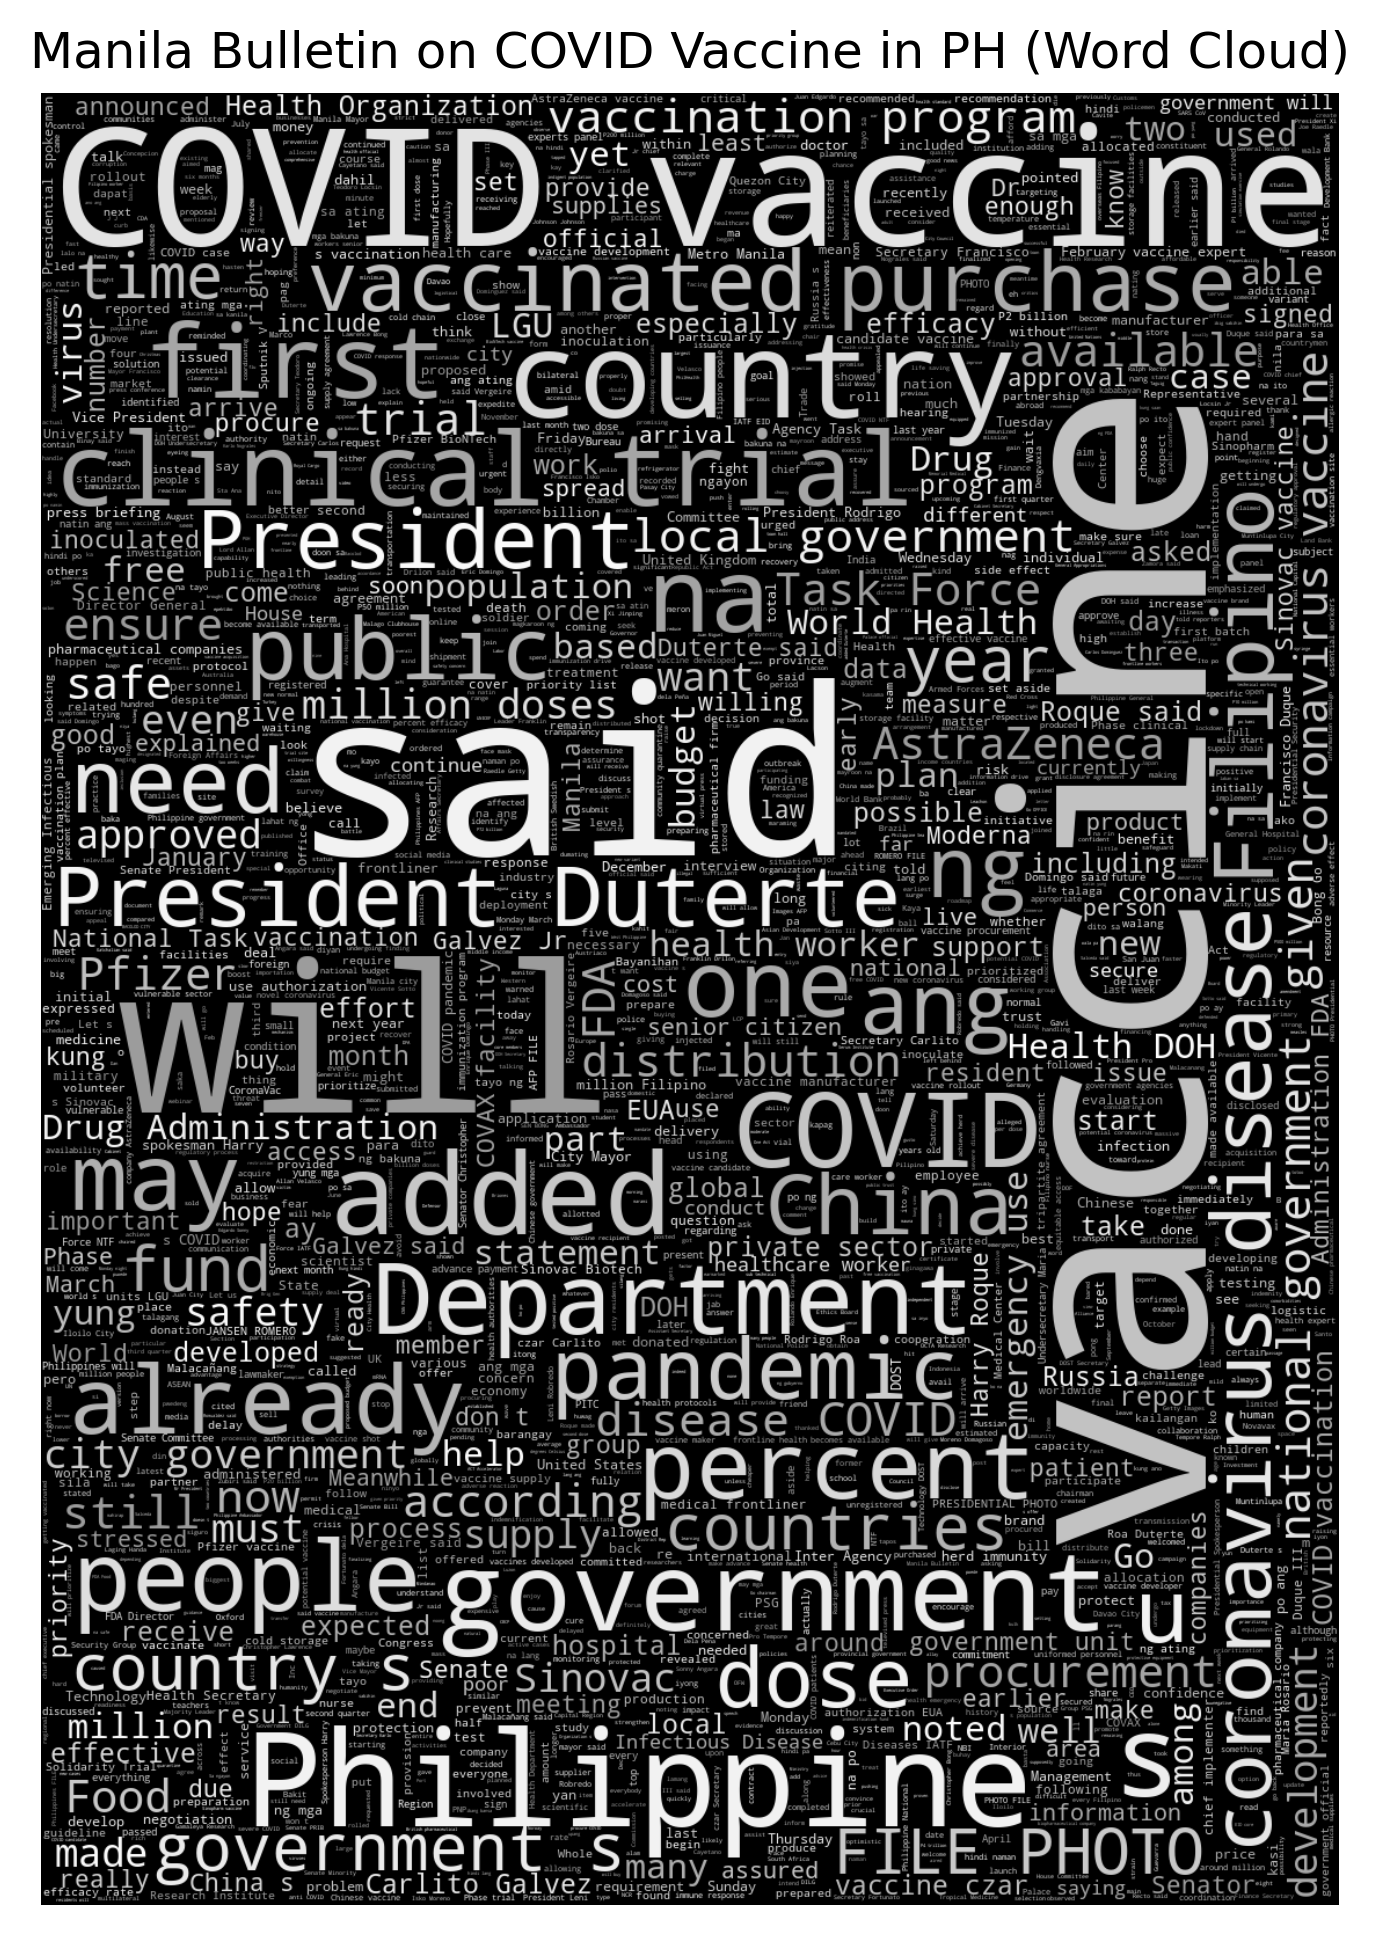

In [34]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)

mask = np.array(Image.open('bg.png'))

words = ' '.join(df['articles_content'].tolist())
wordcloud = WordCloud(background_color='black', max_words=2000, width=1024, height=720, mask=mask)
wordcloud.generate(words)

plt.figure(figsize=(20, 8), dpi=300)
plt.title('Manila Bulletin on COVID Vaccine in PH (Word Cloud)')
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42), interpolation='bilinear')
plt.axis('off')
plt.show()